# Human Spleen CODEX + RNA-seq Integration with MaxFuse and MARIO

This notebook integrates human spleen CODEX protein data (exported as TSV from QuPath) with scRNA-seq data using **both MaxFuse and MARIO** methods for comparison.

## Data Sources
- **CODEX**: `data/1904CC2B_cells.tsv` - freshly exported spleen CODEX data with 26 protein markers
- **RNA-seq**: Raw unfiltered 10x data from `data/raw_feature_bc_matrix/` (includes empty droplets)

## Pipeline Overview
1. Load and preprocess CODEX data from TSV
2. Load and filter raw RNA-seq data (cell calling from raw counts)
3. Build protein-gene correspondence
4. **MARIO: Matchability test** (pre-integration diagnostic)
5. **MARIO: Integration with interpolation** (optimal weight search)
6. **MaxFuse: Integration pipeline**
7. **Compare results** from both methods
8. Transfer cell type labels from RNA to spatial CODEX coordinates

## Methods
- **MARIO**: Uses overlapping features for initial matching, CCA refinement, weight interpolation, and joint regularized clustering
- **MaxFuse**: Uses graph smoothing, iterative CCA refinement, and pivot-based propagation

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import sparse

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

import anndata as ad
import scanpy as sc
import maxfuse as mf

# Import MARIO from maxfuse package
from maxfuse import Mario
from maxfuse.mario.match import pipelined_mario

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

print(f"MaxFuse package loaded")
print(f"MARIO loaded from maxfuse.mario")
print(f"Scanpy version: {sc.__version__}")

## Step 1: Load and Preprocess CODEX Data

The CODEX data is exported from QuPath as a TSV file with cell measurements.
We extract:
- Cell centroids (X, Y coordinates)
- Mean protein intensities for each marker

In [ ]:
# Load CODEX data from TSV
codex_df = pd.read_csv('data/1904CC2B_cells.tsv', sep='\t')
print(f"CODEX data shape: {codex_df.shape}")
print(f"Columns: {len(codex_df.columns)}")

In [3]:
# Identify protein marker columns (Cell: *: Mean)
marker_cols = [col for col in codex_df.columns if col.startswith('Cell:') and col.endswith(': Mean')]
print(f"Found {len(marker_cols)} protein markers:")
for col in marker_cols:
    # Extract marker name from column name like "Cell: CD1c (C1): Mean"
    marker = col.split(':')[1].strip().split('(')[0].strip()
    print(f"  {marker}")

Found 26 protein markers:
  CD1c
  CD3e
  CD4
  CD8
  CD11c
  CD15
  CD20
  CD21
  CD31
  CD34
  CD35
  CD44
  CD45
  CD45RO
  CD68
  CD107a
  CD163
  CollagenIV
  DAPI
  ECAD
  FoxP3
  HLADR
  Ki67
  Lyve1
  SMActin
  Vimentin


In [4]:
# Extract marker names and build protein expression matrix
marker_names = []
for col in marker_cols:
    # Parse "Cell: CD1c (C1): Mean" -> "CD1c"
    marker = col.split(':')[1].strip().split('(')[0].strip()
    marker_names.append(marker)

# Create protein expression matrix
protein_matrix = codex_df[marker_cols].values
print(f"Protein matrix shape: {protein_matrix.shape}")
print(f"Markers: {marker_names}")

Protein matrix shape: (172181, 26)
Markers: ['CD1c', 'CD3e', 'CD4', 'CD8', 'CD11c', 'CD15', 'CD20', 'CD21', 'CD31', 'CD34', 'CD35', 'CD44', 'CD45', 'CD45RO', 'CD68', 'CD107a', 'CD163', 'CollagenIV', 'DAPI', 'ECAD', 'FoxP3', 'HLADR', 'Ki67', 'Lyve1', 'SMActin', 'Vimentin']


In [5]:
# Extract spatial coordinates
# Look for centroid columns
x_col = [col for col in codex_df.columns if 'Centroid X' in col][0]
y_col = [col for col in codex_df.columns if 'Centroid Y' in col][0]
print(f"X coordinate column: {x_col}")
print(f"Y coordinate column: {y_col}")

x_coords = codex_df[x_col].values
y_coords = codex_df[y_col].values
print(f"\nSpatial extent:")
print(f"  X: {x_coords.min():.1f} - {x_coords.max():.1f}")
print(f"  Y: {y_coords.min():.1f} - {y_coords.max():.1f}")

X coordinate column: Centroid X µm
Y coordinate column: Centroid Y µm

Spatial extent:
  X: 0.5 - 3571.2
  Y: 0.4 - 3390.8


In [6]:
# Create AnnData object for protein data
protein_adata = ad.AnnData(protein_matrix.astype(np.float32))
protein_adata.var_names = marker_names
protein_adata.obs['X_centroid'] = x_coords
protein_adata.obs['Y_centroid'] = y_coords
protein_adata.obs_names = [f"cell_{i}" for i in range(protein_adata.n_obs)]

print(f"Protein AnnData: {protein_adata.shape}")
print(f"Markers: {list(protein_adata.var_names)}")

Protein AnnData: (172181, 26)
Markers: ['CD1c', 'CD3e', 'CD4', 'CD8', 'CD11c', 'CD15', 'CD20', 'CD21', 'CD31', 'CD34', 'CD35', 'CD44', 'CD45', 'CD45RO', 'CD68', 'CD107a', 'CD163', 'CollagenIV', 'DAPI', 'ECAD', 'FoxP3', 'HLADR', 'Ki67', 'Lyve1', 'SMActin', 'Vimentin']


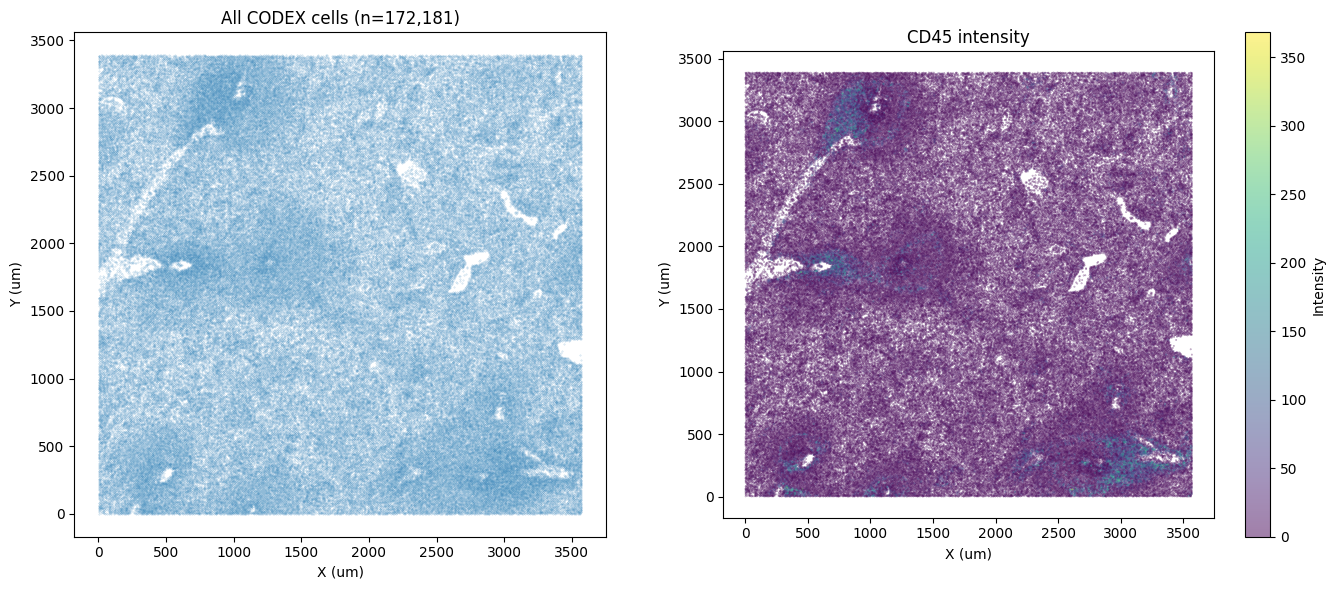

In [7]:
# Quick spatial visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot all cells
axes[0].scatter(x_coords, y_coords, s=0.1, alpha=0.3)
axes[0].set_xlabel('X (um)')
axes[0].set_ylabel('Y (um)')
axes[0].set_title(f'All CODEX cells (n={len(x_coords):,})')
axes[0].set_aspect('equal')

# Plot with CD45 intensity
cd45_idx = marker_names.index('CD45') if 'CD45' in marker_names else 0
scatter = axes[1].scatter(x_coords, y_coords, c=protein_matrix[:, cd45_idx], 
                          s=0.1, alpha=0.5, cmap='viridis')
axes[1].set_xlabel('X (um)')
axes[1].set_ylabel('Y (um)')
axes[1].set_title(f'{marker_names[cd45_idx]} intensity')
axes[1].set_aspect('equal')
plt.colorbar(scatter, ax=axes[1], label='Intensity')

plt.tight_layout()
plt.show()

In [8]:
# Diagnostic: Explore CODEX data quality metrics
# QuPath exports many morphology features we can use for filtering

print("Available columns in CODEX data:")
print("="*60)

# Group columns by type
morphology_cols = [c for c in codex_df.columns if 'Area' in c or 'Perimeter' in c or 
                   'Circularity' in c or 'Solidity' in c or 'Eccentricity' in c]
intensity_cols = [c for c in codex_df.columns if 'Mean' in c or 'Median' in c or 'Max' in c]
location_cols = [c for c in codex_df.columns if 'Centroid' in c or 'centroid' in c]

print(f"\nMorphology columns ({len(morphology_cols)}):")
for c in morphology_cols[:10]:
    print(f"  {c}")
if len(morphology_cols) > 10:
    print(f"  ... and {len(morphology_cols)-10} more")

print(f"\nKey morphology stats:")
if 'Cell: Area µm^2' in codex_df.columns:
    area = codex_df['Cell: Area µm^2']
    print(f"  Cell Area: {area.min():.1f} - {area.max():.1f} µm² (median: {area.median():.1f})")
if 'Nucleus: Area µm^2' in codex_df.columns:
    nuc_area = codex_df['Nucleus: Area µm^2']
    print(f"  Nucleus Area: {nuc_area.min():.1f} - {nuc_area.max():.1f} µm² (median: {nuc_area.median():.1f})")
if 'Cell: Circularity' in codex_df.columns:
    circ = codex_df['Cell: Circularity']
    print(f"  Circularity: {circ.min():.2f} - {circ.max():.2f} (median: {circ.median():.2f})")

Available columns in CODEX data:

Morphology columns (6):
  Nucleus: Area µm^2
  Nucleus: Circularity
  Nucleus: Solidity
  Cell: Area µm^2
  Cell: Circularity
  Cell: Solidity

Key morphology stats:
  Cell Area: 0.2 - 343.5 µm² (median: 44.0)
  Nucleus Area: 0.7 - 168.8 µm² (median: 30.2)
  Circularity: 0.11 - 0.79 (median: 0.55)


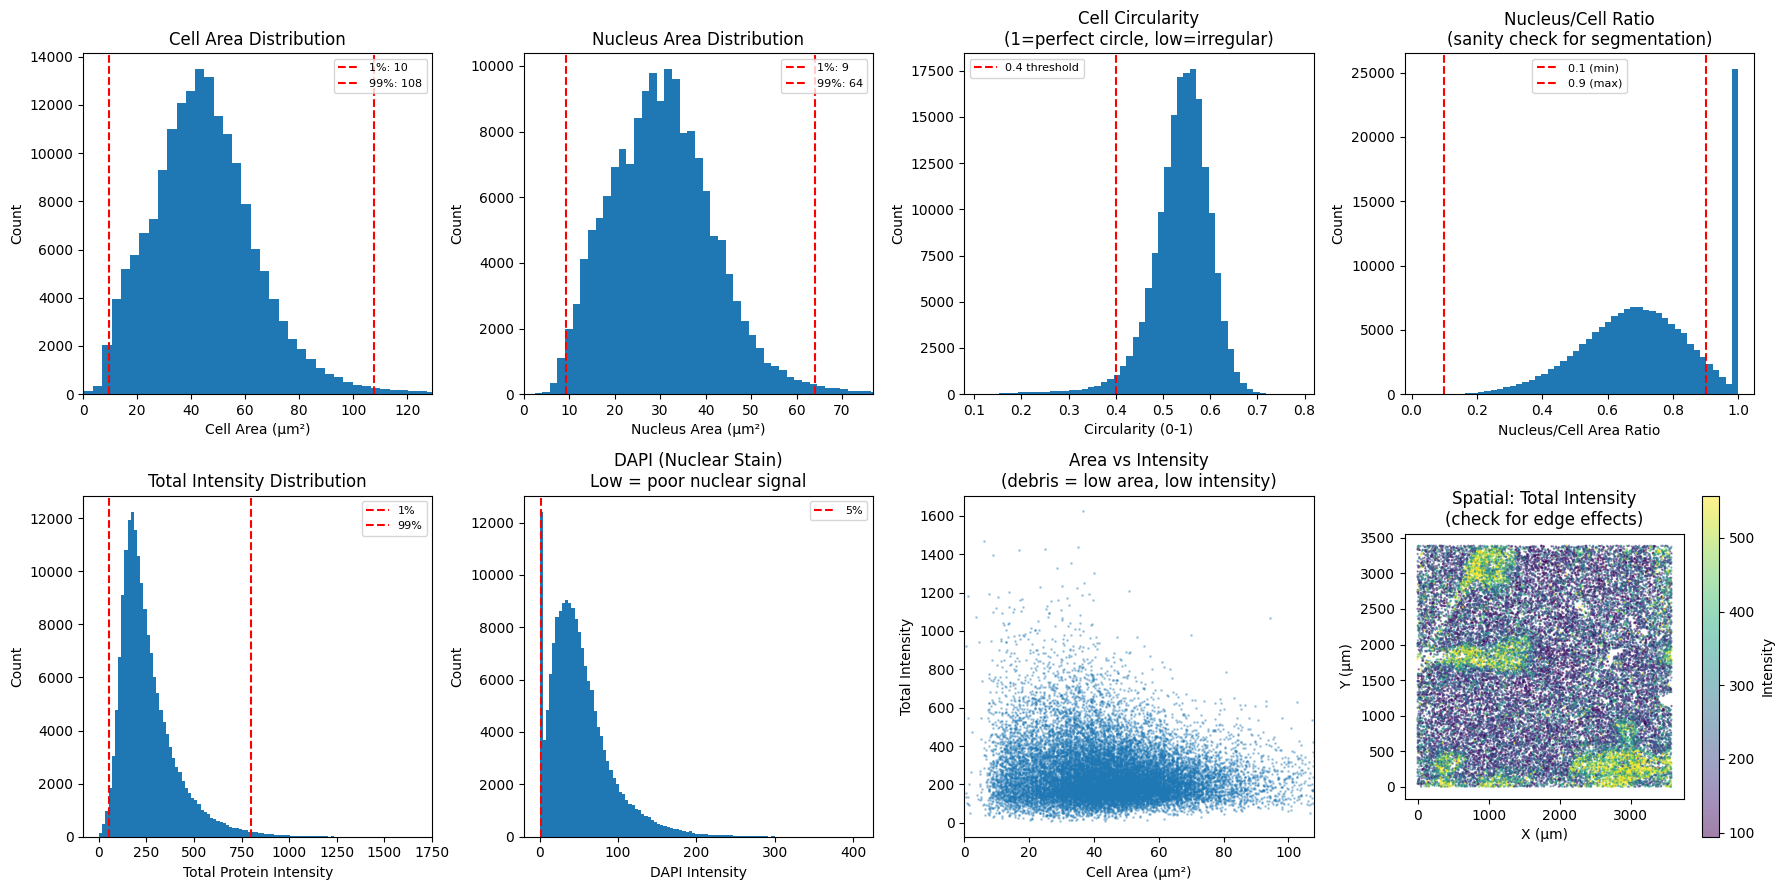


PROTEIN DATA QC SUMMARY
Total cells: 172,181

Suggested filters (adjust based on plots above):
  Cell Area: 10 - 108 µm²
  Circularity: > 0.3-0.4 (remove irregular shapes)
  Total Intensity: > 54.3 (remove debris)


In [9]:
# Visualize protein/CODEX QC metrics for filtering
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

# Row 1: Morphology distributions
# Cell Area
if 'Cell: Area µm^2' in codex_df.columns:
    area = codex_df['Cell: Area µm^2']
    axes[0, 0].hist(area, bins=100, edgecolor='none')
    axes[0, 0].set_xlabel('Cell Area (µm²)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Cell Area Distribution')
    axes[0, 0].axvline(x=area.quantile(0.01), color='r', linestyle='--', label=f'1%: {area.quantile(0.01):.0f}')
    axes[0, 0].axvline(x=area.quantile(0.99), color='r', linestyle='--', label=f'99%: {area.quantile(0.99):.0f}')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].set_xlim(0, area.quantile(0.99)*1.2)

# Nucleus Area
if 'Nucleus: Area µm^2' in codex_df.columns:
    nuc_area = codex_df['Nucleus: Area µm^2']
    axes[0, 1].hist(nuc_area, bins=100, edgecolor='none')
    axes[0, 1].set_xlabel('Nucleus Area (µm²)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Nucleus Area Distribution')
    axes[0, 1].axvline(x=nuc_area.quantile(0.01), color='r', linestyle='--', label=f'1%: {nuc_area.quantile(0.01):.0f}')
    axes[0, 1].axvline(x=nuc_area.quantile(0.99), color='r', linestyle='--', label=f'99%: {nuc_area.quantile(0.99):.0f}')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].set_xlim(0, nuc_area.quantile(0.99)*1.2)

# Circularity
if 'Cell: Circularity' in codex_df.columns:
    circ = codex_df['Cell: Circularity']
    axes[0, 2].hist(circ, bins=50, edgecolor='none')
    axes[0, 2].set_xlabel('Circularity (0-1)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Cell Circularity\n(1=perfect circle, low=irregular)')
    axes[0, 2].axvline(x=0.4, color='r', linestyle='--', label='0.4 threshold')
    axes[0, 2].legend(fontsize=8)

# Nucleus/Cell ratio
if 'Cell: Area µm^2' in codex_df.columns and 'Nucleus: Area µm^2' in codex_df.columns:
    nc_ratio = codex_df['Nucleus: Area µm^2'] / codex_df['Cell: Area µm^2']
    axes[0, 3].hist(nc_ratio, bins=50, edgecolor='none')
    axes[0, 3].set_xlabel('Nucleus/Cell Area Ratio')
    axes[0, 3].set_ylabel('Count')
    axes[0, 3].set_title('Nucleus/Cell Ratio\n(sanity check for segmentation)')
    axes[0, 3].axvline(x=0.1, color='r', linestyle='--', label='0.1 (min)')
    axes[0, 3].axvline(x=0.9, color='r', linestyle='--', label='0.9 (max)')
    axes[0, 3].legend(fontsize=8)

# Row 2: Intensity and spatial
# Total intensity (sum of all markers)
total_intensity = protein_matrix.sum(axis=1)
axes[1, 0].hist(total_intensity, bins=100, edgecolor='none')
axes[1, 0].set_xlabel('Total Protein Intensity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Total Intensity Distribution')
axes[1, 0].axvline(x=np.percentile(total_intensity, 1), color='r', linestyle='--', label=f'1%')
axes[1, 0].axvline(x=np.percentile(total_intensity, 99), color='r', linestyle='--', label=f'99%')
axes[1, 0].legend(fontsize=8)

# DAPI intensity (nuclear stain - quality indicator)
if 'DAPI' in marker_names:
    dapi_idx = marker_names.index('DAPI')
    dapi = protein_matrix[:, dapi_idx]
    axes[1, 1].hist(dapi, bins=100, edgecolor='none')
    axes[1, 1].set_xlabel('DAPI Intensity')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('DAPI (Nuclear Stain)\nLow = poor nuclear signal')
    axes[1, 1].axvline(x=np.percentile(dapi, 5), color='r', linestyle='--', label='5%')
    axes[1, 1].legend(fontsize=8)
else:
    axes[1, 1].text(0.5, 0.5, 'DAPI not found', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('DAPI Intensity')

# Cell area vs total intensity (reveals debris vs cells)
if 'Cell: Area µm^2' in codex_df.columns:
    sample_idx = np.random.choice(len(codex_df), min(20000, len(codex_df)), replace=False)
    axes[1, 2].scatter(codex_df['Cell: Area µm^2'].values[sample_idx], 
                       total_intensity[sample_idx], s=1, alpha=0.3)
    axes[1, 2].set_xlabel('Cell Area (µm²)')
    axes[1, 2].set_ylabel('Total Intensity')
    axes[1, 2].set_title('Area vs Intensity\n(debris = low area, low intensity)')
    axes[1, 2].set_xlim(0, codex_df['Cell: Area µm^2'].quantile(0.99))

# Spatial distribution colored by total intensity
sample_idx = np.random.choice(len(codex_df), min(30000, len(codex_df)), replace=False)
scatter = axes[1, 3].scatter(x_coords[sample_idx], y_coords[sample_idx], 
                              c=total_intensity[sample_idx], s=0.5, alpha=0.5,
                              cmap='viridis', vmin=np.percentile(total_intensity, 5),
                              vmax=np.percentile(total_intensity, 95))
axes[1, 3].set_xlabel('X (µm)')
axes[1, 3].set_ylabel('Y (µm)')
axes[1, 3].set_title('Spatial: Total Intensity\n(check for edge effects)')
axes[1, 3].set_aspect('equal')
plt.colorbar(scatter, ax=axes[1, 3], label='Intensity')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PROTEIN DATA QC SUMMARY")
print("="*60)
print(f"Total cells: {len(codex_df):,}")
print(f"\nSuggested filters (adjust based on plots above):")
if 'Cell: Area µm^2' in codex_df.columns:
    print(f"  Cell Area: {area.quantile(0.01):.0f} - {area.quantile(0.99):.0f} µm²")
if 'Cell: Circularity' in codex_df.columns:
    print(f"  Circularity: > 0.3-0.4 (remove irregular shapes)")
print(f"  Total Intensity: > {np.percentile(total_intensity, 1):.1f} (remove debris)")

In [10]:
# Apply protein/CODEX filtering
# Adjust these thresholds based on the diagnostic plots above

# Morphology filters
# MIN_CELL_AREA = 10       # µm² - remove debris/fragments
# MAX_CELL_AREA = 100      # µm² - remove merged cells/clumps
# MIN_CIRCULARITY = 0.3    # Remove very irregular shapes (segmentation errors)

# # Intensity filters  
# MIN_TOTAL_INTENSITY = 00  # Remove very dim cells (debris, out of focus)


# print("Protein filtering criteria:")
# print(f"  Cell Area: {MIN_CELL_AREA} - {MAX_CELL_AREA} µm²")
# print(f"  Min Circularity: {MIN_CIRCULARITY}")
# print(f"  Min Total Intensity: {MIN_TOTAL_INTENSITY}")

# # Build filter mask
# protein_mask = np.ones(len(codex_df), dtype=bool)

# if 'Cell: Area µm^2' in codex_df.columns:
#     area = codex_df['Cell: Area µm^2'].values
#     protein_mask &= (area >= MIN_CELL_AREA) & (area <= MAX_CELL_AREA)
#     print(f"\nAfter area filter: {protein_mask.sum():,} cells")

# if 'Cell: Circularity' in codex_df.columns:
#     circ = codex_df['Cell: Circularity'].values
#     protein_mask &= (circ >= MIN_CIRCULARITY)
#     print(f"After circularity filter: {protein_mask.sum():,} cells")

# total_intensity = protein_matrix.sum(axis=1)
# protein_mask &= (total_intensity >= MIN_TOTAL_INTENSITY)
# print(f"After intensity filter: {protein_mask.sum():,} cells")

# print(f"\nFiltered: {len(codex_df):,} → {protein_mask.sum():,} cells ({100*protein_mask.sum()/len(codex_df):.1f}% retained)")

# # Apply filter to all protein data
# codex_df_filtered = codex_df[protein_mask].reset_index(drop=True)
# protein_matrix_filtered = protein_matrix[protein_mask]
# x_coords_filtered = x_coords[protein_mask]
# y_coords_filtered = y_coords[protein_mask]

# # Update variables for downstream use
# codex_df = codex_df_filtered
# protein_matrix = protein_matrix_filtered
# x_coords = x_coords_filtered
# y_coords = y_coords_filtered

# # IMPORTANT: Recreate protein_adata with filtered data
# protein_adata = ad.AnnData(protein_matrix.astype(np.float32))
# protein_adata.var_names = marker_names
# protein_adata.obs['X_centroid'] = x_coords
# protein_adata.obs['Y_centroid'] = y_coords
# protein_adata.obs_names = [f"cell_{i}" for i in range(protein_adata.n_obs)]

# print(f"\nProtein data updated: {protein_matrix.shape}")
# print(f"protein_adata recreated: {protein_adata.shape}")


## Step 2: Load and Filter RNA-seq Data

We use **raw unfiltered** 10x data to ensure proper cell calling.
This avoids issues from pre-filtered data that may have been processed differently.

In [ ]:
# Load RAW RNA data (unfiltered - includes empty droplets)
print("Loading RAW RNA matrix (this may take a moment)...")
rna_mtx = mmread("data/raw_feature_bc_matrix/matrix.mtx.gz")
rna_names = pd.read_csv('data/raw_feature_bc_matrix/features.tsv.gz', sep='\t', header=None)[1].to_numpy()
rna_barcodes = pd.read_csv('data/raw_feature_bc_matrix/barcodes.tsv.gz', header=None)[0].values

rna_adata = ad.AnnData(rna_mtx.T.tocsr(), dtype=np.float32)
rna_adata.var_names = rna_names
rna_adata.var_names_make_unique()
rna_adata.obs_names = rna_barcodes

print(f"RNA raw (unfiltered): {rna_adata.shape}")
print(f"  This includes empty droplets - will filter next")

In [12]:
# Calculate QC metrics for cell filtering
print("Calculating QC metrics...")

# Basic QC metrics
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(f"\nQC metric ranges (before filtering):")
print(f"  Total counts: {rna_adata.obs['total_counts'].min():.0f} - {rna_adata.obs['total_counts'].max():.0f}")
print(f"  Genes detected: {rna_adata.obs['n_genes_by_counts'].min():.0f} - {rna_adata.obs['n_genes_by_counts'].max():.0f}")
print(f"  MT %: {rna_adata.obs['pct_counts_mt'].min():.1f} - {rna_adata.obs['pct_counts_mt'].max():.1f}")

Calculating QC metrics...

QC metric ranges (before filtering):
  Total counts: 0 - 93646
  Genes detected: 0 - 7090
  MT %: 0.0 - 100.0


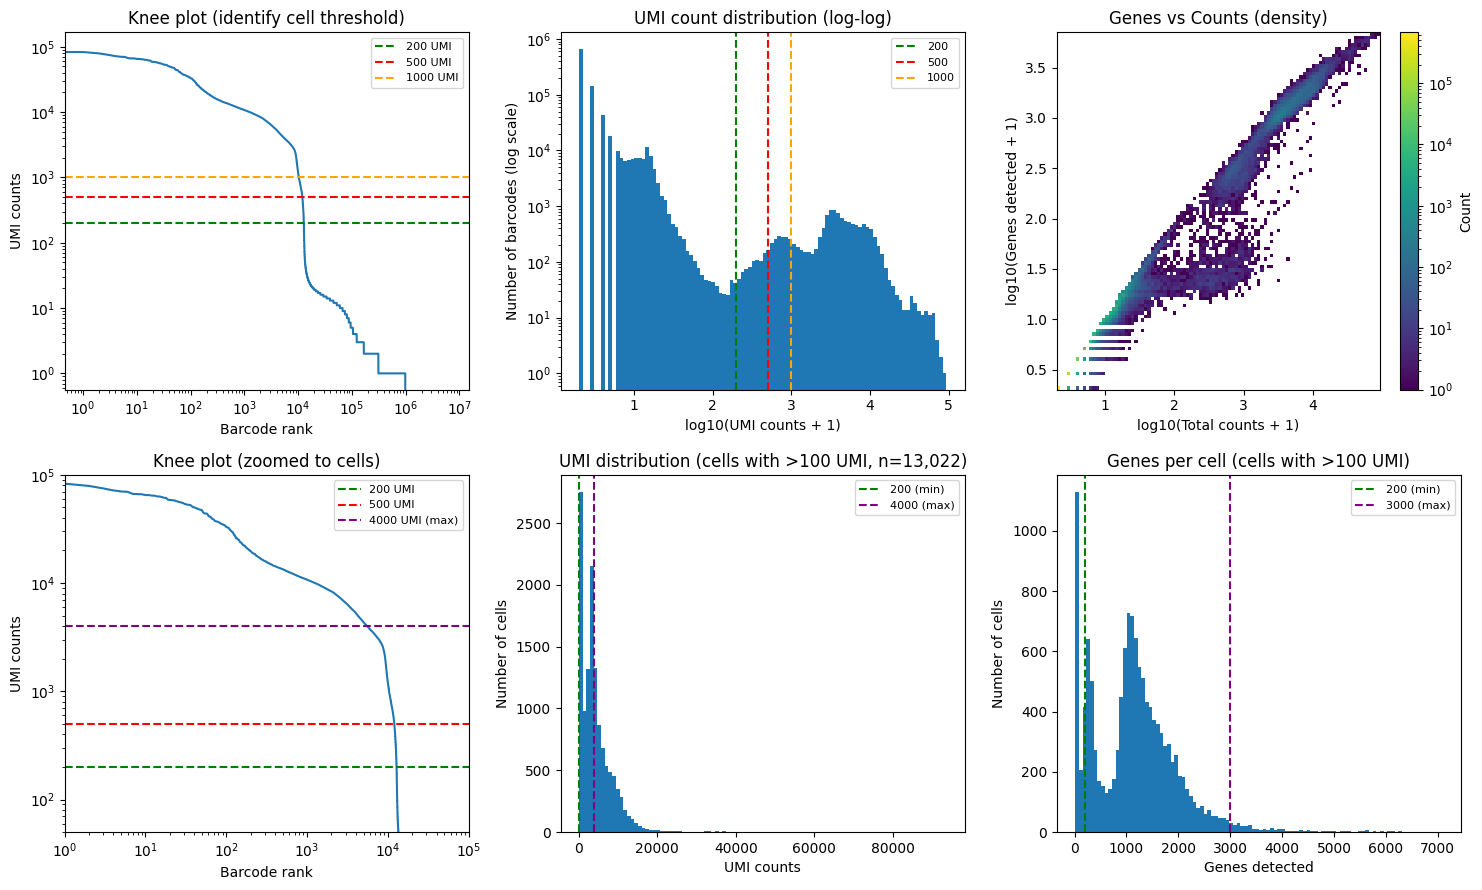


Cell counts at different UMI thresholds:
  >=  100 UMI: 13,022 cells
  >=  200 UMI: 12,795 cells
  >=  300 UMI: 12,557 cells
  >=  500 UMI: 11,999 cells
  >= 1000 UMI: 10,335 cells
  >= 2000 UMI: 9,269 cells
  >= 4000 UMI: 5,528 cells


In [13]:
# Visualize count distribution to identify cell calling threshold
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Row 1: Full data view
# Knee plot - sorted UMI counts
counts_sorted = np.sort(rna_adata.obs['total_counts'].values)[::-1]
axes[0, 0].plot(np.arange(len(counts_sorted)), counts_sorted)
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Barcode rank')
axes[0, 0].set_ylabel('UMI counts')
axes[0, 0].set_title('Knee plot (identify cell threshold)')
axes[0, 0].axhline(y=200, color='g', linestyle='--', label='200 UMI')
axes[0, 0].axhline(y=500, color='r', linestyle='--', label='500 UMI')
axes[0, 0].axhline(y=1000, color='orange', linestyle='--', label='1000 UMI')
axes[0, 0].legend(fontsize=8)

# Histogram of counts - LOG Y-AXIS to see cell population
counts_nonzero = rna_adata.obs['total_counts'][rna_adata.obs['total_counts'] > 0]
axes[0, 1].hist(np.log10(counts_nonzero + 1), bins=100)
axes[0, 1].set_yscale('log')  # Log y-axis to see the cell population
axes[0, 1].set_xlabel('log10(UMI counts + 1)')
axes[0, 1].set_ylabel('Number of barcodes (log scale)')
axes[0, 1].set_title('UMI count distribution (log-log)')
axes[0, 1].axvline(x=np.log10(200), color='g', linestyle='--', label='200')
axes[0, 1].axvline(x=np.log10(500), color='r', linestyle='--', label='500')
axes[0, 1].axvline(x=np.log10(1000), color='orange', linestyle='--', label='1000')
axes[0, 1].legend(fontsize=8)

# Genes vs counts - use 2D histogram for density
mask = rna_adata.obs['total_counts'] > 0
x_data = np.log10(rna_adata.obs['total_counts'].values[mask] + 1)
y_data = np.log10(rna_adata.obs['n_genes_by_counts'].values[mask] + 1)
h = axes[0, 2].hist2d(x_data, y_data, bins=100, cmap='viridis', norm='log')
axes[0, 2].set_xlabel('log10(Total counts + 1)')
axes[0, 2].set_ylabel('log10(Genes detected + 1)')
axes[0, 2].set_title('Genes vs Counts (density)')
plt.colorbar(h[3], ax=axes[0, 2], label='Count')

# Row 2: Zoomed to cell population (counts > 100)
cell_mask = rna_adata.obs['total_counts'] >= 100

# Zoomed knee plot
axes[1, 0].plot(np.arange(len(counts_sorted)), counts_sorted)
axes[1, 0].set_xscale('log')
axes[1, 0].set_xlim(1, 1e5)
axes[1, 0].set_ylim(50, 1e5)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Barcode rank')
axes[1, 0].set_ylabel('UMI counts')
axes[1, 0].set_title('Knee plot (zoomed to cells)')
axes[1, 0].axhline(y=200, color='g', linestyle='--', label='200 UMI')
axes[1, 0].axhline(y=500, color='r', linestyle='--', label='500 UMI')
axes[1, 0].axhline(y=4000, color='purple', linestyle='--', label='4000 UMI (max)')
axes[1, 0].legend(fontsize=8)

# Histogram zoomed to cells only
cell_counts = rna_adata.obs['total_counts'][cell_mask]
axes[1, 1].hist(cell_counts, bins=100)
axes[1, 1].set_xlabel('UMI counts')
axes[1, 1].set_ylabel('Number of cells')
axes[1, 1].set_title(f'UMI distribution (cells with >100 UMI, n={cell_mask.sum():,})')
axes[1, 1].axvline(x=200, color='g', linestyle='--', label='200 (min)')
axes[1, 1].axvline(x=4000, color='purple', linestyle='--', label='4000 (max)')
axes[1, 1].legend(fontsize=8)

# Genes histogram zoomed to cells
cell_genes = rna_adata.obs['n_genes_by_counts'][cell_mask]
axes[1, 2].hist(cell_genes, bins=100)
axes[1, 2].set_xlabel('Genes detected')
axes[1, 2].set_ylabel('Number of cells')
axes[1, 2].set_title(f'Genes per cell (cells with >100 UMI)')
axes[1, 2].axvline(x=200, color='g', linestyle='--', label='200 (min)')
axes[1, 2].axvline(x=3000, color='purple', linestyle='--', label='3000 (max)')
axes[1, 2].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Count cells at different thresholds
print("\nCell counts at different UMI thresholds:")
for thresh in [100, 200, 300, 500, 1000, 2000, 4000]:
    n_cells = (rna_adata.obs['total_counts'] >= thresh).sum()
    print(f"  >= {thresh:4d} UMI: {n_cells:,} cells")

In [14]:
# Interactive QC Dashboard with Linked Threshold Sliders
# Adjust sliders to see thresholds update across all plots simultaneously

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Prepare data - handle NaN values
obs = rna_adata.obs
total_counts = obs['total_counts'].values
n_genes = obs['n_genes_by_counts'].values
pct_mt = obs['pct_counts_mt'].values

# Create mask for valid data (no NaNs, meets minimum count threshold)
valid_mask = (
    ~np.isnan(total_counts) & 
    ~np.isnan(n_genes) & 
    ~np.isnan(pct_mt) &
    (total_counts >= 100)
)

print(f"Total barcodes: {len(obs):,}")
print(f"Valid cells (no NaN, >= 100 UMI): {valid_mask.sum():,}")
print(f"Excluded (NaN or low UMI): {(~valid_mask).sum():,}")

# Get data ranges from valid data
umi_data_min = int(np.floor(total_counts[valid_mask].min()))
umi_data_max = int(np.ceil(total_counts[valid_mask].max()))
genes_data_min = int(np.floor(n_genes[valid_mask].min()))
genes_data_max = int(np.ceil(n_genes[valid_mask].max()))
mt_data_min = 0
mt_data_max = float(np.ceil(pct_mt[valid_mask].max()))

print(f"\nData ranges:")
print(f"  UMI: {umi_data_min:,} - {umi_data_max:,}")
print(f"  Genes: {genes_data_min:,} - {genes_data_max:,}")
print(f"  MT%: {mt_data_min:.1f} - {mt_data_max:.1f}")

# Subsample for performance if needed
n_points = min(50000, valid_mask.sum())
if valid_mask.sum() > n_points:
    valid_indices = np.where(valid_mask)[0]
    subsample_idx = np.random.choice(valid_indices, n_points, replace=False)
    scatter_mask = np.zeros(len(obs), dtype=bool)
    scatter_mask[subsample_idx] = True
else:
    scatter_mask = valid_mask

# Create figure with subplots - explicit axis mapping
# FIXED: Specify type='domain' for the pie chart subplot at (2, 3)
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        'MT% Distribution', 
        'MT% vs UMI Counts',
        'Genes vs Counts (colored by MT%)',
        'UMI Distribution',
        'Genes Distribution',
        'Cells Passing Filters'
    ),
    specs=[[{}, {}, {}], [{}, {}, {"type": "domain"}]],  # pie chart needs domain type
    vertical_spacing=0.15,
    horizontal_spacing=0.08
)

# Subplot axis mapping:
# (1,1) -> x1, y1 (MT% histogram)
# (1,2) -> x2, y2 (MT% vs UMI scatter)
# (1,3) -> x3, y3 (Genes vs UMI scatter)
# (2,1) -> x4, y4 (UMI histogram)
# (2,2) -> x5, y5 (Genes histogram)
# (2,3) -> domain (pie chart)

# Initial threshold values
init_mt = mt_data_max
init_min_umi = umi_data_min
init_max_umi = umi_data_max
init_min_genes = genes_data_min
init_max_genes = genes_data_max

# 1. MT% histogram (row=1, col=1 -> x, y)
mt_valid = pct_mt[valid_mask]
mt_hist = np.histogram(mt_valid, bins=100)
fig.add_trace(go.Bar(x=mt_hist[1][:-1], y=mt_hist[0], name='MT%', 
                     marker_color='steelblue', showlegend=False), row=1, col=1)

# 2. MT% vs UMI scatter (row=1, col=2 -> x2, y2)
fig.add_trace(go.Scattergl(
    x=total_counts[scatter_mask],
    y=pct_mt[scatter_mask],
    mode='markers',
    marker=dict(size=2, opacity=0.3, color='steelblue'),
    name='Cells',
    showlegend=False,
    hovertemplate='UMI: %{x}<br>MT%%: %{y:.1f}<extra></extra>'
), row=1, col=2)

# 3. Genes vs Counts colored by MT% (row=1, col=3 -> x3, y3)
fig.add_trace(go.Scattergl(
    x=total_counts[scatter_mask],
    y=n_genes[scatter_mask],
    mode='markers',
    marker=dict(
        size=2, opacity=0.5,
        color=pct_mt[scatter_mask],
        colorscale='RdYlBu_r',
        cmin=0, cmax=30,
        colorbar=dict(title='MT%', x=1.02, len=0.4, y=0.8)
    ),
    name='Cells',
    showlegend=False,
    hovertemplate='UMI: %{x}<br>Genes: %{y}<br>MT%%: %{marker.color:.1f}<extra></extra>'
), row=1, col=3)

# 4. UMI histogram (row=2, col=1 -> x4, y4)
umi_valid = total_counts[valid_mask]
umi_hist_max = min(umi_data_max, 20000)
umi_hist = np.histogram(umi_valid[umi_valid <= umi_hist_max], bins=100, range=(0, umi_hist_max))
fig.add_trace(go.Bar(x=umi_hist[1][:-1], y=umi_hist[0], name='UMI', 
                     marker_color='steelblue', showlegend=False), row=2, col=1)

# 5. Genes histogram (row=2, col=2 -> x5, y5)
genes_valid = n_genes[valid_mask]
genes_hist = np.histogram(genes_valid, bins=100)
fig.add_trace(go.Bar(x=genes_hist[1][:-1], y=genes_hist[0], name='Genes', 
                     marker_color='steelblue', showlegend=False), row=2, col=2)

# 6. Summary pie chart (row=2, col=3 -> domain type)
fig.add_trace(go.Pie(
    values=[valid_mask.sum(), 0],
    labels=['Pass', 'Fail'],
    marker_colors=['#90EE90', '#FFB6C1'],
    hole=0.4,
    showlegend=False,
    textinfo='percent+label'
), row=2, col=3)

# Add threshold lines with EXPLICIT axis references
# MT% threshold (red) - horizontal lines on scatter plots, vertical on histogram
shapes = []

# MT histogram vertical line (x, y)
shapes.append(dict(type='line', x0=init_mt, x1=init_mt, y0=0, y1=1, yref='y domain',
                   xref='x', line=dict(color='red', dash='dash', width=2)))

# MT vs UMI horizontal line (x2, y2)
shapes.append(dict(type='line', x0=0, x1=1, xref='x2 domain', y0=init_mt, y1=init_mt,
                   yref='y2', line=dict(color='red', dash='dash', width=2)))

# Min UMI vertical lines (green)
shapes.append(dict(type='line', x0=init_min_umi, x1=init_min_umi, y0=0, y1=1, yref='y2 domain',
                   xref='x2', line=dict(color='green', dash='dash', width=2)))
shapes.append(dict(type='line', x0=init_min_umi, x1=init_min_umi, y0=0, y1=1, yref='y3 domain',
                   xref='x3', line=dict(color='green', dash='dash', width=2)))
shapes.append(dict(type='line', x0=init_min_umi, x1=init_min_umi, y0=0, y1=1, yref='y4 domain',
                   xref='x4', line=dict(color='green', dash='dash', width=2)))

# Max UMI vertical lines (orange)
shapes.append(dict(type='line', x0=init_max_umi, x1=init_max_umi, y0=0, y1=1, yref='y2 domain',
                   xref='x2', line=dict(color='orange', dash='dash', width=2)))
shapes.append(dict(type='line', x0=init_max_umi, x1=init_max_umi, y0=0, y1=1, yref='y3 domain',
                   xref='x3', line=dict(color='orange', dash='dash', width=2)))
shapes.append(dict(type='line', x0=init_max_umi, x1=init_max_umi, y0=0, y1=1, yref='y4 domain',
                   xref='x4', line=dict(color='orange', dash='dash', width=2)))

# Min genes lines (purple)
shapes.append(dict(type='line', x0=0, x1=1, xref='x3 domain', y0=init_min_genes, y1=init_min_genes,
                   yref='y3', line=dict(color='purple', dash='dash', width=2)))
shapes.append(dict(type='line', x0=init_min_genes, x1=init_min_genes, y0=0, y1=1, yref='y5 domain',
                   xref='x5', line=dict(color='purple', dash='dash', width=2)))

# Max genes lines (brown)
shapes.append(dict(type='line', x0=0, x1=1, xref='x3 domain', y0=init_max_genes, y1=init_max_genes,
                   yref='y3', line=dict(color='saddlebrown', dash='dash', width=2)))
shapes.append(dict(type='line', x0=init_max_genes, x1=init_max_genes, y0=0, y1=1, yref='y5 domain',
                   xref='x5', line=dict(color='saddlebrown', dash='dash', width=2)))

fig.update_layout(shapes=shapes)

# Update axes
fig.update_xaxes(type='log', row=1, col=2, title_text='UMI Counts')
fig.update_xaxes(type='log', row=1, col=3, title_text='UMI Counts')
fig.update_yaxes(type='log', row=1, col=3, title_text='Genes')
fig.update_xaxes(range=[0, umi_hist_max], row=2, col=1, title_text='UMI Counts')
fig.update_xaxes(title_text='MT%', row=1, col=1)
fig.update_xaxes(title_text='Genes', row=2, col=2)
fig.update_yaxes(title_text='MT%', row=1, col=2)

fig.update_layout(
    height=700,
    width=1100,
    title_text='Interactive QC Dashboard - Drag sliders to adjust thresholds',
    title_x=0.5
)

# Convert to FigureWidget for interactivity
fig = go.FigureWidget(fig)

# Create sliders
mt_slider = widgets.FloatSlider(value=init_mt, min=0, max=mt_data_max, step=0.5, 
                                 description='Max MT%:', readout_format='.1f',
                                 style={'description_width': '80px'}, 
                                 layout=widgets.Layout(width='350px'))
min_umi_slider = widgets.IntSlider(value=init_min_umi, min=umi_data_min, max=umi_data_max//2, step=50, 
                                    description='Min UMI:',
                                    style={'description_width': '80px'}, 
                                    layout=widgets.Layout(width='350px'))
max_umi_slider = widgets.IntSlider(value=init_max_umi, min=umi_data_max//2, max=umi_data_max, step=100, 
                                    description='Max UMI:',
                                    style={'description_width': '80px'}, 
                                    layout=widgets.Layout(width='350px'))
min_genes_slider = widgets.IntSlider(value=init_min_genes, min=genes_data_min, max=genes_data_max//2, step=25, 
                                      description='Min Genes:',
                                      style={'description_width': '80px'}, 
                                      layout=widgets.Layout(width='350px'))
max_genes_slider = widgets.IntSlider(value=init_max_genes, min=genes_data_max//2, max=genes_data_max, step=50, 
                                      description='Max Genes:',
                                      style={'description_width': '80px'}, 
                                      layout=widgets.Layout(width='350px'))

# Output for cell count
cell_count_output = widgets.HTML(value='')

def update_thresholds(change):
    mt_max = mt_slider.value
    min_umi = min_umi_slider.value
    max_umi = max_umi_slider.value
    min_genes = min_genes_slider.value
    max_genes = max_genes_slider.value
    
    # Calculate cells remaining
    mask = (
        valid_mask &
        (total_counts >= min_umi) &
        (total_counts <= max_umi) &
        (n_genes >= min_genes) &
        (n_genes <= max_genes) &
        (pct_mt <= mt_max)
    )
    n_pass = mask.sum()
    n_fail = valid_mask.sum() - n_pass
    pct = 100 * n_pass / valid_mask.sum()
    
    with fig.batch_update():
        # Update threshold lines
        # Shape indices (in order they were added):
        # 0: MT histogram vline
        # 1: MT vs UMI hline  
        # 2-4: min UMI vlines (x2, x3, x4)
        # 5-7: max UMI vlines (x2, x3, x4)
        # 8-9: min genes lines (y3 hline, x5 vline)
        # 10-11: max genes lines (y3 hline, x5 vline)
        
        shapes = list(fig.layout.shapes)
        
        # MT threshold
        shapes[0]['x0'] = mt_max
        shapes[0]['x1'] = mt_max
        shapes[1]['y0'] = mt_max
        shapes[1]['y1'] = mt_max
        
        # Min UMI
        for i in [2, 3, 4]:
            shapes[i]['x0'] = min_umi
            shapes[i]['x1'] = min_umi
        
        # Max UMI
        for i in [5, 6, 7]:
            shapes[i]['x0'] = max_umi
            shapes[i]['x1'] = max_umi
        
        # Min genes
        shapes[8]['y0'] = min_genes
        shapes[8]['y1'] = min_genes
        shapes[9]['x0'] = min_genes
        shapes[9]['x1'] = min_genes
        
        # Max genes
        shapes[10]['y0'] = max_genes
        shapes[10]['y1'] = max_genes
        shapes[11]['x0'] = max_genes
        shapes[11]['x1'] = max_genes
        
        fig.layout.shapes = shapes
        
        # Update pie chart (trace index 5)
        fig.data[5].values = [n_pass, n_fail]
    
    cell_count_output.value = f"""
    <div style="font-size: 14px; padding: 10px; background: linear-gradient(to right, #90EE90 {pct}%, #FFB6C1 {pct}%); 
                border-radius: 5px; text-align: center;">
        <b>Cells passing:</b> {n_pass:,} / {valid_mask.sum():,} ({pct:.1f}%)
    </div>
    """

# Connect sliders
for slider in [mt_slider, min_umi_slider, max_umi_slider, min_genes_slider, max_genes_slider]:
    slider.observe(update_thresholds, names='value')

# Initial update
update_thresholds(None)

# Layout
slider_box = widgets.VBox([
    widgets.HTML('<h4 style="margin:5px 0">Filter Thresholds</h4>'),
    widgets.HBox([min_umi_slider, max_umi_slider]),
    widgets.HBox([min_genes_slider, max_genes_slider]),
    widgets.HBox([mt_slider]),
    cell_count_output
], layout=widgets.Layout(padding='10px', border='1px solid #ddd', border_radius='5px'))

# Display
display(slider_box)
display(fig)

print("""
Threshold Legend:
  \u2022 Red (dashed): Max MT%
  \u2022 Green (dashed): Min UMI
  \u2022 Orange (dashed): Max UMI  
  \u2022 Purple (dashed): Min Genes
  \u2022 Brown (dashed): Max Genes
  
Tips:
  \u2022 Drag sliders to adjust thresholds
  \u2022 All plots update together
  \u2022 Pie chart shows pass/fail ratio
  \u2022 Use plotly toolbar to zoom/pan/save
""")

Total barcodes: 6,794,880
Valid cells (no NaN, >= 100 UMI): 13,022
Excluded (NaN or low UMI): 6,781,858

Data ranges:
  UMI: 100 - 93,646
  Genes: 13 - 7,090
  MT%: 0.0 - 100.0


FigureWidget({
    'data': [{'marker': {'color': 'steelblue'},
              'name': 'MT%',
              'showlegend': False,
              'type': 'bar',
              'uid': '2a1432b1-2f5f-443c-8299-d80a3a40441c',
              'x': {'bdata': ('AAAAAIAPfz+AD/8/oEs/QIAPf0CwaZ' ... 'KBTb1CoEu/Qr9JwULeR8NC/UXFQg=='),
                    'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': ('MAATABkAOQC0APMBLwTrBUcGZwWcA4' ... '0AJAAlACkARwBeAHYArQDOAJYAKgA='),
                    'dtype': 'i2'},
              'yaxis': 'y'},
             {'hovertemplate': 'UMI: %{x}<br>MT%%: %{y:.1f}<extra></extra>',
              'marker': {'color': 'steelblue', 'opacity': 0.3, 'size': 2},
              'mode': 'markers',
              'name': 'Cells',
              'showlegend': False,
              'type': 'scattergl',
              'uid': '59948e0a-b25d-4ba9-b7ac-48dda299674c',
              'x': {'bdata': ('AACaRAB430UAgBZEAMAiRgDohEUAcN' ... 'VFAHC3RQBQGkUAsA5GANAeRQAgT0U='),
 


Threshold Legend:
  • Red (dashed): Max MT%
  • Green (dashed): Min UMI
  • Orange (dashed): Max UMI  
  • Purple (dashed): Min Genes
  • Brown (dashed): Max Genes

Tips:
  • Drag sliders to adjust thresholds
  • All plots update together
  • Pie chart shows pass/fail ratio
  • Use plotly toolbar to zoom/pan/save



In [15]:
# Apply cell filtering
# Based on knee plot analysis - using both min and max filters to remove:
# - Empty droplets / low-quality cells (min filters)
# - Doublets / multiplets (max filters)

MIN_COUNTS = 1150      # Minimum UMI counts per cell
MAX_COUNTS = 25000     # Maximum UMI counts (remove doublets)
MIN_GENES = 238       # Minimum genes detected per cell  
MAX_GENES = 6563      # Maximum genes detected (remove doublets)
MAX_MT_PCT = 28.5       # Maximum mitochondrial percentage

print(f"Filtering criteria:")
print(f"  Min UMI counts: {MIN_COUNTS}")
print(f"  Max UMI counts: {MAX_COUNTS}")
print(f"  Min genes: {MIN_GENES}")
print(f"  Max genes: {MAX_GENES}")
print(f"  Max MT%: {MAX_MT_PCT}")

# Save pre-filter data for comparison plot
prefilter_counts = rna_adata.obs['total_counts'].values.copy()
prefilter_genes = rna_adata.obs['n_genes_by_counts'].values.copy()
prefilter_mt = rna_adata.obs['pct_counts_mt'].values.copy()
prefilter_n = rna_adata.n_obs

# Apply filters
print(f"\nBefore filtering: {rna_adata.n_obs:,} barcodes")

# Min filters
sc.pp.filter_cells(rna_adata, min_counts=MIN_COUNTS)
print(f"After min_counts filter: {rna_adata.n_obs:,} cells")

sc.pp.filter_cells(rna_adata, min_genes=MIN_GENES)
print(f"After min_genes filter: {rna_adata.n_obs:,} cells")

# Max filters (remove doublets)
rna_adata = rna_adata[rna_adata.obs['total_counts'] < MAX_COUNTS, :].copy()
print(f"After max_counts filter: {rna_adata.n_obs:,} cells")

rna_adata = rna_adata[rna_adata.obs['n_genes_by_counts'] < MAX_GENES, :].copy()
print(f"After max_genes filter: {rna_adata.n_obs:,} cells")

# MT filter
rna_adata = rna_adata[rna_adata.obs['pct_counts_mt'] < MAX_MT_PCT, :].copy()
print(f"After MT filter: {rna_adata.n_obs:,} cells")

# Filter genes (keep genes expressed in at least 3 cells)
sc.pp.filter_genes(rna_adata, min_cells=3)
print(f"After gene filter: {rna_adata.n_vars:,} genes")

print(f"\nFinal RNA data: {rna_adata.shape}")


Filtering criteria:
  Min UMI counts: 1150
  Max UMI counts: 25000
  Min genes: 238
  Max genes: 6563
  Max MT%: 28.5

Before filtering: 6,794,880 barcodes
After min_counts filter: 10,071 cells
After min_genes filter: 9,974 cells
After max_counts filter: 9,830 cells
After max_genes filter: 9,830 cells
After MT filter: 9,374 cells
After gene filter: 18,626 genes

Final RNA data: (9374, 18626)


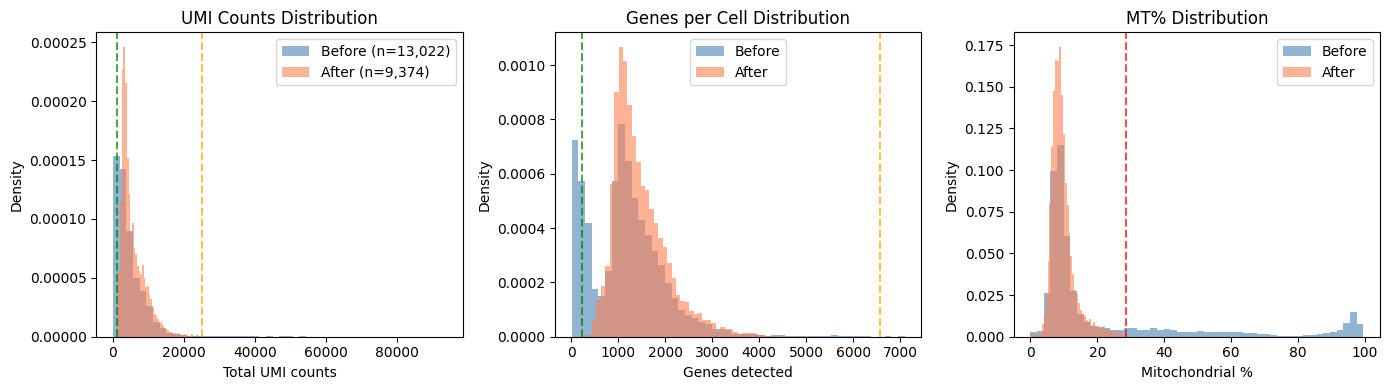


Metric                             Before           After          Change
Number of cells                    13,022           9,374          -3,648
Median UMI/cell                     3,519           4,465
Median genes/cell                   1,127           1,325
Median MT%                           10.1             8.9
Cells retained                                      72.0%


In [16]:
# Visualize QC: Before vs After filtering (overlaid distributions)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Filter prefilter data to valid range for fair comparison (same as interactive plot)
prefilter_valid = (
    ~np.isnan(prefilter_counts) & 
    ~np.isnan(prefilter_genes) & 
    ~np.isnan(prefilter_mt) &
    (prefilter_counts >= 100)
)

# Colors
before_color = 'steelblue'
after_color = 'coral'
alpha = 0.6

# Plot 1: UMI counts
axes[0].hist(prefilter_counts[prefilter_valid], bins=50, alpha=alpha, color=before_color, 
             label=f'Before (n={prefilter_valid.sum():,})', density=True)
axes[0].hist(rna_adata.obs['total_counts'], bins=50, alpha=alpha, color=after_color,
             label=f'After (n={rna_adata.n_obs:,})', density=True)
axes[0].set_xlabel('Total UMI counts')
axes[0].set_ylabel('Density')
axes[0].set_title('UMI Counts Distribution')
axes[0].legend()
axes[0].axvline(x=MIN_COUNTS, color='green', linestyle='--', alpha=0.7, label=f'Min: {MIN_COUNTS}')
axes[0].axvline(x=MAX_COUNTS, color='orange', linestyle='--', alpha=0.7, label=f'Max: {MAX_COUNTS}')

# Plot 2: Genes detected
axes[1].hist(prefilter_genes[prefilter_valid], bins=50, alpha=alpha, color=before_color,
             label='Before', density=True)
axes[1].hist(rna_adata.obs['n_genes_by_counts'], bins=50, alpha=alpha, color=after_color,
             label='After', density=True)
axes[1].set_xlabel('Genes detected')
axes[1].set_ylabel('Density')
axes[1].set_title('Genes per Cell Distribution')
axes[1].legend()
axes[1].axvline(x=MIN_GENES, color='green', linestyle='--', alpha=0.7)
axes[1].axvline(x=MAX_GENES, color='orange', linestyle='--', alpha=0.7)

# Plot 3: MT%
axes[2].hist(prefilter_mt[prefilter_valid], bins=50, alpha=alpha, color=before_color,
             label='Before', density=True)
axes[2].hist(rna_adata.obs['pct_counts_mt'], bins=50, alpha=alpha, color=after_color,
             label='After', density=True)
axes[2].set_xlabel('Mitochondrial %')
axes[2].set_ylabel('Density')
axes[2].set_title('MT% Distribution')
axes[2].legend()
axes[2].axvline(x=MAX_MT_PCT, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Summary statistics comparison
print(f"\n{'Metric':<25} {'Before':>15} {'After':>15} {'Change':>15}")
print("=" * 70)
print(f"{'Number of cells':<25} {prefilter_valid.sum():>15,} {rna_adata.n_obs:>15,} {rna_adata.n_obs - prefilter_valid.sum():>+15,}")
print(f"{'Median UMI/cell':<25} {np.median(prefilter_counts[prefilter_valid]):>15,.0f} {rna_adata.obs['total_counts'].median():>15,.0f}")
print(f"{'Median genes/cell':<25} {np.median(prefilter_genes[prefilter_valid]):>15,.0f} {rna_adata.obs['n_genes_by_counts'].median():>15,.0f}")
print(f"{'Median MT%':<25} {np.median(prefilter_mt[prefilter_valid]):>15.1f} {rna_adata.obs['pct_counts_mt'].median():>15.1f}")
print(f"{'Cells retained':<25} {'':<15} {100*rna_adata.n_obs/prefilter_valid.sum():>14.1f}%")


## Step 2b: Log-Normalized RNA for Visualization

Create a log-normalized copy of RNA data **for visualization only**.

**Why this is separate from integration:**
- Integration (Step 4+) uses detection-aware normalization to create comparable RNA/protein distributions
- Visualization needs standard log-normalization for interpretable expression levels in plots
- These serve different purposes and should not be conflated

In [17]:
# Log-normalized RNA for VISUALIZATION ONLY
# This is NOT used for integration - integration uses detection-aware normalized arrays

rna_adata_lognorm = rna_adata.copy()
sc.pp.normalize_total(rna_adata_lognorm, target_sum=1e4)
sc.pp.log1p(rna_adata_lognorm)

# Alias for convenience in downstream annotation cells
rna_adata_active = rna_adata_lognorm

print(f"Log-normalized RNA for visualization: {rna_adata_lognorm.shape}")
print(f"\nThis will be used for:")
print(f"  - Coloring UMAPs by gene expression")
print(f"  - Dotplots of marker genes")
print(f"  - Cell type annotation")
print(f"\nIntegration uses separate detection-aware normalized arrays (Step 4).")

Log-normalized RNA for visualization: (9374, 18626)

This will be used for:
  - Coloring UMAPs by gene expression
  - Dotplots of marker genes
  - Cell type annotation

Integration uses separate detection-aware normalized arrays (Step 4).


## Step 3: Build Protein-Gene Correspondence

Map CODEX protein markers to their corresponding gene names in the RNA data.

In [ ]:
# Load correspondence table
correspondence = pd.read_csv('data/protein_gene_conversion.csv', encoding='utf-8-sig')
print(f"Correspondence table: {correspondence.shape[0]} entries")
correspondence.head(10)

In [19]:
# Find matching features between CODEX markers and RNA genes
rna_protein_correspondence = []
unmatched_proteins = []

for marker in protein_adata.var_names:
    # Skip DAPI and ECAD (not useful for cell type matching)
    if marker in ['DAPI', 'ECAD']:
        continue
    
    # Look up in correspondence table
    matches = correspondence[correspondence['Protein name'].str.lower() == marker.lower()]
    
    if len(matches) == 0:
        # Try alternative names
        alt_names = {
            'CD3e': 'CD3',
            'FoxP3': 'FOXP3',
            'HLADR': 'HLA-DR',
            'Lyve1': 'LYVE1',
            'SMActin': 'aSMA',
            'CollagenIV': 'collagen IV',
        }
        alt_marker = alt_names.get(marker, marker)
        matches = correspondence[correspondence['Protein name'].str.lower() == alt_marker.lower()]
    
    if len(matches) > 0:
        rna_names_str = matches.iloc[0]['RNA name']
        if 'Ignore' in str(rna_names_str):
            unmatched_proteins.append((marker, 'Ignored'))
            continue
        
        # Try each RNA name option
        found = False
        for rna_name in str(rna_names_str).split('/'):
            if rna_name in rna_adata.var_names:
                rna_protein_correspondence.append([rna_name, marker])
                found = True
                break
        if not found:
            unmatched_proteins.append((marker, rna_names_str))
    else:
        unmatched_proteins.append((marker, 'Not in table'))

rna_protein_correspondence = np.array(rna_protein_correspondence)
print(f"Found {len(rna_protein_correspondence)} protein-gene pairs")

if unmatched_proteins:
    print(f"\nUnmatched proteins ({len(unmatched_proteins)}):")
    for prot, reason in unmatched_proteins:
        print(f"  {prot}: {reason}")

Found 24 protein-gene pairs


In [20]:
# Remove duplicates (same RNA mapping to multiple proteins)
# Keep first occurrence
seen_rna = set()
unique_pairs = []
for rna, prot in rna_protein_correspondence:
    if rna not in seen_rna:
        seen_rna.add(rna)
        unique_pairs.append([rna, prot])
    else:
        print(f"Removing duplicate RNA mapping: {rna} -> {prot}")

rna_protein_correspondence = np.array(unique_pairs)
print(f"\nFinal correspondence: {len(rna_protein_correspondence)} pairs")

print("\nMatched features:")
for rna, prot in rna_protein_correspondence:
    print(f"  {rna:15} <-> {prot}")

Removing duplicate RNA mapping: PTPRC -> CD45RO

Final correspondence: 23 pairs

Matched features:
  CD1C            <-> CD1c
  CD3E            <-> CD3e
  CD4             <-> CD4
  CD8A            <-> CD8
  ITGAX           <-> CD11c
  FUT4            <-> CD15
  MS4A1           <-> CD20
  CR2             <-> CD21
  PECAM1          <-> CD31
  CD34            <-> CD34
  CR1             <-> CD35
  CD44            <-> CD44
  PTPRC           <-> CD45
  CD68            <-> CD68
  LAMP1           <-> CD107a
  CD163           <-> CD163
  COL4A1          <-> CollagenIV
  FOXP3           <-> FoxP3
  HLA-DRA         <-> HLADR
  MKI67           <-> Ki67
  LYVE1           <-> Lyve1
  ACTA2           <-> SMActin
  VIM             <-> Vimentin


## Step 4: Prepare Arrays for Integration

Extract and normalize:
- **Shared arrays**: Corresponding protein/gene features (used for initial matching)
- **Active arrays**: All features (used for refinement)

In [21]:
# Extract shared features from FILTERED data
rna_shared_adata = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared_adata = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

print(f"rna_shared_adata: {rna_shared_adata.shape}")
print(f"protein_shared_adata: {protein_shared_adata.shape}")

rna_shared_adata: (9374, 23)
protein_shared_adata: (172181, 23)


In [22]:
# Normalize shared features - DETECTION-AWARE PIPELINE
# 
# Key insight: RNA (~9K cells) and Protein (~170K cells) have different cell counts.
# This causes the SAME biological "zero" to get different quantile values after
# rank normalization because the proportion of zeros differs.
#
# Solution: Detection-aware normalization
# 1. Transform each modality appropriately (log1p for RNA, arcsinh for protein)
# 2. For each feature, normalize NON-ZERO values separately to [0, 1] range
# 3. Set all zeros to a consistent negative value (e.g., -1 or the min of non-zeros)
# 4. This ensures zeros are treated equivalently regardless of how many exist

from scipy.stats import rankdata

# Store raw values before normalization
rna_shared_raw = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared_raw):
    rna_shared_raw = rna_shared_raw.toarray()
protein_shared_raw = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared_raw):
    protein_shared_raw = protein_shared_raw.toarray()

print("=" * 70)
print("DETECTION-AWARE NORMALIZATION PIPELINE")
print("=" * 70)
print(f"\nCell counts: RNA = {rna_shared_raw.shape[0]:,}, Protein = {protein_shared_raw.shape[0]:,}")
print("\nProblem: Different cell counts cause different zero proportions,")
print("         leading to misaligned distributions after standard normalization.")
print("\nSolution: Normalize non-zero values separately, treat zeros consistently.")

# ============================================================
# STEP 1: MODALITY-SPECIFIC TRANSFORMATIONS
# ============================================================

print("\n" + "="*70)
print("STEP 1: Modality-specific transformations")
print("="*70)

# --- RNA: Standard scanpy pipeline ---
print("\nRNA transformation:")
print(f"  Raw - shape: {rna_shared_raw.shape}")
print(f"       mean: {rna_shared_raw.mean():.3f}, zeros: {(rna_shared_raw == 0).mean()*100:.1f}%")

# Library size normalization
sc.pp.normalize_total(rna_shared_adata, target_sum=1e4)
rna_after_norm = rna_shared_adata.X.copy()
if sparse.issparse(rna_after_norm):
    rna_after_norm = rna_after_norm.toarray()

# Log1p transformation
sc.pp.log1p(rna_shared_adata)
rna_after_log = rna_shared_adata.X.copy()
if sparse.issparse(rna_after_log):
    rna_after_log = rna_after_log.toarray()
print(f"  After normalize_total + log1p - mean: {rna_after_log.mean():.3f}")

# --- Protein: Arcsinh transformation (standard for cytometry) ---
print("\nProtein transformation (arcsinh with cofactor=5):")
print(f"  Raw - shape: {protein_shared_raw.shape}")
print(f"       mean: {protein_shared_raw.mean():.3f}, zeros: {(protein_shared_raw == 0).mean()*100:.1f}%")

COFACTOR = 5
protein_after_arcsinh = np.arcsinh(protein_shared_raw / COFACTOR)
print(f"  After arcsinh(x/{COFACTOR}) - mean: {protein_after_arcsinh.mean():.3f}")

# ============================================================
# STEP 2: DETECTION-AWARE NORMALIZATION (per feature)
# ============================================================

print("\n" + "="*70)
print("STEP 2: Detection-aware normalization (per feature)")
print("="*70)
print("\nFor each feature:")
print("  1. Identify non-zero (detected) values")
print("  2. Rank-normalize only the non-zero values to (0, 1) range")  
print("  3. Map ranks to standard normal quantiles")
print("  4. Set zeros to a fixed negative value (below all non-zero values)")
print("\nThis ensures 'not detected' means the same thing in both modalities.")

from scipy.stats import norm

def detection_aware_normalize(X, zero_value=-2.0):
    """
    Detection-aware normalization:
    - Non-zero values are rank-normalized to standard normal
    - Zero values are set to a consistent negative value
    
    This handles the case where modalities have different numbers of cells,
    causing different proportions of zeros even for the same detection rate.
    
    Parameters:
    -----------
    X : array (n_cells, n_features)
    zero_value : float
        Value to assign to zeros (should be below typical non-zero range)
    
    Returns:
    --------
    X_norm : normalized array
    """
    X_norm = np.zeros_like(X, dtype=np.float64)
    
    for j in range(X.shape[1]):
        col = X[:, j]
        nonzero_mask = col > 0
        n_nonzero = nonzero_mask.sum()
        
        if n_nonzero > 1:
            # Rank only the non-zero values
            nonzero_vals = col[nonzero_mask]
            ranks = rankdata(nonzero_vals, method='average')
            # Convert to quantiles (0, 1), avoiding extremes
            quantiles = (ranks - 0.5) / n_nonzero
            # Map to standard normal (will be positive since quantiles > 0.5 for higher ranks)
            # Shift so median non-zero is at 0
            normal_vals = norm.ppf(quantiles)
            X_norm[nonzero_mask, j] = normal_vals
        elif n_nonzero == 1:
            # Single non-zero value: set to 0 (median)
            X_norm[nonzero_mask, j] = 0.0
        
        # Set zeros to consistent negative value
        X_norm[~nonzero_mask, j] = zero_value
    
    return X_norm

# Apply detection-aware normalization
ZERO_VALUE = -2.5  # Below typical non-zero range after normalization
rna_shared_normalized = detection_aware_normalize(rna_after_log, zero_value=ZERO_VALUE)
protein_shared_normalized = detection_aware_normalize(protein_after_arcsinh, zero_value=ZERO_VALUE)

print(f"\nZero value set to: {ZERO_VALUE}")

# ============================================================
# STORE RESULTS
# ============================================================

# Store intermediate results for visualization
rna_shared_after_log = rna_after_log
protein_shared_after_arcsinh = protein_after_arcsinh

# Final normalized arrays
rna_shared_after_scale = rna_shared_normalized
protein_shared_after = protein_shared_normalized

# Store means/stds of non-zero values (for reference)
rna_means = np.array([rna_after_log[rna_after_log[:, j] > 0, j].mean() if (rna_after_log[:, j] > 0).any() else 0 
                      for j in range(rna_after_log.shape[1])])
rna_stds = np.array([rna_after_log[rna_after_log[:, j] > 0, j].std() if (rna_after_log[:, j] > 0).any() else 1 
                     for j in range(rna_after_log.shape[1])])
prot_means = np.array([protein_after_arcsinh[protein_after_arcsinh[:, j] > 0, j].mean() if (protein_after_arcsinh[:, j] > 0).any() else 0 
                       for j in range(protein_after_arcsinh.shape[1])])
prot_stds = np.array([protein_after_arcsinh[protein_after_arcsinh[:, j] > 0, j].std() if (protein_after_arcsinh[:, j] > 0).any() else 1 
                      for j in range(protein_after_arcsinh.shape[1])])

# Update AnnData objects
rna_shared_adata.X = rna_shared_normalized.astype(np.float32)
protein_shared_adata.X = protein_shared_normalized.astype(np.float32)

# ============================================================
# VERIFICATION
# ============================================================
print("\n" + "="*70)
print("VERIFICATION")
print("="*70)

# Check non-zero distributions
for name, data in [("RNA", rna_shared_normalized), ("Protein", protein_shared_normalized)]:
    nonzero_vals = data[data > ZERO_VALUE + 0.1]  # Exclude the zero-value spike
    print(f"\n{name} (non-zero values only):")
    print(f"  N values: {len(nonzero_vals):,}")
    print(f"  Mean: {nonzero_vals.mean():.4f}")
    print(f"  Std:  {nonzero_vals.std():.4f}")
    print(f"  Range: [{nonzero_vals.min():.2f}, {nonzero_vals.max():.2f}]")

# Per-feature detection rates
print("\n" + "-"*70)
print("Per-feature detection rates:")
print(f"{'Feature':<12} {'RNA %':>8} {'Prot %':>8} {'Difference':>12}")
print("-"*42)
for i, (rna_name, prot_name) in enumerate(rna_protein_correspondence):
    rna_det = (rna_shared_raw[:, i] > 0).mean() * 100
    prot_det = (protein_shared_raw[:, i] > 0).mean() * 100
    print(f"{rna_name[:11]:<12} {rna_det:>7.1f}% {prot_det:>7.1f}% {prot_det - rna_det:>+11.1f}%")

print("\n" + "="*70)
print("SUCCESS: Detection-aware normalization complete!")
print("- Non-zero values are rank-normalized (comparable distributions)")
print("- Zero values are set to consistent value (no cell-count bias)")
print("="*70)


DETECTION-AWARE NORMALIZATION PIPELINE

Cell counts: RNA = 9,374, Protein = 172,181

Problem: Different cell counts cause different zero proportions,
         leading to misaligned distributions after standard normalization.

Solution: Normalize non-zero values separately, treat zeros consistently.

STEP 1: Modality-specific transformations

RNA transformation:
  Raw - shape: (9374, 23)
       mean: 1.536, zeros: 79.0%
  After normalize_total + log1p - mean: 1.455

Protein transformation (arcsinh with cofactor=5):
  Raw - shape: (172181, 23)
       mean: 8.679, zeros: 49.7%
  After arcsinh(x/5) - mean: 0.668

STEP 2: Detection-aware normalization (per feature)

For each feature:
  1. Identify non-zero (detected) values
  2. Rank-normalize only the non-zero values to (0, 1) range
  3. Map ranks to standard normal quantiles
  4. Set zeros to a fixed negative value (below all non-zero values)

This ensures 'not detected' means the same thing in both modalities.

Zero value set to: -2.5

V

PROTEIN BACKGROUND DETECTION (using Cell Median)

Analyzing 23 shared protein features...
Using Cell Median to classify background cells (Median=0 → not detected)

Protein          Median=0     Median>0   % Detected
--------------------------------------------------
CD1c              170,616        1,565         0.9%
CD3e              148,725       23,456        13.6%
CD4               161,012       11,169         6.5%
CD8               148,328       23,853        13.9%
CD11c             170,152        2,029         1.2%
CD15              132,858       39,323        22.8%
CD20              125,687       46,494        27.0%
CD21              161,966       10,215         5.9%
CD31              127,016       45,165        26.2%
CD34              161,900       10,281         6.0%
CD35              135,527       36,654        21.3%
CD44              132,817       39,364        22.9%
CD45              146,200       25,981        15.1%
CD68              111,780       60,401        35.1%
CD107

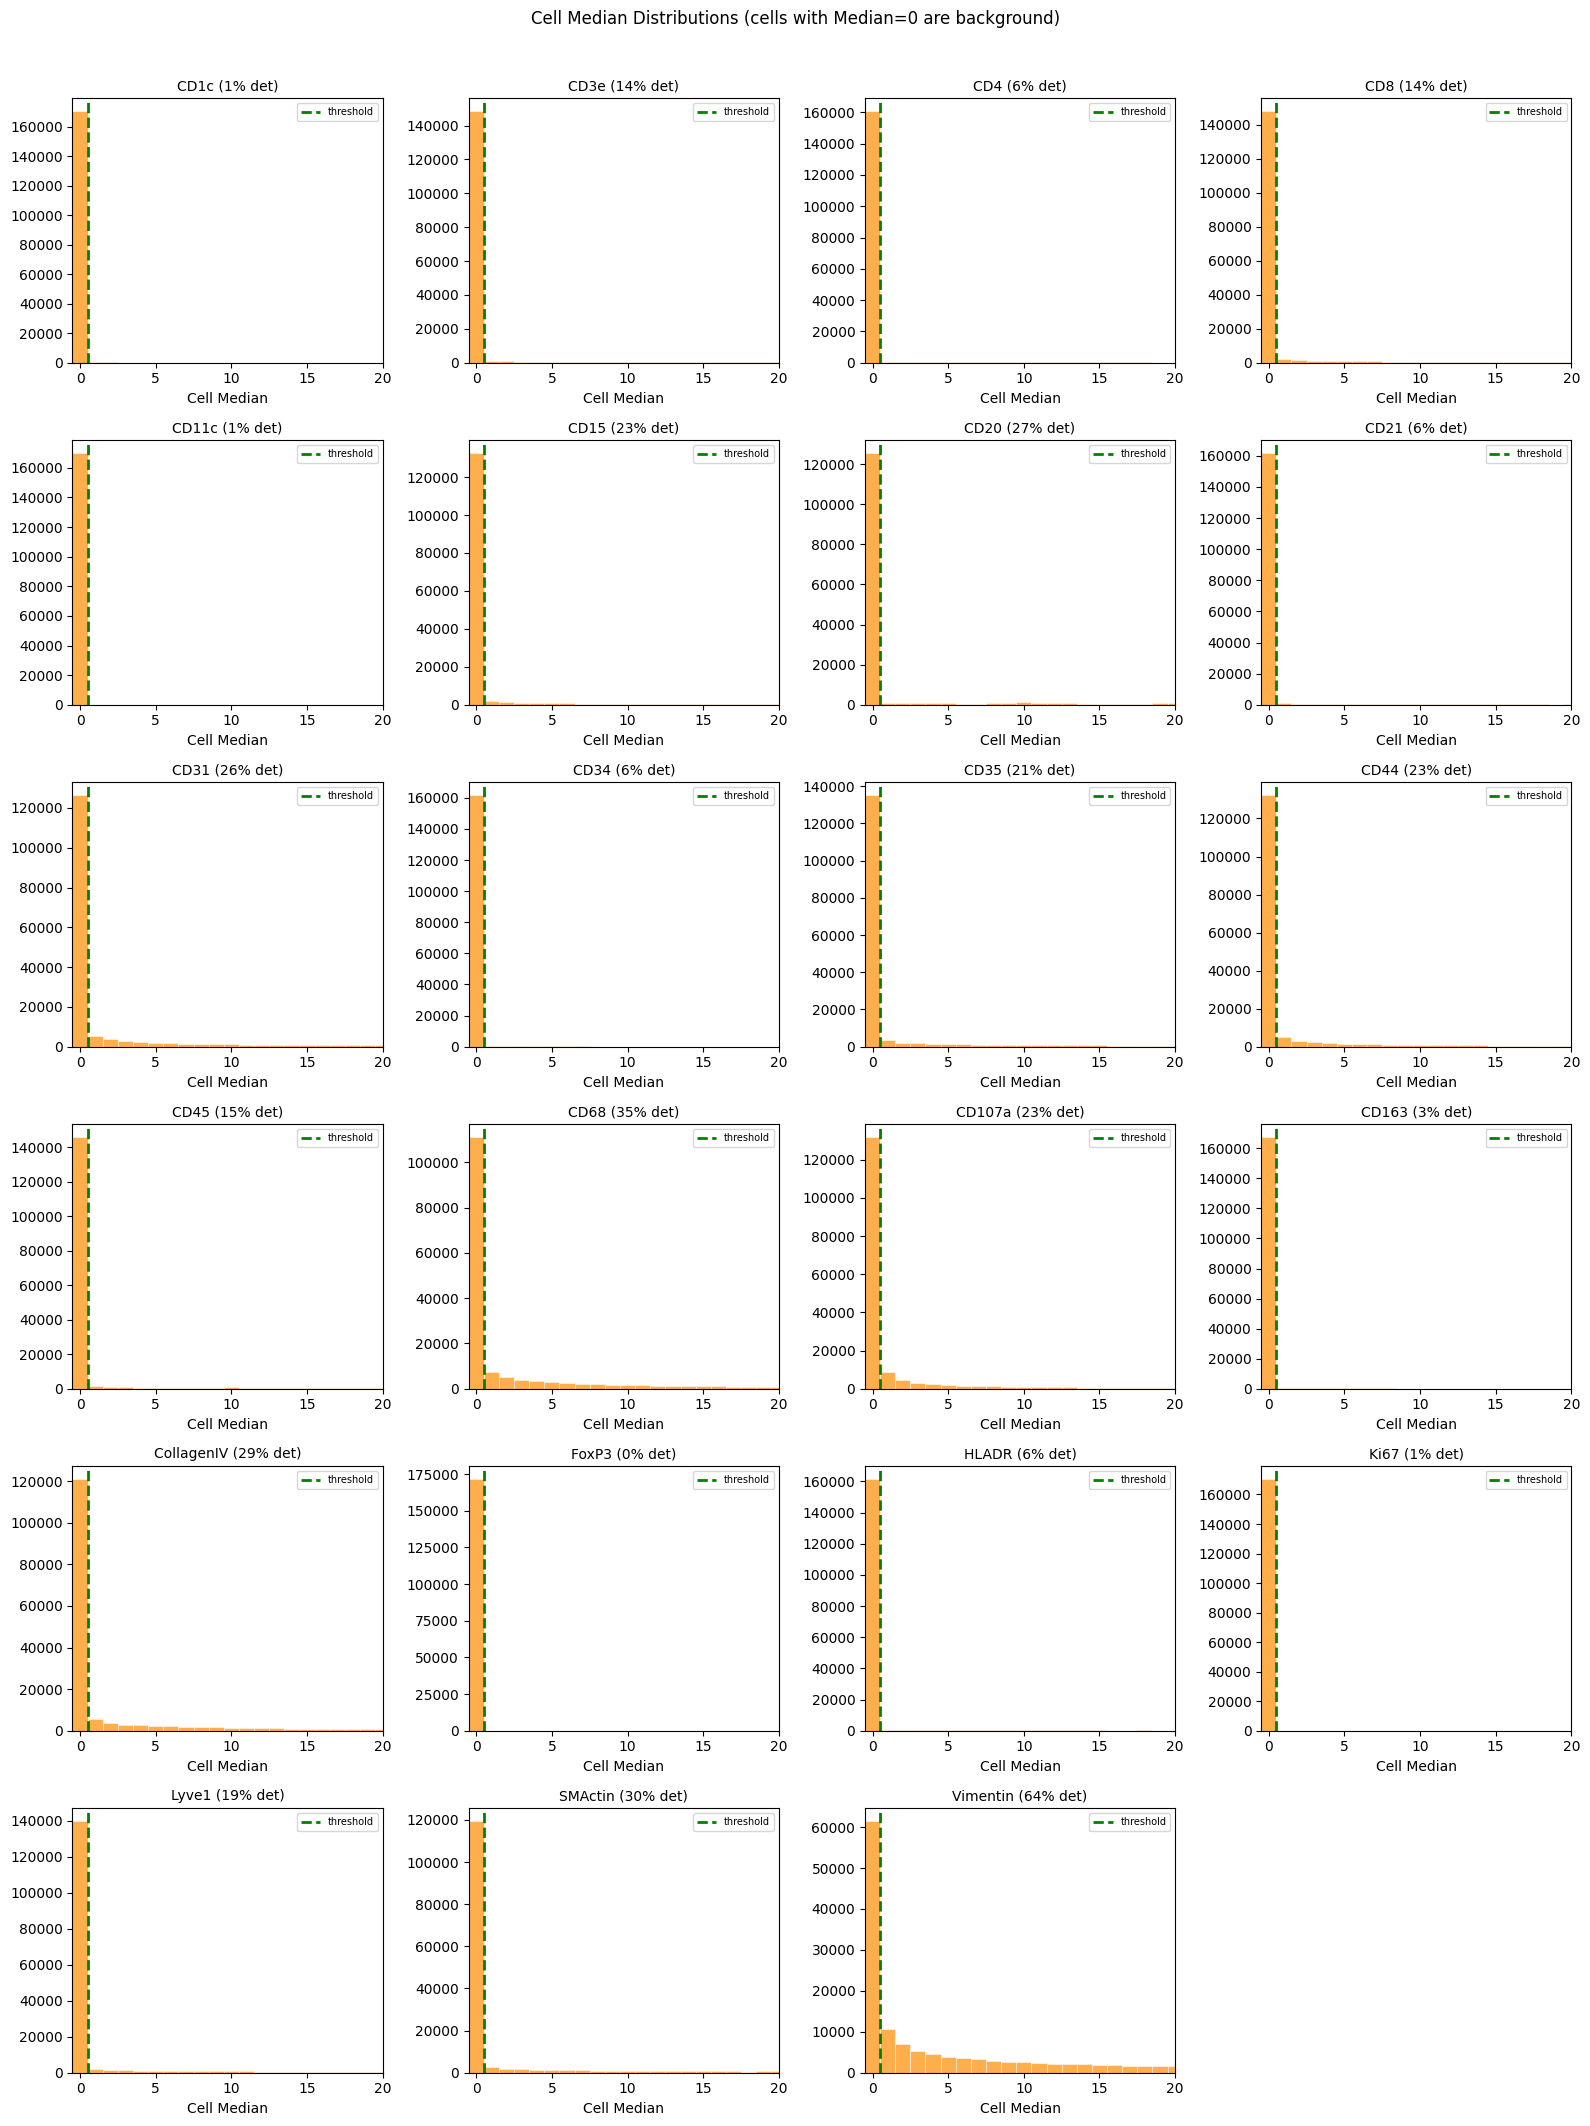


SUMMARY

Background criterion: Cell Median ≤ 0.5

This aligns with histogram matching: background pixels → 0, signal pixels → higher values
A cell with Median=0 has majority background pixels, even if Mean > 0


In [23]:
# Diagnostic: Background detection using Cell Median
# After histogram matching, background pixels cluster at 0
# If a cell's MEDIAN pixel value is 0, the cell is background (not detected)

print("="*70)
print("PROTEIN BACKGROUND DETECTION (using Cell Median)")
print("="*70)

protein_names = list(rna_protein_correspondence[:, 1])
n_features = len(protein_names)

# We need the median values from the original CODEX dataframe
# Build mapping from protein name to column
protein_to_median_col = {}
for prot in protein_names:
    # Find the matching column in codex_df
    for col in codex_df.columns:
        if prot in col and 'Cell:' in col and 'Median' in col:
            protein_to_median_col[prot] = col
            break

print(f"\nAnalyzing {n_features} shared protein features...")
print(f"Using Cell Median to classify background cells (Median=0 → not detected)")

# Store detection info
detection_stats = {}

# Create figure: each protein gets a panel with Mean and Median histograms
plots_per_row = 4
n_feature_rows = int(np.ceil(n_features / plots_per_row))
fig, axes = plt.subplots(n_feature_rows, plots_per_row, figsize=(16, 3.5*n_feature_rows))
if n_feature_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

print(f"\n{'Protein':<12} {'Median=0':>12} {'Median>0':>12} {'% Detected':>12}")
print("-"*50)

for i in range(n_features):
    prot_name = protein_names[i]
    ax = axes[i]
    
    if prot_name in protein_to_median_col:
        median_col = protein_to_median_col[prot_name]
        median_vals = codex_df[median_col].values
        
        # Get corresponding mean column for comparison
        mean_col = median_col.replace('Median', 'Mean')
        mean_vals = codex_df[mean_col].values if mean_col in codex_df.columns else None
        
        # Classification: Median=0 is background
        is_background = median_vals <= 0.5  # Using 0.5 to catch floating point 0s
        is_detected = ~is_background
        
        n_background = is_background.sum()
        n_detected = is_detected.sum()
        pct_detected = 100 * n_detected / len(median_vals)
        
        detection_stats[prot_name] = {
            'n_background': n_background,
            'n_detected': n_detected,
            'pct_detected': pct_detected
        }
        
        print(f"{prot_name:<12} {n_background:>12,} {n_detected:>12,} {pct_detected:>11.1f}%")
        
        # Plot: Histogram of Median values zoomed to 0-20
        median_zoomed = median_vals[median_vals <= 20]
        ax.hist(median_zoomed, bins=np.arange(-0.5, 21.5, 1), alpha=0.7, 
                color='darkorange', edgecolor='white', linewidth=0.5)
        ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='threshold')
        ax.set_title(f'{prot_name} ({pct_detected:.0f}% det)', fontsize=10)
        ax.set_xlabel('Cell Median')
        ax.set_xlim(left=-0.5, right=20)
        ax.legend(fontsize=7)
    else:
        print(f"{prot_name:<12} {'column not found':>36}")
        ax.set_visible(False)

# Hide unused axes
for j in range(n_features, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Cell Median Distributions (cells with Median=0 are background)', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

# Summary
print(f"\n{'='*70}")
print("SUMMARY")
print("="*70)
print(f"\nBackground criterion: Cell Median ≤ 0.5")
print(f"\nThis aligns with histogram matching: background pixels → 0, signal pixels → higher values")
print(f"A cell with Median=0 has majority background pixels, even if Mean > 0")

Example feature: CD68 / CD68
  RNA detection: 24.2% (2,266 cells)
  Protein detection (Cell Median > 0): 35.1% (60,401 cells)


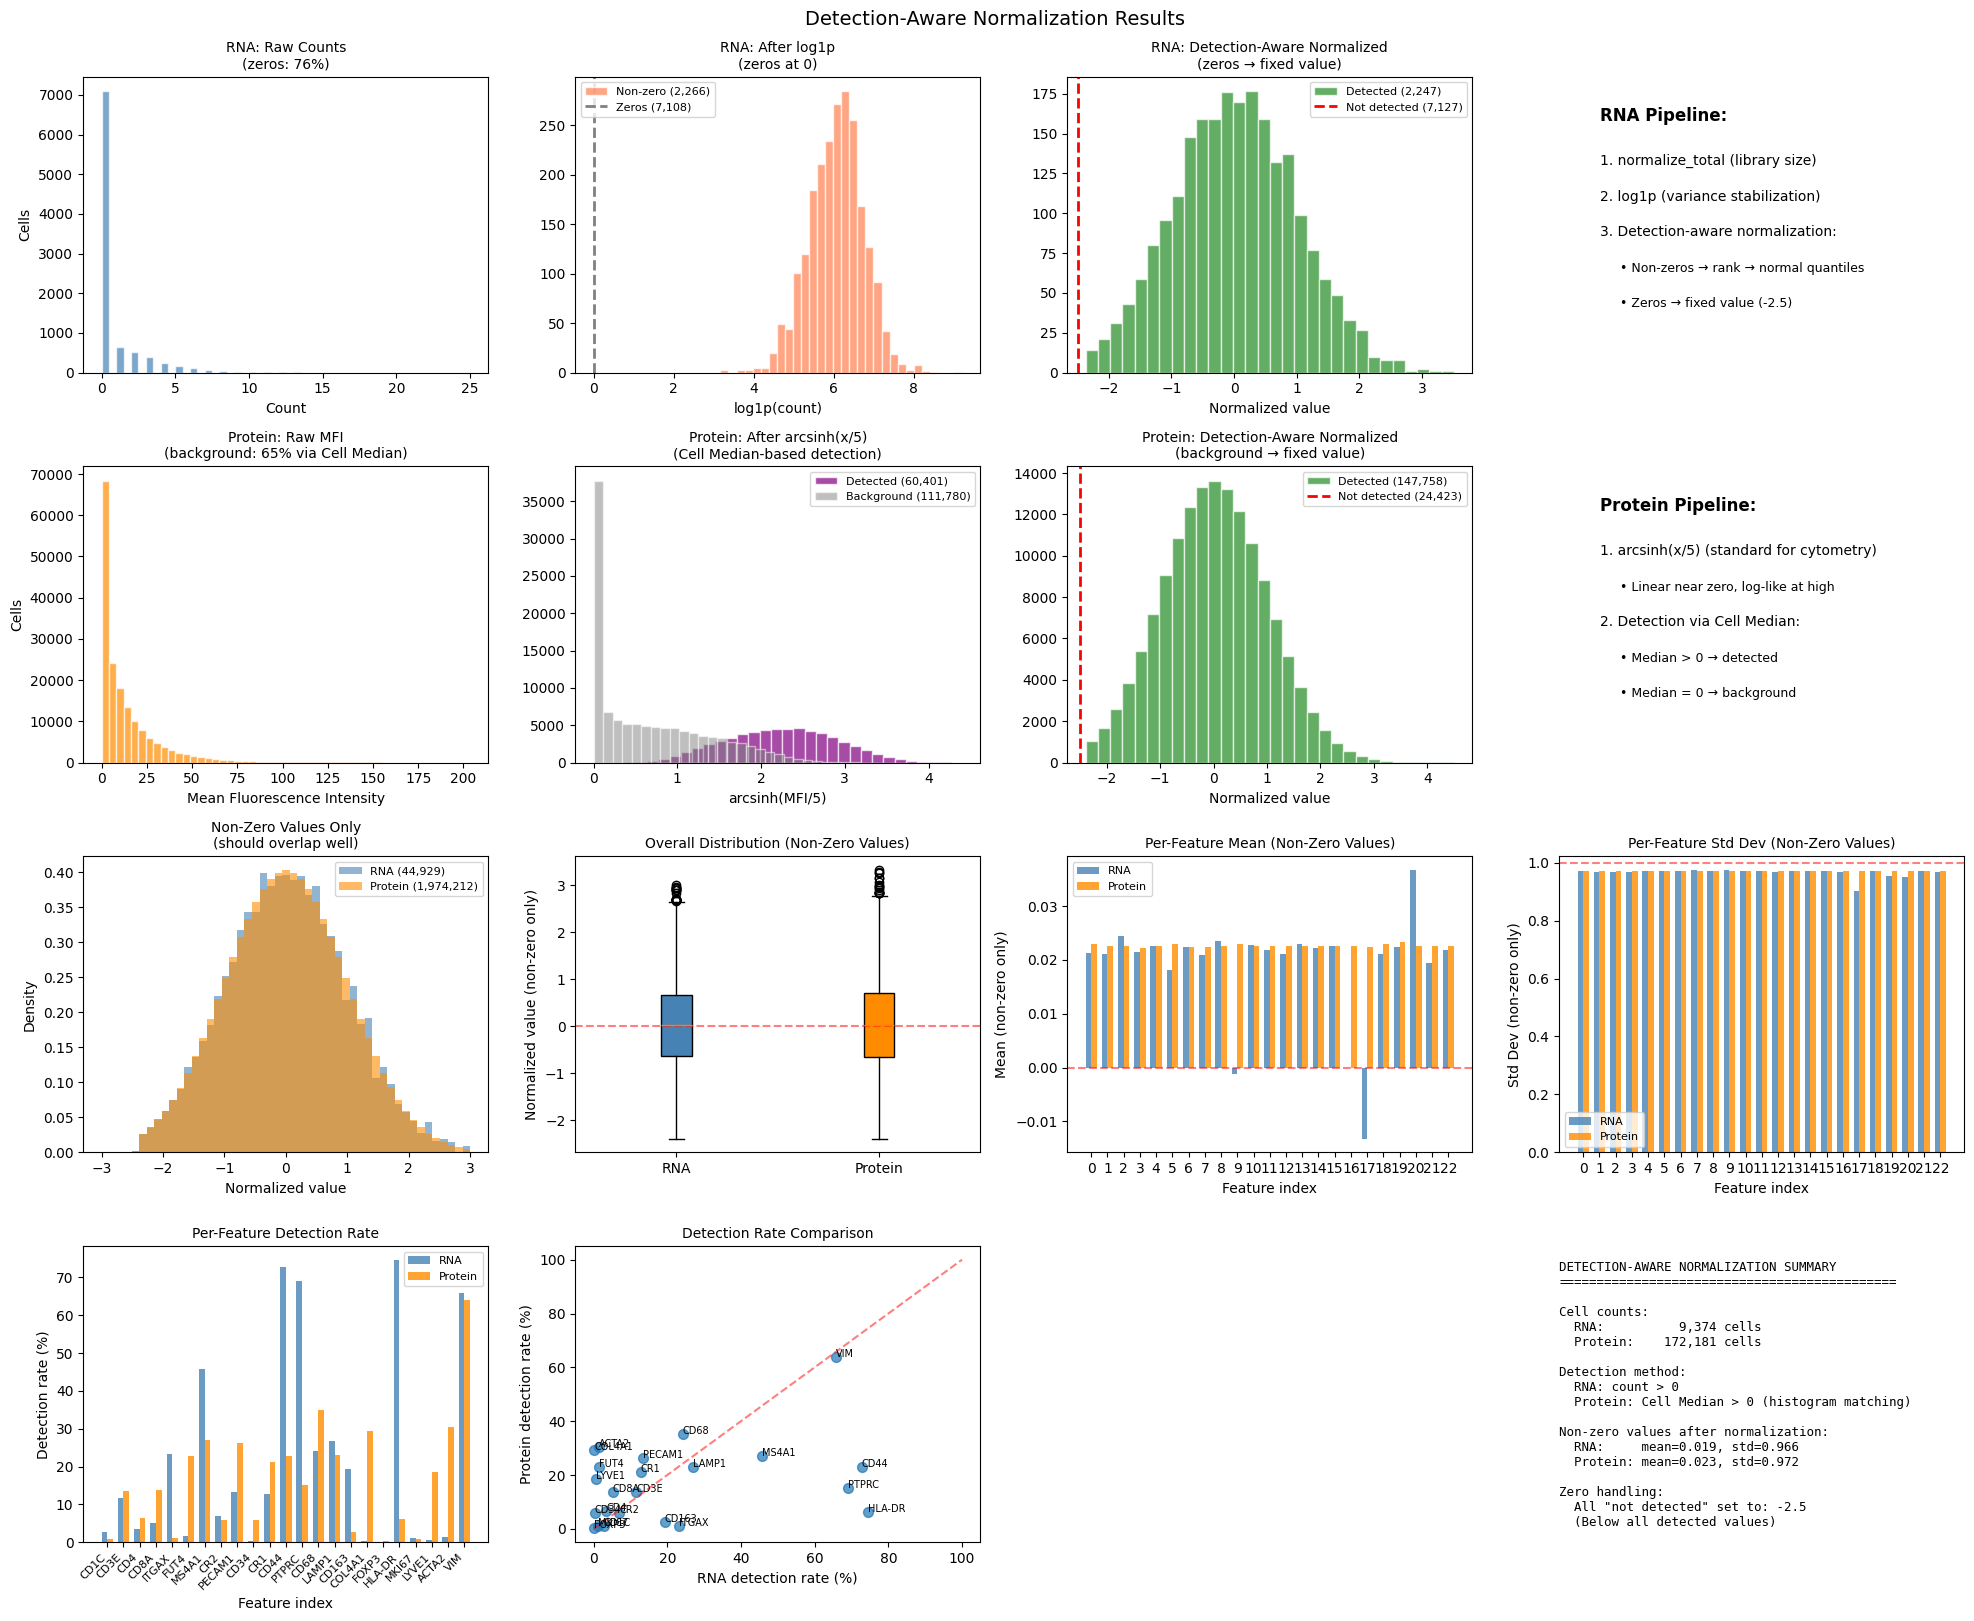


KEY INSIGHT:
RNA detection: count > 0
Protein detection: Cell Median > 0 (accounts for histogram matching)
This ensures 'not detected' is biologically meaningful in both modalities.


In [24]:
# Visualize DETECTION-AWARE normalization
# Updated to use Cell Median-based detection for protein data

fig, axes = plt.subplots(4, 4, figsize=(20, 16))

feature_names = list(rna_protein_correspondence[:, 0])
protein_names = list(rna_protein_correspondence[:, 1])
n_features = rna_shared_raw.shape[1]

# Define x_pos and width for bar charts
x_pos = np.arange(n_features)
width = 0.35

# Pick a feature with moderate expression
detection_rates_rna = [(rna_shared_raw[:, i] > 0).mean() for i in range(n_features)]
good_features = [i for i, d in enumerate(detection_rates_rna) if 0.2 < d < 0.8]
if good_features:
    best_feat_idx = good_features[len(good_features)//2]
else:
    best_feat_idx = np.argmax(detection_rates_rna)
feat_name = feature_names[best_feat_idx]
prot_name = protein_names[best_feat_idx]

# For protein, use Cell Median-based detection (from cell 26)
# Build protein detection rates from Cell Median
protein_to_median_col = {}
for prot in protein_names:
    for col in codex_df.columns:
        if prot in col and 'Cell:' in col and 'Median' in col:
            protein_to_median_col[prot] = col
            break

# Calculate detection rates: RNA uses >0, Protein uses Cell Median > 0.5
rna_det_rates = [(rna_shared_raw[:, i] > 0).mean() * 100 for i in range(n_features)]
prot_det_rates = []
for i, pname in enumerate(protein_names):
    if pname in protein_to_median_col:
        median_vals = codex_df[protein_to_median_col[pname]].values
        prot_det_rates.append((median_vals > 0.5).mean() * 100)
    else:
        # Fallback to raw >0
        prot_det_rates.append((protein_shared_raw[:, i] > 0).mean() * 100)

rna_det = rna_det_rates[best_feat_idx]
prot_det = prot_det_rates[best_feat_idx]

print(f"Example feature: {feat_name} / {prot_name}")
print(f"  RNA detection: {rna_det:.1f}% ({int(rna_det/100 * rna_shared_raw.shape[0]):,} cells)")
print(f"  Protein detection (Cell Median > 0): {prot_det:.1f}% ({int(prot_det/100 * protein_shared_raw.shape[0]):,} cells)")

ZERO_VALUE = -2.5  # Must match value used in normalization

# ============================================================
# Row 1: RNA transformation pipeline
# ============================================================
ax = axes[0, 0]
raw_vals = rna_shared_raw[:, best_feat_idx]
ax.hist(raw_vals, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
ax.set_title(f'RNA: Raw Counts\n(zeros: {(raw_vals==0).mean()*100:.0f}%)', fontsize=10)
ax.set_xlabel('Count')
ax.set_ylabel('Cells')

ax = axes[0, 1]
log_vals = rna_shared_after_log[:, best_feat_idx]
zeros = log_vals == 0
nonzeros = ~zeros
ax.hist(log_vals[nonzeros], bins=30, alpha=0.7, color='coral', edgecolor='white', label=f'Non-zero ({nonzeros.sum():,})')
if zeros.sum() > 0:
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=2, label=f'Zeros ({zeros.sum():,})')
ax.set_title('RNA: After log1p\n(zeros at 0)', fontsize=10)
ax.set_xlabel('log1p(count)')
ax.legend(fontsize=8)

ax = axes[0, 2]
norm_vals = rna_shared_after_scale[:, best_feat_idx]
nonzero_mask = norm_vals > ZERO_VALUE + 0.1
ax.hist(norm_vals[nonzero_mask], bins=30, alpha=0.7, color='forestgreen', edgecolor='white', 
        label=f'Detected ({nonzero_mask.sum():,})')
ax.axvline(x=ZERO_VALUE, color='red', linestyle='--', linewidth=2, 
           label=f'Not detected ({(~nonzero_mask).sum():,})')
ax.set_title('RNA: Detection-Aware Normalized\n(zeros → fixed value)', fontsize=10)
ax.set_xlabel('Normalized value')
ax.legend(fontsize=8)

ax = axes[0, 3]
ax.axis('off')
ax.text(0.1, 0.85, 'RNA Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.70, '1. normalize_total (library size)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.58, '2. log1p (variance stabilization)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.46, '3. Detection-aware normalization:', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.34, '• Non-zeros → rank → normal quantiles', fontsize=9, transform=ax.transAxes)
ax.text(0.15, 0.22, f'• Zeros → fixed value ({ZERO_VALUE})', fontsize=9, transform=ax.transAxes)

# ============================================================
# Row 2: Protein transformation pipeline
# ============================================================
ax = axes[1, 0]
raw_vals = protein_shared_raw[:, best_feat_idx]
# Show Cell Median-based detection
if prot_name in protein_to_median_col:
    median_vals = codex_df[protein_to_median_col[prot_name]].values
    is_bg = median_vals <= 0.5
    pct_bg = is_bg.mean() * 100
else:
    pct_bg = (raw_vals == 0).mean() * 100
ax.hist(raw_vals, bins=50, alpha=0.7, color='darkorange', edgecolor='white')
ax.set_title(f'Protein: Raw MFI\n(background: {pct_bg:.0f}% via Cell Median)', fontsize=10)
ax.set_xlabel('Mean Fluorescence Intensity')
ax.set_ylabel('Cells')

ax = axes[1, 1]
arcsinh_vals = protein_shared_after_arcsinh[:, best_feat_idx]
# Use Cell Median for zero classification
if prot_name in protein_to_median_col:
    median_vals = codex_df[protein_to_median_col[prot_name]].values
    zeros = median_vals <= 0.5
else:
    zeros = protein_shared_raw[:, best_feat_idx] == 0
nonzeros = ~zeros
ax.hist(arcsinh_vals[nonzeros], bins=30, alpha=0.7, color='purple', edgecolor='white', label=f'Detected ({nonzeros.sum():,})')
if zeros.sum() > 0:
    # Show background cells as a separate histogram
    ax.hist(arcsinh_vals[zeros], bins=30, alpha=0.5, color='gray', edgecolor='white', label=f'Background ({zeros.sum():,})')
ax.set_title('Protein: After arcsinh(x/5)\n(Cell Median-based detection)', fontsize=10)
ax.set_xlabel('arcsinh(MFI/5)')
ax.legend(fontsize=8)

ax = axes[1, 2]
norm_vals = protein_shared_after[:, best_feat_idx]
nonzero_mask = norm_vals > ZERO_VALUE + 0.1
ax.hist(norm_vals[nonzero_mask], bins=30, alpha=0.7, color='forestgreen', edgecolor='white',
        label=f'Detected ({nonzero_mask.sum():,})')
ax.axvline(x=ZERO_VALUE, color='red', linestyle='--', linewidth=2,
           label=f'Not detected ({(~nonzero_mask).sum():,})')
ax.set_title('Protein: Detection-Aware Normalized\n(background → fixed value)', fontsize=10)
ax.set_xlabel('Normalized value')
ax.legend(fontsize=8)

ax = axes[1, 3]
ax.axis('off')
ax.text(0.1, 0.85, 'Protein Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.70, '1. arcsinh(x/5) (standard for cytometry)', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.58, '• Linear near zero, log-like at high', fontsize=9, transform=ax.transAxes)
ax.text(0.1, 0.46, '2. Detection via Cell Median:', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.34, '• Median > 0 → detected', fontsize=9, transform=ax.transAxes)
ax.text(0.15, 0.22, '• Median = 0 → background', fontsize=9, transform=ax.transAxes)

# ============================================================
# Row 3: Distribution comparison - NON-ZERO VALUES ONLY
# ============================================================

# Get non-zero values only
rna_nonzero = rna_shared_after_scale[rna_shared_after_scale > ZERO_VALUE + 0.1]
prot_nonzero = protein_shared_after[protein_shared_after > ZERO_VALUE + 0.1]

ax = axes[2, 0]
bins = np.linspace(-3, 3, 50)
ax.hist(rna_nonzero, bins=bins, alpha=0.6, density=True, label=f'RNA ({len(rna_nonzero):,})', color='steelblue')
ax.hist(prot_nonzero, bins=bins, alpha=0.6, density=True, label=f'Protein ({len(prot_nonzero):,})', color='darkorange')
ax.set_title('Non-Zero Values Only\n(should overlap well)', fontsize=10)
ax.set_xlabel('Normalized value')
ax.set_ylabel('Density')
ax.legend(fontsize=8)

# Box plot of non-zero values
ax = axes[2, 1]
rna_sample = rna_nonzero[::max(1, len(rna_nonzero)//5000)]
prot_sample = prot_nonzero[::max(1, len(prot_nonzero)//5000)]
bp = ax.boxplot([rna_sample, prot_sample], labels=['RNA', 'Protein'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('darkorange')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Normalized value (non-zero only)')
ax.set_title('Overall Distribution (Non-Zero Values)', fontsize=10)

# Per-feature mean of NON-ZERO values (should be ~0)
ax = axes[2, 2]
rna_means_nz = []
prot_means_nz = []
for i in range(n_features):
    rna_nz = rna_shared_after_scale[:, i][rna_shared_after_scale[:, i] > ZERO_VALUE + 0.1]
    prot_nz = protein_shared_after[:, i][protein_shared_after[:, i] > ZERO_VALUE + 0.1]
    rna_means_nz.append(rna_nz.mean() if len(rna_nz) > 0 else 0)
    prot_means_nz.append(prot_nz.mean() if len(prot_nz) > 0 else 0)

ax.bar(x_pos - width/2, rna_means_nz, width, label='RNA', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_means_nz, width, label='Protein', alpha=0.8, color='darkorange')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Feature index')
ax.set_ylabel('Mean (non-zero only)')
ax.set_title('Per-Feature Mean (Non-Zero Values)', fontsize=10)
ax.legend(fontsize=8)
ax.set_xticks(x_pos)

# Per-feature std of NON-ZERO values (should be ~1)
ax = axes[2, 3]
rna_stds_nz = []
prot_stds_nz = []
for i in range(n_features):
    rna_nz = rna_shared_after_scale[:, i][rna_shared_after_scale[:, i] > ZERO_VALUE + 0.1]
    prot_nz = protein_shared_after[:, i][protein_shared_after[:, i] > ZERO_VALUE + 0.1]
    rna_stds_nz.append(rna_nz.std() if len(rna_nz) > 1 else 0)
    prot_stds_nz.append(prot_nz.std() if len(prot_nz) > 1 else 0)

ax.bar(x_pos - width/2, rna_stds_nz, width, label='RNA', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_stds_nz, width, label='Protein', alpha=0.8, color='darkorange')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Feature index')
ax.set_ylabel('Std Dev (non-zero only)')
ax.set_title('Per-Feature Std Dev (Non-Zero Values)', fontsize=10)
ax.legend(fontsize=8)
ax.set_xticks(x_pos)

# ============================================================
# Row 4: Detection rates and summary
# ============================================================

# Detection rate comparison
ax = axes[3, 0]
ax.bar(x_pos - width/2, rna_det_rates, width, label='RNA', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_det_rates, width, label='Protein', alpha=0.8, color='darkorange')
ax.set_xlabel('Feature index')
ax.set_ylabel('Detection rate (%)')
ax.set_title('Per-Feature Detection Rate', fontsize=10)
ax.legend(fontsize=8)
ax.set_xticks(x_pos)
ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=8)

# Detection rate scatter
ax = axes[3, 1]
ax.scatter(rna_det_rates, prot_det_rates, s=50, alpha=0.7)
for i, fname in enumerate(feature_names):
    ax.annotate(fname[:6], (rna_det_rates[i], prot_det_rates[i]), fontsize=7)
ax.plot([0, 100], [0, 100], 'r--', alpha=0.5)
ax.set_xlabel('RNA detection rate (%)')
ax.set_ylabel('Protein detection rate (%)')
ax.set_title('Detection Rate Comparison', fontsize=10)

# Empty placeholder
ax = axes[3, 2]
ax.axis('off')

# Summary text
ax = axes[3, 3]
ax.axis('off')
summary = f"""DETECTION-AWARE NORMALIZATION SUMMARY
{"="*45}

Cell counts:
  RNA:     {rna_shared_raw.shape[0]:>10,} cells
  Protein: {protein_shared_raw.shape[0]:>10,} cells

Detection method:
  RNA: count > 0
  Protein: Cell Median > 0 (histogram matching)

Non-zero values after normalization:
  RNA:     mean={np.mean(rna_means_nz):.3f}, std={np.mean(rna_stds_nz):.3f}
  Protein: mean={np.mean(prot_means_nz):.3f}, std={np.mean(prot_stds_nz):.3f}

Zero handling:
  All "not detected" set to: {ZERO_VALUE}
  (Below all detected values)
"""
ax.text(0.0, 0.95, summary, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.suptitle('Detection-Aware Normalization Results', fontsize=14, y=1.01)
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("RNA detection: count > 0")
print("Protein detection: Cell Median > 0 (accounts for histogram matching)")
print("This ensures 'not detected' is biologically meaningful in both modalities.")

In [25]:
# Convert to numpy arrays
rna_shared = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared):
    rna_shared = rna_shared.toarray()
    
protein_shared = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared):
    protein_shared = protein_shared.toarray()

# Remove zero-variance features
rna_std = rna_shared.std(axis=0)
prot_std = protein_shared.std(axis=0)
valid_mask = (rna_std > 1e-6) & (prot_std > 1e-6)

if not valid_mask.all():
    print(f"Removing {(~valid_mask).sum()} zero-variance features")
    rna_shared = rna_shared[:, valid_mask]
    protein_shared = protein_shared[:, valid_mask]
    # Update correspondence
    rna_protein_correspondence = rna_protein_correspondence[valid_mask]

print(f"\nFinal shared arrays:")
print(f"  rna_shared: {rna_shared.shape}")
print(f"  protein_shared: {protein_shared.shape}")


Final shared arrays:
  rna_shared: (9374, 23)
  protein_shared: (172181, 23)


In [26]:
# Analyze shared feature quality
print("=" * 60)
print("SHARED FEATURE QUALITY ANALYSIS")
print("=" * 60)

# Get raw counts for analysis (before normalization)
rna_raw_shared = rna_adata[:, rna_protein_correspondence[:, 0]].X
if sparse.issparse(rna_raw_shared):
    rna_raw_shared = rna_raw_shared.toarray()

protein_raw_shared = protein_adata[:, rna_protein_correspondence[:, 1]].X
if sparse.issparse(protein_raw_shared):
    protein_raw_shared = protein_raw_shared.toarray()

# Calculate statistics for each feature
feature_stats = []
for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    rna_col = rna_raw_shared[:, i]
    prot_col = protein_raw_shared[:, i]
    
    # % cells expressing
    rna_pct_expressing = (rna_col > 0).sum() / len(rna_col) * 100
    prot_pct_expressing = (prot_col > 0).sum() / len(prot_col) * 100
    
    feature_stats.append({
        'RNA_gene': rna_gene,
        'Protein': prot_marker,
        'RNA_%_expressing': rna_pct_expressing,
        'Prot_%_expressing': prot_pct_expressing,
    })

stats_df = pd.DataFrame(feature_stats)
stats_df = stats_df.sort_values('RNA_%_expressing', ascending=True)

print("\nFeature-by-feature statistics (sorted by RNA detection rate):")
print(stats_df.to_string(index=False))

# Summary
print(f"\n{'='*60}")
print("SUMMARY:")
avg_rna_detection = stats_df['RNA_%_expressing'].mean()
avg_prot_detection = stats_df['Prot_%_expressing'].mean()
print(f"  Average RNA detection rate: {avg_rna_detection:.1f}% of cells")
print(f"  Average Protein detection rate: {avg_prot_detection:.1f}% of cells")

# Warning for sparse features
rare_features = stats_df[stats_df['RNA_%_expressing'] < 10]
if len(rare_features) > 0:
    print(f"\n  NOTE: {len(rare_features)} features detected in <10% of RNA cells")
    print("  These provide weaker signal for matching.")

SHARED FEATURE QUALITY ANALYSIS

Feature-by-feature statistics (sorted by RNA detection rate):
RNA_gene    Protein  RNA_%_expressing  Prot_%_expressing
   FOXP3      FoxP3          0.096010           2.141932
  COL4A1 CollagenIV          0.213356          81.762215
    CD34       CD34          0.277363          31.407647
   LYVE1      Lyve1          0.714743          53.927553
   MKI67       Ki67          1.077448           2.254604
   ACTA2    SMActin          1.461489          84.548237
    FUT4       CD15          1.557499          55.691395
    CD1C       CD1c          2.730958          29.209959
     CD4        CD4          3.509708          20.912296
    CD8A        CD8          5.184553          43.475761
     CR2       CD21          7.030083          15.287401
    CD3E       CD3e         11.627907          39.074578
     CR1       CD35         12.748026          49.011215
  PECAM1       CD31         13.420098          95.282290
   CD163      CD163         19.362065          59.

In [27]:
# Protein active - use all markers (except DAPI)
protein_markers_active = [m for m in protein_adata.var_names if m != 'DAPI']
protein_adata_active = protein_adata[:, protein_markers_active].copy()

# Scale if needed
prot_mean = protein_adata_active.X.mean()
if abs(prot_mean) > 0.1:
    sc.pp.scale(protein_adata_active)
    
print(f"Protein active: {protein_adata_active.shape}")

Protein active: (172181, 25)


In [28]:
# Extract numpy arrays
rna_active = rna_adata.X.copy()
if sparse.issparse(rna_active):
    rna_active = rna_active.toarray()

protein_active = protein_adata_active.X.copy()
if sparse.issparse(protein_active):
    protein_active = protein_active.toarray()

# Remove zero-variance features
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-6]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-6]

print(f"\nFinal active arrays:")
print(f"  rna_active (HVGs): {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")


Final active arrays:
  rna_active (HVGs): (9374, 18626)
  protein_active: (172181, 25)


In [29]:
# CRITICAL VALIDATION: Check array dimensions match
print("=" * 50)
print("DIMENSION VALIDATION")
print("=" * 50)
print(f"RNA shared cells:     {rna_shared.shape[0]}")
print(f"RNA active cells:     {rna_active.shape[0]}")
print(f"Protein shared cells: {protein_shared.shape[0]}")
print(f"Protein active cells: {protein_active.shape[0]}")
print()

assert rna_shared.shape[0] == rna_active.shape[0], \
    f"RNA mismatch: shared={rna_shared.shape[0]}, active={rna_active.shape[0]}"
assert protein_shared.shape[0] == protein_active.shape[0], \
    f"Protein mismatch: shared={protein_shared.shape[0]}, active={protein_active.shape[0]}"
assert rna_shared.shape[1] == protein_shared.shape[1], \
    f"Shared feature mismatch: RNA={rna_shared.shape[1]}, Protein={protein_shared.shape[1]}"

print("All dimensions validated!")
print(f"\nIntegrating {rna_active.shape[0]} RNA cells with {protein_active.shape[0]} protein cells")
print(f"Using {rna_shared.shape[1]} shared features for initialization")

DIMENSION VALIDATION
RNA shared cells:     9374
RNA active cells:     9374
Protein shared cells: 172181
Protein active cells: 172181

All dimensions validated!

Integrating 9374 RNA cells with 172181 protein cells
Using 23 shared features for initialization


---
# MARIO Integration

MARIO (Matching And Refinement of Integration Operations) provides:
1. **Matchability test**: Statistical test to validate datasets can be integrated
2. **Interpolation**: Automatic search for optimal weight between overlap and all features
3. **Joint regularized clustering**: Clusters both modalities simultaneously

---

## Step 5: MARIO - Matchability Test (Pre-Integration Diagnostic)

Before running integration, we test whether the two datasets have meaningful correspondence.
MARIO uses random sign flips to create a null distribution and computes p-values.

- **Low p-value** (< 0.05): Datasets are matchable
- **High p-value** (> 0.05): No significant correspondence detected

### Data Validation

Check for and handle NaN/Inf values that may result from normalization of sparse features.

In [30]:
# Check and handle NaN/Inf values before MARIO
# Detection-aware normalization can produce NaN for problematic features

print("Checking for NaN/Inf values in shared arrays...")
print(f"  rna_shared: NaN={np.isnan(rna_shared).sum()}, Inf={np.isinf(rna_shared).sum()}")
print(f"  protein_shared: NaN={np.isnan(protein_shared).sum()}, Inf={np.isinf(protein_shared).sum()}")

# Replace NaN/Inf with 0 (these are likely failed normalizations for sparse features)
if np.isnan(rna_shared).any() or np.isinf(rna_shared).any():
    print("\nCleaning rna_shared...")
    rna_shared = np.nan_to_num(rna_shared, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_shared).any() or np.isinf(protein_shared).any():
    print("Cleaning protein_shared...")
    protein_shared = np.nan_to_num(protein_shared, nan=0.0, posinf=0.0, neginf=0.0)

# Also check active arrays
print(f"\n  rna_active: NaN={np.isnan(rna_active).sum()}, Inf={np.isinf(rna_active).sum()}")
print(f"  protein_active: NaN={np.isnan(protein_active).sum()}, Inf={np.isinf(protein_active).sum()}")

if np.isnan(rna_active).any() or np.isinf(rna_active).any():
    print("\nCleaning rna_active...")
    rna_active = np.nan_to_num(rna_active, nan=0.0, posinf=0.0, neginf=0.0)
    
if np.isnan(protein_active).any() or np.isinf(protein_active).any():
    print("Cleaning protein_active...")
    protein_active = np.nan_to_num(protein_active, nan=0.0, posinf=0.0, neginf=0.0)

print("\nArrays cleaned and ready for integration.")

Checking for NaN/Inf values in shared arrays...
  rna_shared: NaN=0, Inf=0
  protein_shared: NaN=0, Inf=0

  rna_active: NaN=0, Inf=0
  protein_active: NaN=0, Inf=0

Arrays cleaned and ready for integration.


In [31]:
# Subsample for MARIO (MARIO requires n1 <= n2, and for speed we subsample)
np.random.seed(42)

# MARIO needs RNA (smaller) to be df1 and Protein (larger) to be df2
n_rna_subsample = min(2000, rna_shared.shape[0])
n_prot_subsample = min(10000, protein_shared.shape[0])

rna_idx_subsample = np.random.choice(rna_shared.shape[0], n_rna_subsample, replace=False)
prot_idx_subsample = np.random.choice(protein_shared.shape[0], n_prot_subsample, replace=False)

# Create DataFrames with overlapping column names (required by MARIO)
shared_feature_names = [f"feat_{i}" for i in range(rna_shared.shape[1])]

# Extract subsamples and ensure no NaN values
rna_subsample = rna_shared[rna_idx_subsample].copy()
prot_subsample = protein_shared[prot_idx_subsample].copy()

# Final NaN check on subsamples
rna_subsample = np.nan_to_num(rna_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_subsample = np.nan_to_num(prot_subsample, nan=0.0, posinf=0.0, neginf=0.0)

rna_df_mario = pd.DataFrame(rna_subsample, columns=shared_feature_names)
prot_df_mario = pd.DataFrame(prot_subsample, columns=shared_feature_names)

print(f"MARIO subsample sizes:")
print(f"  RNA: {rna_df_mario.shape}")
print(f"  Protein: {prot_df_mario.shape}")
print(f"  NaN in RNA df: {rna_df_mario.isna().sum().sum()}")
print(f"  NaN in Protein df: {prot_df_mario.isna().sum().sum()}")

MARIO subsample sizes:
  RNA: (2000, 23)
  Protein: (10000, 23)
  NaN in RNA df: 0
  NaN in Protein df: 0


In [32]:
# Initialize MARIO
mario = Mario(rna_df_mario, prot_df_mario, normalization=True)

# Specify matching parameters
# n_matched_per_cell: how many protein cells to match with each RNA cell
n_matched = max(1, n_prot_subsample // n_rna_subsample)
mario.specify_matching_params(n_matched_per_cell=n_matched)

print(f"Matching {n_matched} protein cells per RNA cell")

Matching 5 protein cells per RNA cell


Distance matrix shape: (2000, 10000)
Singular values: [247.07867 171.61783 155.5928  147.81433 117.72006]...


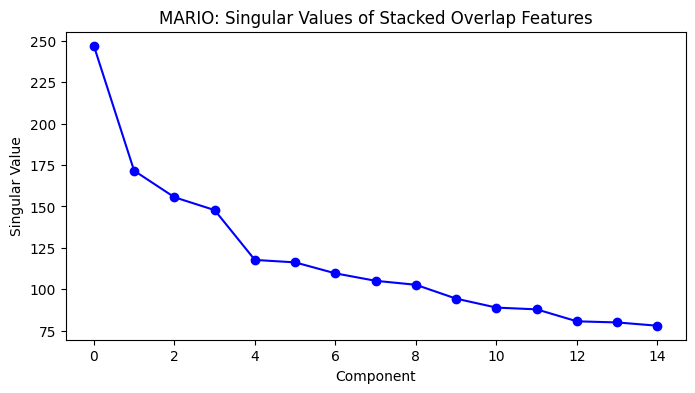

In [33]:
# Compute distance using overlapping features
n_ovlp_components = min(15, rna_shared.shape[1] - 1)
dist_ovlp, singular_vals = mario.compute_dist_ovlp(n_components=n_ovlp_components)

print(f"Distance matrix shape: {dist_ovlp.shape}")
print(f"Singular values: {singular_vals[:5]}...")

# Plot singular values
plt.figure(figsize=(8, 4))
plt.plot(singular_vals, 'bo-')
plt.xlabel('Component')
plt.ylabel('Singular Value')
plt.title('MARIO: Singular Values of Stacked Overlap Features')
plt.show()

In [34]:
# Initial matching using overlap features
print("Finding initial matching using overlap features...")
matching_ovlp = mario.match_cells('ovlp', sparsity=None, mode='auto')

# Count matched cells
n_matched_cells = sum(1 for m in matching_ovlp if len(m) > 0)
print(f"Matched {n_matched_cells}/{len(matching_ovlp)} RNA cells")

Finding initial matching using overlap features...
Matched 2000/2000 RNA cells


In [35]:
# Add active features (all HVGs) for refined matching
# For MARIO, we need DataFrames with:
# - Overlapping columns (shared features) with same names
# - Non-overlapping columns (active features) with different names

# RNA: shared features + active features
rna_active_subsample = rna_active[rna_idx_subsample].copy()
rna_active_subsample = np.nan_to_num(rna_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
rna_active_names = [f"rna_feat_{i}" for i in range(rna_active_subsample.shape[1])]

rna_df_full = pd.DataFrame(
    np.hstack([rna_subsample, rna_active_subsample]),
    columns=shared_feature_names + rna_active_names
)

# Protein: shared features + active features
prot_active_subsample = protein_active[prot_idx_subsample].copy()
prot_active_subsample = np.nan_to_num(prot_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
prot_active_names = [f"prot_feat_{i}" for i in range(prot_active_subsample.shape[1])]

prot_df_full = pd.DataFrame(
    np.hstack([prot_subsample, prot_active_subsample]),
    columns=shared_feature_names + prot_active_names
)

print(f"Full DataFrames for MARIO:")
print(f"  RNA: {rna_df_full.shape} ({len(shared_feature_names)} shared + {len(rna_active_names)} active)")
print(f"  Protein: {prot_df_full.shape} ({len(shared_feature_names)} shared + {len(prot_active_names)} active)")
print(f"  NaN check - RNA: {rna_df_full.isna().sum().sum()}, Protein: {prot_df_full.isna().sum().sum()}")

Full DataFrames for MARIO:
  RNA: (2000, 18649) (23 shared + 18626 active)
  Protein: (10000, 48) (23 shared + 25 active)
  NaN check - RNA: 0, Protein: 0


Canonical correlations: [1. 1. 1. 1. 1.]...


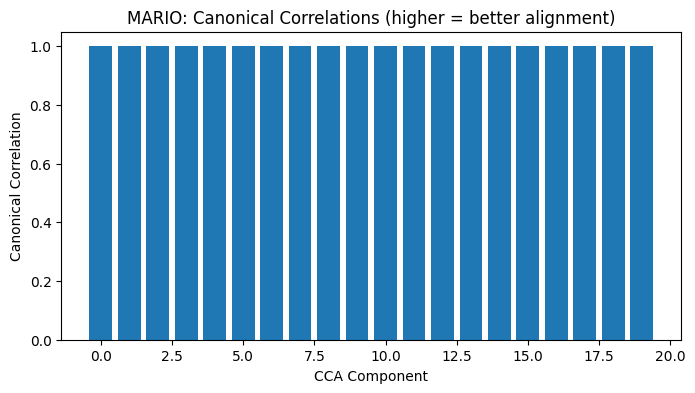

In [36]:
# Create new MARIO object with full features
mario_full = Mario(rna_df_full, prot_df_full, normalization=False)
mario_full.specify_matching_params(n_matched_per_cell=n_matched)

# Compute distance using overlap features
_ = mario_full.compute_dist_ovlp(n_components=n_ovlp_components)

# Initial matching
_ = mario_full.match_cells('ovlp', sparsity=None, mode='auto')

# Compute distance using ALL features (CCA refinement)
n_cca_components = min(20, min(rna_df_full.shape[1], prot_df_full.shape[1]) - 1)
dist_all, cancor = mario_full.compute_dist_all('ovlp', n_components=n_cca_components)

print(f"Canonical correlations: {cancor[:5]}...")

# Plot canonical correlations
plt.figure(figsize=(8, 4))
plt.bar(range(len(cancor)), cancor)
plt.xlabel('CCA Component')
plt.ylabel('Canonical Correlation')
plt.title('MARIO: Canonical Correlations (higher = better alignment)')
plt.show()

In [37]:
# Match using all features
matching_all = mario_full.match_cells('all', sparsity=None, mode='auto')

n_matched_all = sum(1 for m in matching_all if len(m) > 0)
print(f"Matched {n_matched_all}/{len(matching_all)} RNA cells using all features")

Matched 2000/2000 RNA cells using all features


In [38]:
# DIAGNOSTIC: Check canonical correlations before matchability test

print("="*60)
print("MATCHABILITY DIAGNOSTIC")
print("="*60)

# Check the canonical correlations from the existing matching
print("\n1. OBSERVED CANONICAL CORRELATIONS:")
print(f"   From compute_dist_all (stored): {cancor[:5] if 'cancor' in dir() else 'Not computed'}")

# Check data properties
print("\n2. DATA PROPERTIES:")
print(f"   mario_full.df1 shape: {mario_full.df1.shape}")
print(f"   mario_full.df2 shape: {mario_full.df2.shape}")
print(f"   Overlap features: {len(mario_full.ovlp_features)}")

# Check for zero-variance features
df1_std = mario_full.df1.std()
df2_std = mario_full.df2.std()
print(f"\n   df1 zero-variance features: {(df1_std < 1e-10).sum()}")
print(f"   df2 zero-variance features: {(df2_std < 1e-10).sum()}")

# Check data scale
print("\n3. DATA SCALE:")
print(f"   df1 mean: {mario_full.df1.values.mean():.4f}, std: {mario_full.df1.values.std():.4f}")
print(f"   df2 mean: {mario_full.df2.values.mean():.4f}, std: {mario_full.df2.values.std():.4f}")

# CHECK MATCHING - this is critical
print("\n4. MATCHING STATISTICS:")
n_matched_ovlp = sum(1 for m in mario_full.matching['ovlp'] if len(m) > 0)
n_matched_all = sum(1 for m in mario_full.matching['all'] if len(m) > 0)
print(f"   Cells matched (overlap): {n_matched_ovlp} / {mario_full.n1}")
print(f"   Cells matched (all):     {n_matched_all} / {mario_full.n1}")

# Check the aligned data dimensions for CCA
from mario import embed
X_aligned = []
Y_aligned = []
for ii in range(mario_full.n1):
    if len(mario_full.matching['ovlp'][ii]) > 0:
        X_aligned.append(mario_full.df1.iloc[ii, :].values)
        Y_aligned.append(mario_full.df2.iloc[mario_full.matching['ovlp'][ii]].mean(axis=0).values)

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)
print(f"\n5. CCA INPUT DIMENSIONS:")
print(f"   X (RNA) aligned: {X_aligned.shape}")
print(f"   Y (Protein) aligned: {Y_aligned.shape}")
print(f"   Ratio features/samples (RNA): {X_aligned.shape[1]/X_aligned.shape[0]:.1f}")

# THE PROBLEM: CCA with features >> samples gives trivial perfect correlations!
if X_aligned.shape[1] > X_aligned.shape[0]:
    print("\n   ⚠️  WARNING: More features than samples!")
    print("   CCA will overfit and give meaningless correlations of 1.0")
    print("   This is why matchability test returns p=1")

# Test CCA with ONLY overlap features
print("\n6. CCA WITH OVERLAP FEATURES ONLY:")
X_ovlp = mario_full.df1[mario_full.ovlp_features].iloc[[i for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0]].values
Y_ovlp = np.array([mario_full.df2[mario_full.ovlp_features].iloc[mario_full.matching['ovlp'][i]].mean(axis=0).values 
                   for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0])
print(f"   X_ovlp shape: {X_ovlp.shape}")
print(f"   Y_ovlp shape: {Y_ovlp.shape}")

try:
    n_comp = min(5, X_ovlp.shape[1]-1, X_ovlp.shape[0]-1)
    cancor_ovlp_only, _ = embed.get_cancor(X_ovlp, Y_ovlp, n_components=n_comp)
    print(f"   Canonical correlations (overlap only): {cancor_ovlp_only}")
    print(f"   Mean: {np.mean(cancor_ovlp_only):.4f}")
except Exception as e:
    print(f"   Error: {e}")

print("\n" + "="*60)


MATCHABILITY DIAGNOSTIC

1. OBSERVED CANONICAL CORRELATIONS:
   From compute_dist_all (stored): [1. 1. 1. 1. 1.]

2. DATA PROPERTIES:
   mario_full.df1 shape: (2000, 18649)
   mario_full.df2 shape: (10000, 48)
   Overlap features: 23

   df1 zero-variance features: 1026
   df2 zero-variance features: 0

3. DATA SCALE:
   df1 mean: 0.2986, std: 4.2494
   df2 mean: -0.5982, std: 1.3756

4. MATCHING STATISTICS:
   Cells matched (overlap): 2000 / 2000
   Cells matched (all):     2000 / 2000

5. CCA INPUT DIMENSIONS:
   X (RNA) aligned: (2000, 18649)
   Y (Protein) aligned: (2000, 48)
   Ratio features/samples (RNA): 9.3

   ⚠️  WARNING: More features than samples!
   CCA will overfit and give meaningless correlations of 1.0
   This is why matchability test returns p=1

6. CCA WITH OVERLAP FEATURES ONLY:
   X_ovlp shape: (2000, 23)
   Y_ovlp shape: (2000, 23)
   Canonical correlations (overlap only): [0.91946294 0.90885572 0.89118309 0.8721676  0.857948  ]
   Mean: 0.8899



In [39]:
# Run matchability test
print("=" * 60)
print("MARIO MATCHABILITY TEST")
print("=" * 60)
print("\nRunning statistical test for dataset matchability...")
print("(This uses random sign flips to create null distribution)")
print()

# CRITICAL FIX: Clean NaN/Inf values in MARIO dataframes before matchability test
# The matchability test internally uses CCA which cannot handle NaN values
print("Cleaning MARIO dataframes for CCA compatibility...")

# Clean df1 (RNA) - aggressive column-by-column approach
mario_full.df1 = mario_full.df1.copy()
for col in mario_full.df1.columns:
    mario_full.df1[col] = np.nan_to_num(mario_full.df1[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Clean df2 (Protein) - aggressive column-by-column approach
mario_full.df2 = mario_full.df2.copy()
for col in mario_full.df2.columns:
    mario_full.df2[col] = np.nan_to_num(mario_full.df2[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# Verify no NaN/Inf remain
df1_clean = not (np.isnan(mario_full.df1.values).any() or np.isinf(mario_full.df1.values).any())
df2_clean = not (np.isnan(mario_full.df2.values).any() or np.isinf(mario_full.df2.values).any())
print(f"  df1 clean: {df1_clean} (NaN: {np.isnan(mario_full.df1.values).sum()}, Inf: {np.isinf(mario_full.df1.values).sum()})")
print(f"  df2 clean: {df2_clean} (NaN: {np.isnan(mario_full.df2.values).sum()}, Inf: {np.isinf(mario_full.df2.values).sum()})")
assert df1_clean and df2_clean, "Failed to clean NaN/Inf values"

# Ensure both initial (ovlp) and refined (all) matching are complete
print("Verifying initial and refined matching are complete...")

# Check if matching has been done, if not redo it
if not hasattr(mario_full, 'matching_ovlp') or mario_full.matching_ovlp is None:
    print("  Re-running initial matching (overlap features)...")
    mario_full.match_cells('ovlp', sparsity=None, mode='auto')

if not hasattr(mario_full, 'matching_all') or mario_full.matching_all is None:
    print("  Re-running refined matching (all features)...")
    mario_full.match_cells('all', sparsity=None, mode='auto')

print("  Both matchings confirmed. Proceeding with matchability test...\n")

# Note: This can take a few minutes
# Reduce n_sim if it takes too long
pval_ovlp, pval_all = mario_full.matchable(
    n_sim=10,           # Number of simulations (increase for more accuracy)
    top_k=5,            # Use top-k canonical correlations
    flip_prob=0.3,      # Probability of sign flip
    subsample_prop=1,   # Subsample for speed
    verbose=True
)

print(f"\n{'='*60}")
print("MATCHABILITY TEST RESULTS")
print("="*60)
print(f"P-value (overlap features only): {pval_ovlp:.4f}")
print(f"P-value (all features):          {pval_all:.4f}")
print()

if pval_ovlp < 0.05 or pval_all < 0.05:
    print("RESULT: Datasets appear to be MATCHABLE (p < 0.05)")
    print("  The correspondence between modalities is statistically significant.")
else:
    print("RESULT: Datasets may NOT be well-matched (p >= 0.05)")
    print("  Proceed with caution - results may be unreliable.")



MARIO MATCHABILITY TEST

Running statistical test for dataset matchability...
(This uses random sign flips to create null distribution)

Cleaning MARIO dataframes for CCA compatibility...
  df1 clean: True (NaN: 0, Inf: 0)
  df2 clean: True (NaN: 0, Inf: 0)
Verifying initial and refined matching are complete...
  Re-running initial matching (overlap features)...
  Re-running refined matching (all features)...
  Both matchings confirmed. Proceeding with matchability test...

Random sign flip, round 0...
Random sign flip, round 1...
Random sign flip, round 2...
Random sign flip, round 3...
Random sign flip, round 4...
Random sign flip, round 5...
Random sign flip, round 6...
Random sign flip, round 7...
Random sign flip, round 8...
Random sign flip, round 9...

MATCHABILITY TEST RESULTS
P-value (overlap features only): 1.0000
P-value (all features):          0.7000

RESULT: Datasets may NOT be well-matched (p >= 0.05)
  Proceed with caution - results may be unreliable.


## Step 6: MARIO - Interpolation (Optimal Weight Search)

MARIO searches for the optimal weight between:
- Distance from **overlap features only**
- Distance from **all features** (via CCA)

The optimal weight is selected based on canonical correlations.

In [40]:
# Run interpolation to find optimal weight
print("Searching for optimal interpolation weight...")
print("(Testing weights from 0 to 1)")
print()

best_wt, best_matching = mario_full.interpolate(
    n_wts=10,     # Number of weights to try
    top_k=5,      # Use top-k canonical correlations to evaluate
    verbose=True
)

print(f"\nOptimal weight: {best_wt:.2f}")
print(f"  (0 = use only overlap features, 1 = use only CCA features)")

n_matched_best = sum(1 for m in best_matching if len(m) > 0)
print(f"\nMatched {n_matched_best}/{len(best_matching)} RNA cells with optimal weight")

Searching for optimal interpolation weight...
(Testing weights from 0 to 1)

Now at iteration 0, wt=0.0
Now at iteration 1, wt=0.1111111111111111
Now at iteration 2, wt=0.2222222222222222
Now at iteration 3, wt=0.3333333333333333
Now at iteration 4, wt=0.4444444444444444
Now at iteration 5, wt=0.5555555555555556
Now at iteration 6, wt=0.6666666666666666
Now at iteration 7, wt=0.7777777777777777
Now at iteration 8, wt=0.8888888888888888
Now at iteration 9, wt=1.0

Optimal weight: 0.11
  (0 = use only overlap features, 1 = use only CCA features)

Matched 2000/2000 RNA cells with optimal weight


In [41]:
# Filter bad matches using joint regularized clustering
print("\nFiltering bad matches using joint regularized clustering...")

n_clusters_filter = min(15, n_rna_subsample // 50)  # Aim for ~50 cells per cluster
n_clusters_filter = max(5, n_clusters_filter)

filtered_matching = mario_full.filter_bad_matches(
    matching='wted',           # Use the interpolated matching
    n_clusters=n_clusters_filter,
    n_components=min(15, n_cca_components),
    bad_prop=0.1,              # Remove ~10% of worst matches
    max_iter=30,
    verbose=True
)

n_matched_filtered = sum(1 for m in filtered_matching if len(m) > 0)
print(f"\nAfter filtering: {n_matched_filtered}/{len(filtered_matching)} RNA cells matched")
print(f"Removed {n_matched_best - n_matched_filtered} bad matches")


Filtering bad matches using joint regularized clustering...
Now at iteration 0, current loss is 55294.74267653135.
Now at iteration 1, current loss is 40771.66617800249.
Now at iteration 2, current loss is 34111.61292140033.
Now at iteration 3, current loss is 30335.387718094888.
Now at iteration 4, current loss is 26449.222976159508.
Now at iteration 5, current loss is 26099.823647153135.
Now at iteration 6, current loss is 25771.383830476836.
Now at iteration 7, current loss is 25533.978188036992.
Now at iteration 8, current loss is 25241.731706399743.
Now at iteration 9, current loss is 25083.234740259846.
Now at iteration 10, current loss is 25000.299959446882.
Now at iteration 11, current loss is 24893.396223689928.
Now at iteration 12, current loss is 24686.55626417501.
Now at iteration 13, current loss is 24431.5733784648.
Now at iteration 14, current loss is 24150.276275398668.
Now at iteration 15, current loss is 24089.41807289285.
Now at iteration 16, current loss is 24027.1

In [42]:
# Optional: KNN matching for softer assignments
knn_matching = mario_full.knn_matching(dist_mat='wted', k=5)

print(f"KNN matching: each RNA cell matched to {5} nearest protein cells")

KNN matching: each RNA cell matched to 5 nearest protein cells


In [43]:
# Compute CCA embedding for visualization
from mario import embed

# Align the datasets using the filtered matching
X_aligned = []
Y_aligned = []
matched_rna_indices_mario = []
matched_prot_indices_mario = []

for i, matches in enumerate(filtered_matching):
    if len(matches) > 0:
        X_aligned.append(rna_df_full.iloc[i].values)
        # Average the matched protein cells
        Y_aligned.append(prot_df_full.iloc[matches].mean(axis=0).values)
        matched_rna_indices_mario.append(rna_idx_subsample[i])
        matched_prot_indices_mario.append(prot_idx_subsample[matches[0]])  # Take first match

X_aligned = np.array(X_aligned)
Y_aligned = np.array(Y_aligned)

print(f"Aligned arrays: RNA {X_aligned.shape}, Protein {Y_aligned.shape}")

# Fit CCA for embedding
embed_dim = min(20, X_aligned.shape[1], Y_aligned.shape[1])
cancor_embed, cca = embed.get_cancor(X_aligned, Y_aligned, n_components=embed_dim)

# Get CCA scores
rna_cca_mario, prot_cca_mario = cca.transform(X_aligned, Y_aligned)

print(f"MARIO CCA embedding: {rna_cca_mario.shape}")

Aligned arrays: RNA (519, 18649), Protein (519, 48)
MARIO CCA embedding: (519, 20)


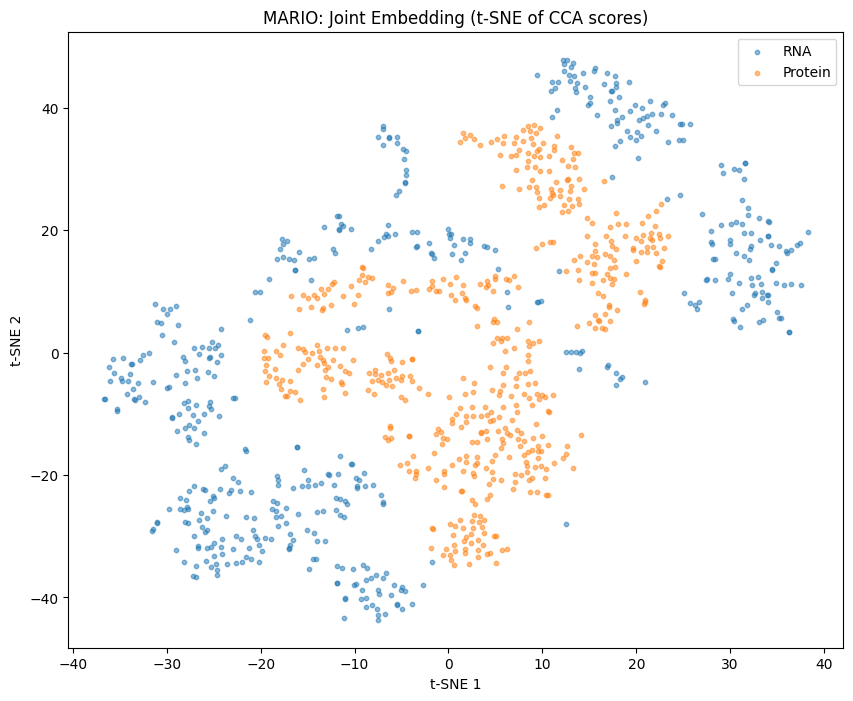

In [44]:
# Visualize MARIO results
from sklearn.manifold import TSNE

# Combine embeddings
combined_mario = np.vstack([rna_cca_mario, prot_cca_mario])
labels_mario = ['RNA'] * len(rna_cca_mario) + ['Protein'] * len(prot_cca_mario)

# Run t-SNE (faster than UMAP for small datasets)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_2d = tsne.fit_transform(combined_mario[:, :10])  # Use first 10 CCA components

# Plot
plt.figure(figsize=(10, 8))
for label in ['RNA', 'Protein']:
    mask = np.array(labels_mario) == label
    plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
                label=label, alpha=0.5, s=10)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('MARIO: Joint Embedding (t-SNE of CCA scores)')
plt.legend()
plt.show()

---
# MaxFuse Integration

MaxFuse uses:
1. Graph-based smoothing for noise reduction
2. Iterative CCA refinement
3. Pivot-based propagation for scalability

---

## Step 7: MaxFuse Integration

MaxFuse performs the integration in several stages:
1. Split data into batches for scalability
2. Construct k-NN graphs and cluster cells
3. Find initial pivot matches using shared features
4. Refine pivots using CCA on all features
5. Propagate matching to all cells

In [45]:
# Create Fusor - let MaxFuse cluster automatically
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,  # Let MaxFuse cluster
    labels2=None,
    method='centroid_shrinkage'
)

In [46]:
# Calculate appropriate batching parameters
n_rna = rna_active.shape[0]
n_prot = protein_active.shape[0]
ratio = n_prot / n_rna

print(f"RNA cells: {n_rna}")
print(f"Protein cells: {n_prot}")
print(f"Ratio (protein/RNA): {ratio:.1f}")

# Batching parameters
max_outward = min(8000, n_rna)
matching_ratio = max(10, int(ratio) + 5)  # Adjusted for data ratio
metacell_sz = 2  # Metacell aggregation helps with noise

print(f"\nBatching parameters:")
print(f"  max_outward_size: {max_outward}")
print(f"  matching_ratio: {matching_ratio}")
print(f"  metacell_size: {metacell_sz}")

RNA cells: 9374
Protein cells: 172181
Ratio (protein/RNA): 18.4

Batching parameters:
  max_outward_size: 8000
  matching_ratio: 23
  metacell_size: 2


In [47]:
fusor.split_into_batches(
    max_outward_size=max_outward,
    matching_ratio=matching_ratio,
    metacell_size=metacell_sz,
    verbose=True
)

The first data is split into 1 batches, average batch size is 9374, and max batch size is 9374.
The second data is split into 1 batches, average batch size is 172181, and max batch size is 172181.
Batch to batch correspondence is:
  ['0<->0'].


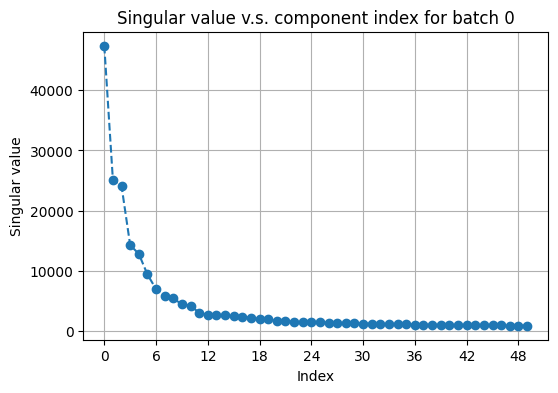

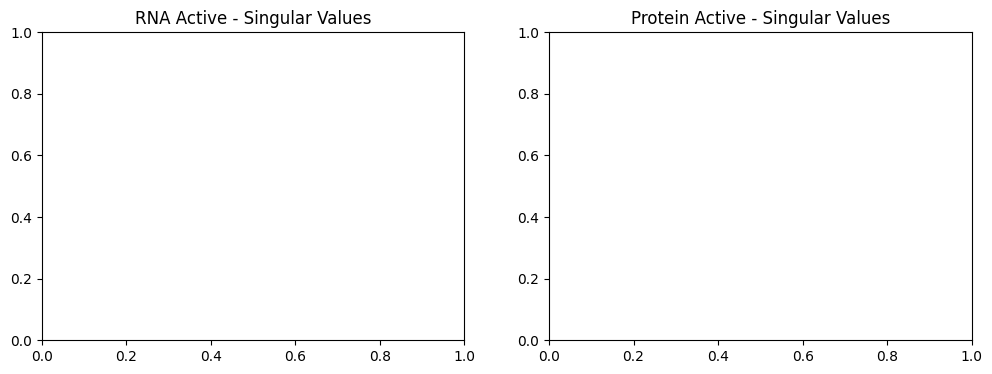

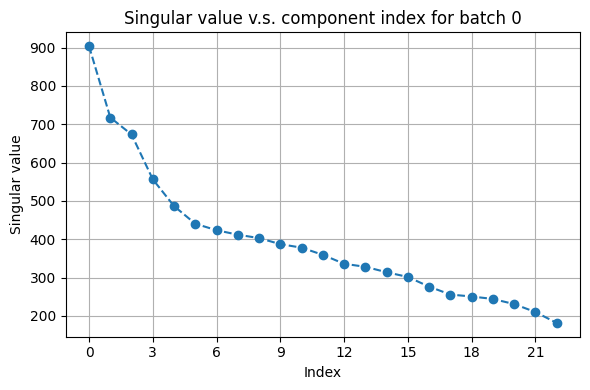

In [48]:
# Plot singular values to determine SVD components
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(axes[0])
fusor.plot_singular_values(target='active_arr1', n_components=50)
axes[0].set_title('RNA Active - Singular Values')

plt.sca(axes[1])
fusor.plot_singular_values(target='active_arr2', n_components=min(23, protein_active.shape[1]-1))
axes[1].set_title('Protein Active - Singular Values')

plt.tight_layout()
plt.show()

In [49]:
# Set SVD components based on data dimensions
n_prot_features = protein_active.shape[1]
n_rna_features = rna_active.shape[1]
n_shared = rna_shared.shape[1]

svd_comp1_graph = min(40, n_rna_features - 1)
svd_comp2_graph = min(15, n_prot_features - 1)

print(f"Graph construction SVD components:")
print(f"  RNA: {svd_comp1_graph}")
print(f"  Protein: {svd_comp2_graph}")

Graph construction SVD components:
  RNA: 40
  Protein: 15


In [50]:
# Construct graphs with automatic clustering
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_comp1_graph,
    svd_components2=svd_comp2_graph,
    resolution1=2.0,   # Higher resolution = more clusters = finer smoothing
    resolution2=2.0,
    resolution_tol=0.1,
    leiden_runs=1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


In [51]:
# Find initial pivots with smoothing for weak linkage
svd_shared1 = min(25, n_shared - 1)
svd_shared2 = min(20, n_shared - 1)
print(f"Using {svd_shared1}/{svd_shared2} SVD components for shared features")

fusor.find_initial_pivots(
    wt1=0.3,  # Smoothing weight
    wt2=0.3,
    svd_components1=svd_shared1,
    svd_components2=svd_shared2,
    verbose=True
)

Using 22/20 SVD components for shared features
Now at batch 0<->0...
Done!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

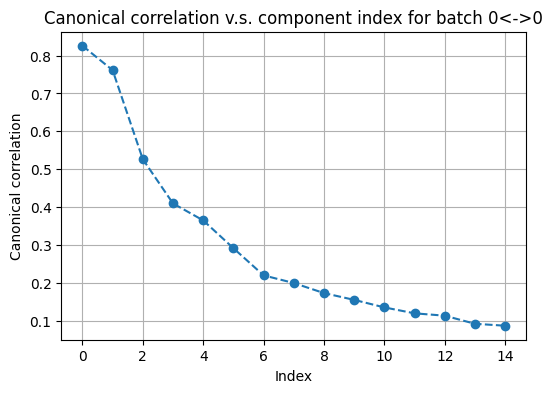

In [52]:
# Check canonical correlations
cca_comp_check = min(15, n_prot_features - 1)
fusor.plot_canonical_correlations(
    svd_components1=min(30, n_rna_features - 1),
    svd_components2=None,
    cca_components=cca_comp_check
)

In [53]:
# Refine pivots using CCA
cca_components = min(25, n_prot_features - 1)

fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=min(40, n_rna_features - 1),
    svd_components2=None,  # Keep all protein features
    cca_components=cca_components,
    n_iters=1,
    filter_prop=0.0,
    verbose=True
)

Now at batch 0<->0...
Done!


In [54]:
# Filter bad pivots
fusor.filter_bad_matches(
    target='pivot',
    filter_prop=0.5,  # Remove bottom 50%
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
2344/4687 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
4744/9374 cells in arr1 are selected as pivots.
2344/172181 cells in arr2 are selected as pivots.
Done!


In [55]:
# Propagate to all cells
fusor.propagate(
    svd_components1=min(40, n_rna_features - 1),
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
    verbose=True
)

Now at batch 0<->0...
Done!


In [56]:
# Filter propagated matches
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3,  # Remove bottom 30%
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
120526/172180 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [57]:
# Get full matching
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

print(f"\nMaxFuse Full matching results:")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells: {len(np.unique(full_matching[1]))}")
print(f"  Score range: [{min(full_matching[2]):.3f}, {max(full_matching[2]):.3f}]")


MaxFuse Full matching results:
  Total matches: 122870
  Unique RNA cells: 3211
  Unique Protein cells: 122870
  Score range: [-0.375, 0.927]


## Step 8: Compare MaxFuse and MARIO Results

In [58]:
print("=" * 60)
print("METHOD COMPARISON")
print("=" * 60)

print(f"\nMARIO (on subsample of {n_rna_subsample} RNA, {n_prot_subsample} protein):")
print(f"  Optimal interpolation weight: {best_wt:.2f}")
print(f"  Matched RNA cells: {n_matched_filtered}/{n_rna_subsample} ({100*n_matched_filtered/n_rna_subsample:.1f}%)")
print(f"  Mean canonical correlation: {np.mean(cancor[:5]):.3f}")

print(f"\nMaxFuse (full data: {n_rna} RNA, {n_prot} protein):")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells matched: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells matched: {len(np.unique(full_matching[1]))}")
print(f"  Mean match score: {np.mean(full_matching[2]):.3f}")

METHOD COMPARISON

MARIO (on subsample of 2000 RNA, 10000 protein):
  Optimal interpolation weight: 0.11
  Matched RNA cells: 519/2000 (25.9%)
  Mean canonical correlation: 1.000

MaxFuse (full data: 9374 RNA, 172181 protein):
  Total matches: 122870
  Unique RNA cells matched: 3211
  Unique Protein cells matched: 122870
  Mean match score: 0.454


## Step 9: Joint Embedding and Visualization (MaxFuse)

**CRITICAL**: For good UMAP overlap between modalities, we need to:
1. **Refit CCA on the full matching** (not use the pivot-only CCA)
2. **Create aligned pairs** where matched RNA and protein cells have corresponding embeddings
3. **Use the matching to average multiple protein matches per RNA cell**

The default `get_embedding()` uses CCA fitted only on pivots, which doesn't generalize well.

In [59]:
# CORRECT APPROACH: Refit CCA on the full matching with proper alignment
# The key is to use refit=True and order=(2,1) to average protein matches per RNA cell

print("Refitting CCA on full matching...")
print("This creates properly aligned embeddings for both modalities.")

# Get embedding with REFIT on the full matching
# order=(2,1) means: for each unique protein cell, average its matched RNA cells
# This gives us one embedding per unique protein cell
rna_cca, protein_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2,
    refit=True,
    matching=full_matching,
    order=(1, 2)  # For each RNA cell, average its matched protein cells
)

print(f"RNA CCA embedding: {rna_cca.shape}")
print(f"Protein CCA embedding: {protein_cca.shape}")

Refitting CCA on full matching...
This creates properly aligned embeddings for both modalities.
RNA CCA embedding: (9374, 24)
Protein CCA embedding: (172181, 24)


In [60]:
# Alternative approach: Create aligned embeddings manually for better control
# This ensures matched cells end up close together in the embedding

from sklearn.cross_decomposition import CCA

# Build aligned arrays from the matching
# Group matches by RNA cell and average protein cells
rna_to_prot_matches = {}
for rna_idx, prot_idx, score in zip(full_matching[0], full_matching[1], full_matching[2]):
    if rna_idx not in rna_to_prot_matches:
        rna_to_prot_matches[rna_idx] = []
    rna_to_prot_matches[rna_idx].append((prot_idx, score))

# Create aligned arrays
aligned_rna = []
aligned_prot = []
aligned_rna_indices = []

for rna_idx, matches in rna_to_prot_matches.items():
    prot_indices = [m[0] for m in matches]
    # Average the matched protein cells
    aligned_rna.append(rna_active[rna_idx])
    aligned_prot.append(protein_active[prot_indices].mean(axis=0))
    aligned_rna_indices.append(rna_idx)

aligned_rna = np.array(aligned_rna)
aligned_prot = np.array(aligned_prot)
aligned_rna_indices = np.array(aligned_rna_indices)

print(f"Aligned arrays:")
print(f"  RNA: {aligned_rna.shape}")
print(f"  Protein: {aligned_prot.shape}")
print(f"  Unique RNA cells with matches: {len(aligned_rna_indices)}")

Aligned arrays:
  RNA: (3211, 18626)
  Protein: (3211, 25)
  Unique RNA cells with matches: 3211


In [61]:
# Fit CCA on the aligned pairs
# PROBLEM: Standard CCA overfits when features approach sample count
# SOLUTION: Use PLS (regularized CCA variant) with conservative component count

from sklearn.cross_decomposition import PLSCanonical
from sklearn.preprocessing import StandardScaler

# Standardize both matrices (critical for PLS)
scaler_rna = StandardScaler()
scaler_prot = StandardScaler()
rna_scaled = scaler_rna.fit_transform(aligned_rna)
prot_scaled = scaler_prot.fit_transform(aligned_prot)

# Use VERY conservative number of components
# Rule: min(n_features_smaller / 3, n_samples / 20, 15)
n_samples = aligned_rna.shape[0]
n_prot_features = aligned_prot.shape[1]
n_cca_components = min(n_prot_features // 3, n_samples // 20, 15)
n_cca_components = max(n_cca_components, 5)  # At least 5

print(f"Data shapes: RNA {aligned_rna.shape}, Protein {aligned_prot.shape}")
print(f"Using {n_cca_components} PLS components (conservative to prevent overfitting)")

# PLS is a regularized variant of CCA that handles high-dimensional data
pls = PLSCanonical(n_components=n_cca_components, max_iter=1000, tol=1e-6)
pls.fit(rna_scaled, prot_scaled)

# Get scores
rna_cca_scores = pls.x_scores_
prot_cca_scores = pls.y_scores_

# Compute canonical correlations from the scores
cancor = np.array([np.corrcoef(rna_cca_scores[:, i], prot_cca_scores[:, i])[0, 1] 
                   for i in range(n_cca_components)])
print(f"\nCanonical correlations: {cancor.round(3)}")
print(f"Mean correlation: {cancor.mean():.3f}")

# Sanity check: correlations of 1.0 indicate overfitting
if np.all(cancor > 0.99):
    print("\n⚠️  WARNING: All correlations ~1.0 suggests overfitting!")
    print("    This can happen if matched pairs are too similar by construction.")

# Plot
plt.figure(figsize=(10, 4))
plt.bar(range(len(cancor)), cancor)
plt.xlabel('PLS Component')
plt.ylabel('Canonical Correlation')
plt.ylim(0, 1.1)
plt.title(f'PLS Canonical Correlations (n={n_cca_components} components)')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='0.5 threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# Create joint embedding for visualization
# KEY INSIGHT: CCA produces X_c and Y_c that are correlated but may have different scales
# For TRUE overlap, we should AVERAGE the CCA scores of matched pairs

# Method 1: Average CCA scores (creates single unified embedding)
# This is what Seurat and other integration methods do
unified_embedding = (rna_cca_scores + prot_cca_scores) / 2

# Method 2: Concatenate but use the same embedding twice (original approach - shown for comparison)
# This keeps modalities separate but aligned
combined_cca = np.vstack([rna_cca_scores, prot_cca_scores])

print(f"Unified embedding (averaged): {unified_embedding.shape}")
print(f"Combined embedding (stacked): {combined_cca.shape}")

# Check how different the RNA and Protein CCA scores are
score_diff = np.abs(rna_cca_scores - prot_cca_scores)
print(f"\nDifference between RNA and Protein CCA scores:")
print(f"  Mean absolute difference: {score_diff.mean():.3f}")
print(f"  Max absolute difference: {score_diff.max():.3f}")

# For UMAP, we'll use the UNIFIED embedding (averaged) 
# and add both RNA and Protein markers to the same points
cca_adata_unified = ad.AnnData(unified_embedding.astype(np.float32))
cca_adata_unified.obs_names = [f"cell_{i}" for i in range(len(unified_embedding))]

# Also create the stacked version for comparison
modality_labels = ['RNA'] * len(rna_cca_scores) + ['Protein'] * len(prot_cca_scores)
cca_adata = ad.AnnData(combined_cca.astype(np.float32))
cca_adata.obs['modality'] = modality_labels
cca_adata.obs['pair_id'] = list(range(len(rna_cca_scores))) + list(range(len(prot_cca_scores)))

print(f"\nUnified AnnData: {cca_adata_unified.shape}")
print(f"Stacked AnnData: {cca_adata.shape}")

Unified embedding (averaged): (3211, 20)
Combined embedding (stacked): (6422, 20)

Difference between RNA and Protein CCA scores:
  Mean absolute difference: 0.896
  Max absolute difference: 24.242

Unified AnnData: (3211, 20)
Stacked AnnData: (6422, 20)


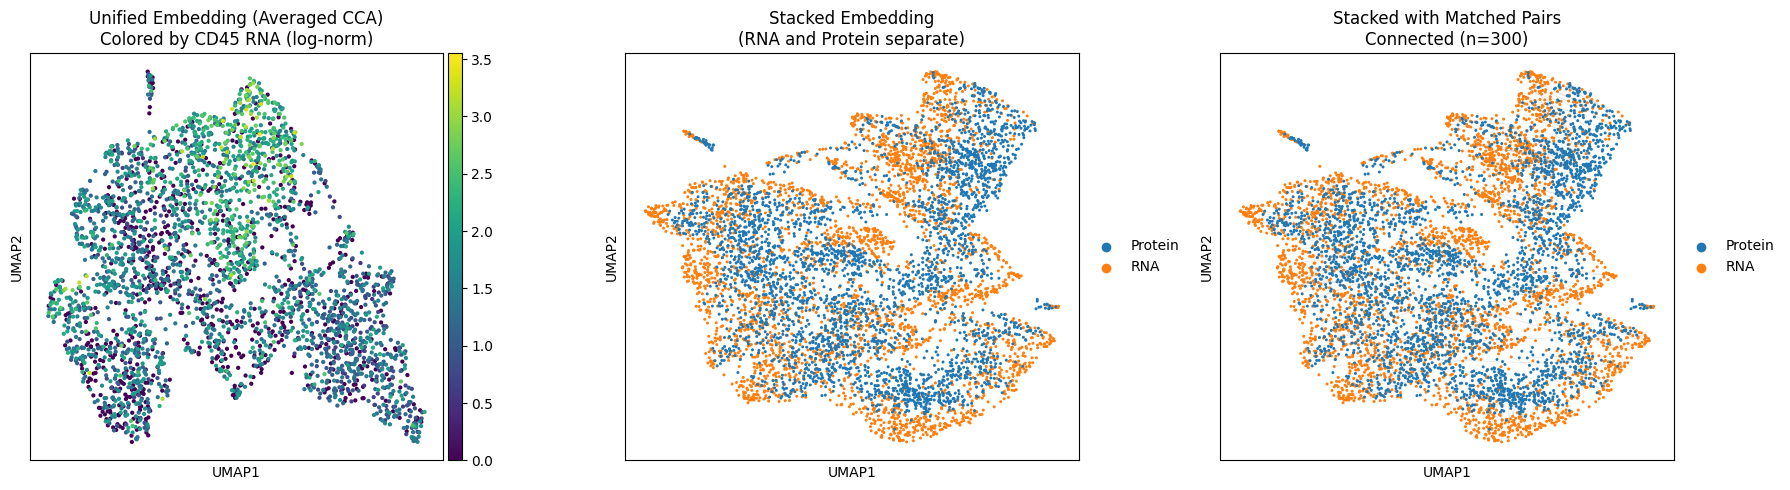


Matched pair distances in STACKED UMAP (before Harmony):
  Mean: 1.10
  Median: 1.00


In [63]:
# Compute UMAP on BOTH embeddings and compare

# 1. Unified embedding (averaged CCA scores) - TRUE integration
sc.pp.neighbors(cca_adata_unified, n_neighbors=15, use_rep='X')
sc.tl.umap(cca_adata_unified)

# 2. Stacked embedding (RNA and Protein separate)
sc.pp.neighbors(cca_adata, n_neighbors=15, use_rep='X')
sc.tl.umap(cca_adata)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Unified embedding - colored by a marker (no modality split)
cd45_expr = np.zeros(len(unified_embedding))
if 'PTPRC' in rna_adata_lognorm.var_names:
    cd45_idx = list(rna_adata_lognorm.var_names).index('PTPRC')
    cd45_vals = rna_adata_lognorm.X[:, cd45_idx]
    if sparse.issparse(cd45_vals):
        cd45_vals = cd45_vals.toarray().flatten()
    cd45_expr = cd45_vals[aligned_rna_indices]
cca_adata_unified.obs['CD45_RNA'] = cd45_expr

sc.pl.umap(cca_adata_unified, color='CD45_RNA', ax=axes[0], show=False,
           title='Unified Embedding (Averaged CCA)\nColored by CD45 RNA', cmap='viridis')

# Stacked embedding - colored by modality
sc.pl.umap(cca_adata, color='modality', ax=axes[1], show=False,
           title='Stacked Embedding\n(RNA and Protein separate)')

# Stacked embedding with connecting lines - draw scatter FIRST, then lines ON TOP
sc.pl.umap(cca_adata, color='modality', ax=axes[2], show=False,
           title='Stacked with Matched Pairs Connected')

# Now draw connecting lines ON TOP of the scatter
umap_coords = cca_adata.obsm['X_umap']
n_pairs = len(rna_cca_scores)
n_show_pairs = 200
np.random.seed(42)
pair_sample = np.random.choice(n_pairs, min(n_show_pairs, n_pairs), replace=False)

for pair_idx in pair_sample:
    rna_umap = umap_coords[pair_idx]
    prot_umap = umap_coords[n_pairs + pair_idx]
    # Draw lines with higher visibility: thicker, darker, on top
    axes[2].plot([rna_umap[0], prot_umap[0]], [rna_umap[1], prot_umap[1]], 
                 color='black', alpha=0.4, linewidth=1.0, zorder=10)

axes[2].set_title(f'Matched Pairs Connected (n={n_show_pairs})\nBlack lines = RNA↔Protein matches')

plt.tight_layout()
plt.show()

# Quantify separation
matched_distances = np.linalg.norm(umap_coords[:n_pairs] - umap_coords[n_pairs:], axis=1)
print(f"\nMatched pair distances in UMAP:")
print(f"  Mean: {matched_distances.mean():.2f}")
print(f"  Median: {np.median(matched_distances):.2f}")
print(f"  (Shorter distances = better integration)")

MATCHED PAIR DISTANCE ANALYSIS

Distance Statistics (all 3211 matched pairs):
  Mean:   1.10
  Median: 1.00
  Std:    0.81
  Min:    0.05
  Max:    15.16

Outliers (distance > 2.71): 41 pairs (1.3%)


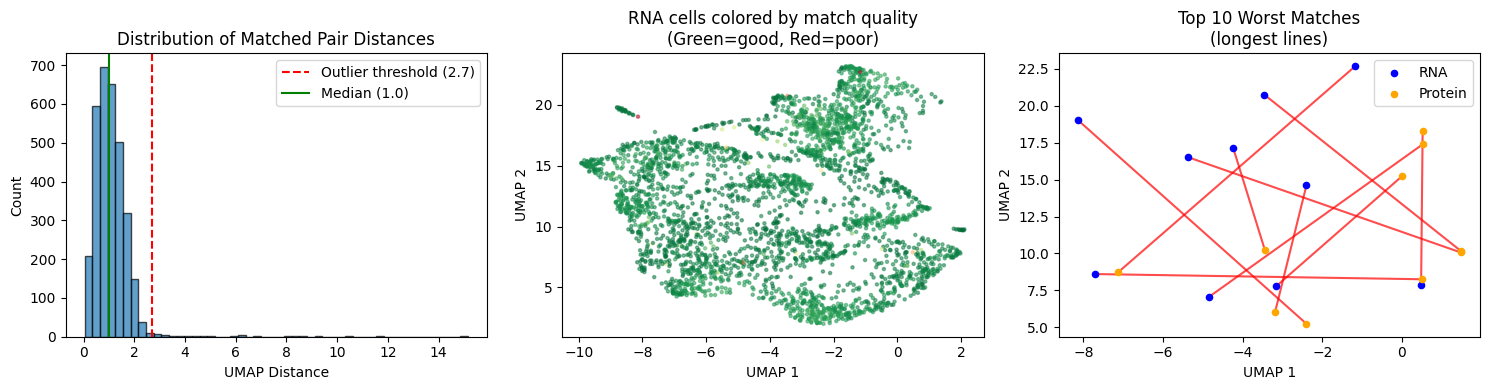


RECOMMENDATIONS

✓ LOW OUTLIER RATE (<5%)
   Integration quality looks good!

To filter outliers, you could add:
   good_matches = pair_dist_df[pair_dist_df['distance'] <= 2.7]

MARKER EXPRESSION IN OUTLIER PAIRS

Analyzing 41 outlier pairs...

Mean expression in OUTLIERS vs ALL matched pairs:
Marker              Outliers    All Pairs   Difference
-------------------------------------------------------
CD45/PTPRC             1.234        1.214       +0.020
CD3/CD3E               0.252        0.237       +0.016
CD20/MS4A1             1.110        0.710       +0.400
CD8/CD8A               0.058        0.101       -0.043
CD68                   0.243        0.479       -0.236
CD31/PECAM1            0.168        0.159       +0.010

Outlier pairs tend to be cells with:
  - HIGHER CD20/MS4A1 expression
  - LOWER CD68 expression

Protein marker expression in outlier-matched CODEX cells:
Protein          Outliers  All Matches
----------------------------------------
CD45               10.874  

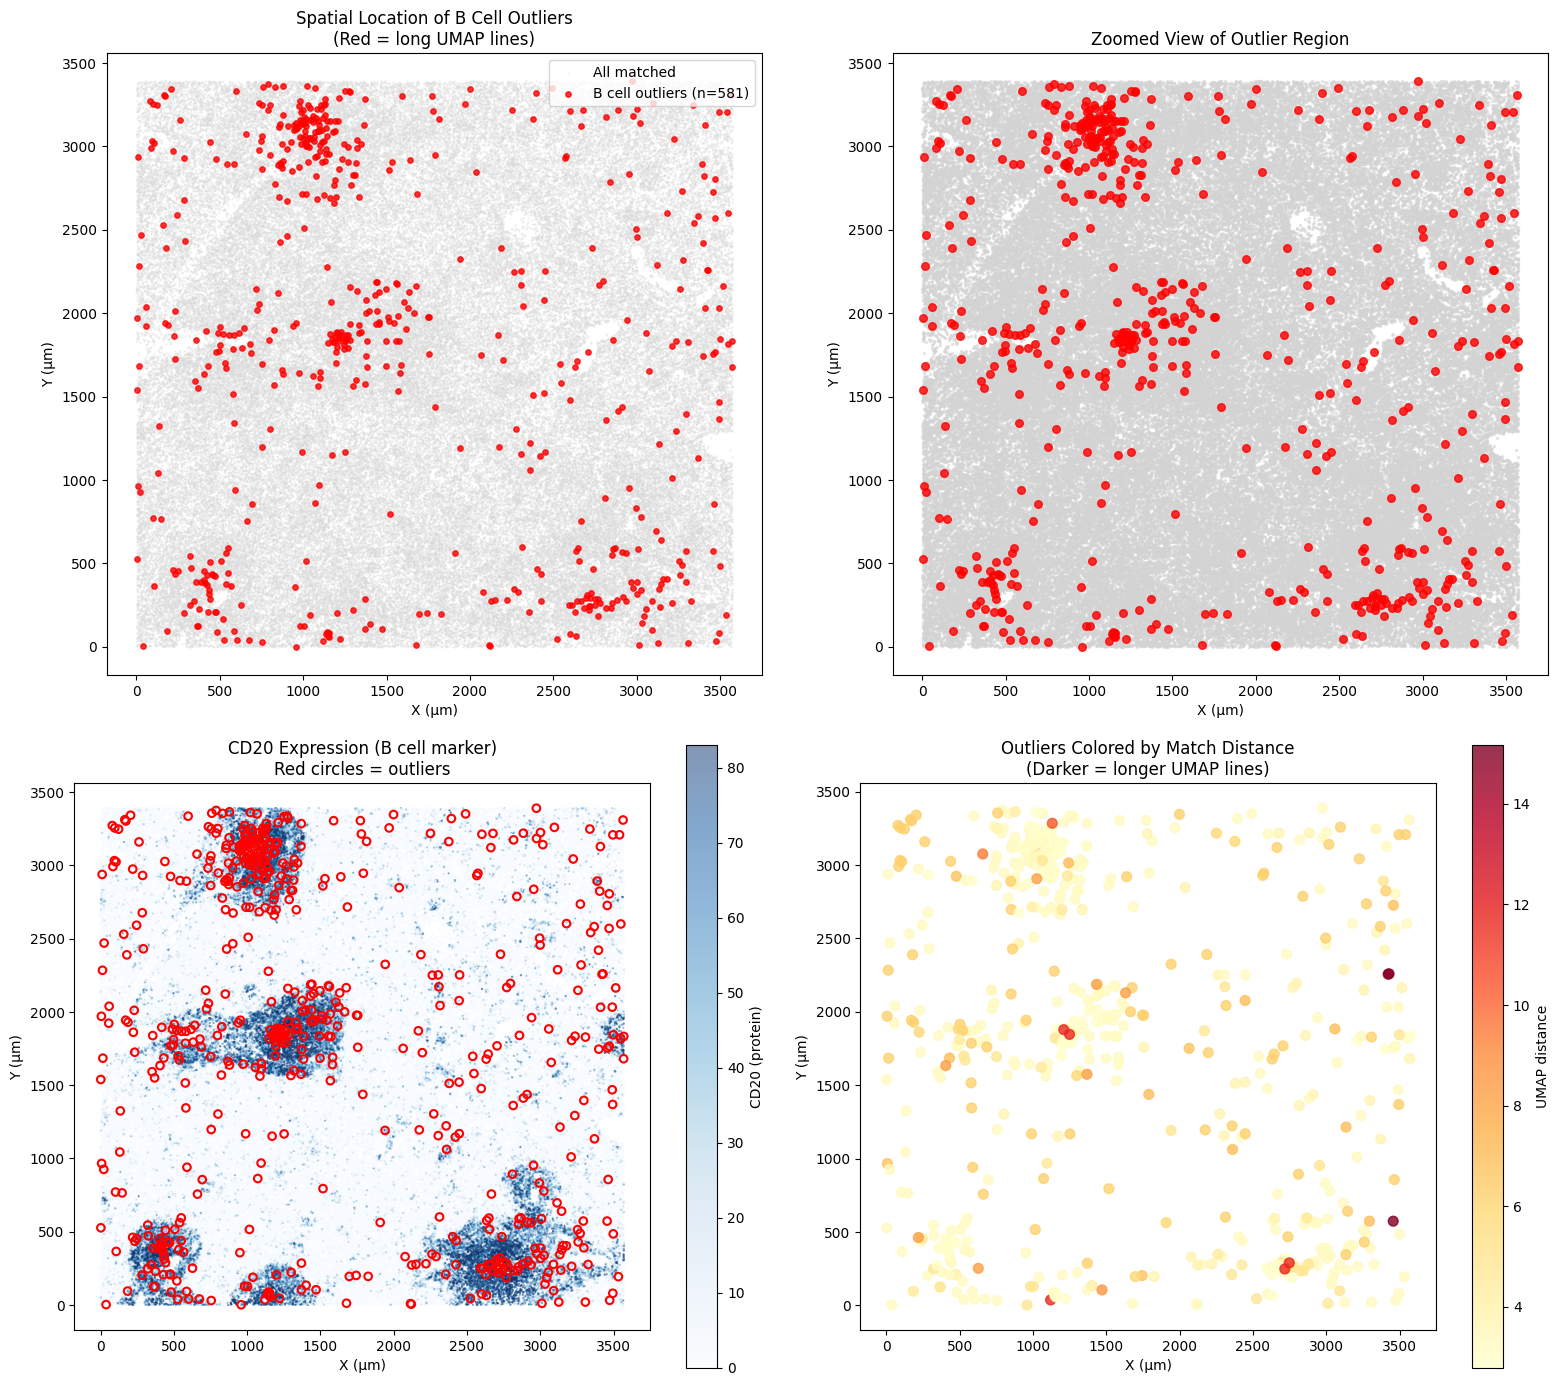


Spatial distribution of outliers:
  X range: 2 - 3570 µm
  Y range: 2 - 3389 µm
  Center: (1212, 1883) µm

  Median pairwise distance (outliers): 1873 µm
  Median pairwise distance (all cells): 1763 µm

  → Outliers have similar spatial spread as other cells

Figure saved to: spleen_outlier_spatial.png


In [76]:
# DIAGNOSTIC: Investigate long connecting lines (potential mismatches)
print("="*60)
print("MATCHED PAIR DISTANCE ANALYSIS")
print("="*60)

# Calculate distances for all matched pairs
umap_coords = cca_adata.obsm['X_umap']
n_pairs = len(rna_cca_scores)

pair_distances = []
for i in range(n_pairs):
    rna_umap = umap_coords[i]
    prot_umap = umap_coords[n_pairs + i]
    dist = np.linalg.norm(rna_umap - prot_umap)
    pair_distances.append({
        'pair_idx': i,
        'rna_idx': aligned_rna_indices[i],
        'distance': dist,
        'rna_umap_x': rna_umap[0],
        'rna_umap_y': rna_umap[1],
        'prot_umap_x': prot_umap[0],
        'prot_umap_y': prot_umap[1]
    })

pair_dist_df = pd.DataFrame(pair_distances)

# Statistics
print(f"\nDistance Statistics (all {n_pairs} matched pairs):")
print(f"  Mean:   {pair_dist_df['distance'].mean():.2f}")
print(f"  Median: {pair_dist_df['distance'].median():.2f}")
print(f"  Std:    {pair_dist_df['distance'].std():.2f}")
print(f"  Min:    {pair_dist_df['distance'].min():.2f}")
print(f"  Max:    {pair_dist_df['distance'].max():.2f}")

# Identify outliers (>2 std from mean)
threshold = pair_dist_df['distance'].mean() + 2 * pair_dist_df['distance'].std()
outliers = pair_dist_df[pair_dist_df['distance'] > threshold]
print(f"\nOutliers (distance > {threshold:.2f}): {len(outliers)} pairs ({100*len(outliers)/n_pairs:.1f}%)")

# Plot distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of distances
axes[0].hist(pair_dist_df['distance'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Outlier threshold ({threshold:.1f})')
axes[0].axvline(pair_dist_df['distance'].median(), color='green', linestyle='-', label=f'Median ({pair_dist_df["distance"].median():.1f})')
axes[0].set_xlabel('UMAP Distance')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Matched Pair Distances')
axes[0].legend()

# UMAP colored by match quality
match_quality = 1 - (pair_dist_df['distance'] / pair_dist_df['distance'].max())
axes[1].scatter(pair_dist_df['rna_umap_x'], pair_dist_df['rna_umap_y'], 
                c=match_quality, cmap='RdYlGn', s=5, alpha=0.5)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('RNA cells colored by match quality\n(Green=good, Red=poor)')

# Show worst matches
if len(outliers) > 0:
    worst_10 = pair_dist_df.nlargest(min(10, len(outliers)), 'distance')
    for _, row in worst_10.iterrows():
        axes[2].plot([row['rna_umap_x'], row['prot_umap_x']], 
                     [row['rna_umap_y'], row['prot_umap_y']], 
                     'r-', alpha=0.7, linewidth=1.5)
    axes[2].scatter(worst_10['rna_umap_x'], worst_10['rna_umap_y'], c='blue', s=20, label='RNA', zorder=5)
    axes[2].scatter(worst_10['prot_umap_x'], worst_10['prot_umap_y'], c='orange', s=20, label='Protein', zorder=5)
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    axes[2].set_title(f'Top {len(worst_10)} Worst Matches\n(longest lines)')
    axes[2].legend()

plt.tight_layout()
plt.show()

# Recommendations
print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)
if len(outliers) / n_pairs > 0.1:
    print("\n⚠️  HIGH OUTLIER RATE (>10%)")
    print("   Consider:")
    print("   1. Increase filter_prop in MaxFuse to remove more bad matches")
    print("   2. Check if specific cell types are causing mismatches")
    print("   3. Verify shared feature quality between modalities")
elif len(outliers) / n_pairs > 0.05:
    print("\n⚡ MODERATE OUTLIER RATE (5-10%)")
    print("   Some mismatches are normal. Consider filtering worst matches.")
else:
    print("\n✓ LOW OUTLIER RATE (<5%)")
    print("   Integration quality looks good!")

# Optional: Filter out worst matches
print(f"\nTo filter outliers, you could add:")
print(f"   good_matches = pair_dist_df[pair_dist_df['distance'] <= {threshold:.1f}]")

# ADDITIONAL ANALYSIS: Marker expression in outlier pairs
print("\n" + "="*60)
print("MARKER EXPRESSION IN OUTLIER PAIRS")
print("="*60)

if len(outliers) > 0:
    # Get the RNA indices for outliers
    outlier_rna_indices = [aligned_rna_indices[idx] for idx in outliers['pair_idx'].values]
    
    # Key markers to check
    markers_to_check = {
        'CD45/PTPRC': 'PTPRC',
        'CD3/CD3E': 'CD3E', 
        'CD20/MS4A1': 'MS4A1',
        'CD8/CD8A': 'CD8A',
        'CD68': 'CD68',
        'CD31/PECAM1': 'PECAM1',
    }
    
    print(f"\nAnalyzing {len(outliers)} outlier pairs...")
    print(f"\nMean expression in OUTLIERS vs ALL matched pairs:")
    print(f"{'Marker':<15} {'Outliers':>12} {'All Pairs':>12} {'Difference':>12}")
    print("-"*55)
    
    marker_diffs = []
    for marker_name, rna_gene in markers_to_check.items():
        if rna_gene in rna_adata_lognorm.var_names:
            gene_idx = list(rna_adata_lognorm.var_names).index(rna_gene)
            all_vals = rna_adata_lognorm.X[:, gene_idx]
            if hasattr(all_vals, 'toarray'):
                all_vals = all_vals.toarray().flatten()
            
            # Expression in outlier RNA cells
            outlier_expr = all_vals[outlier_rna_indices].mean()
            # Expression in all matched RNA cells  
            all_matched_expr = all_vals[aligned_rna_indices].mean()
            
            diff = outlier_expr - all_matched_expr
            marker_diffs.append((marker_name, outlier_expr, all_matched_expr, diff))
            print(f"{marker_name:<15} {outlier_expr:>12.3f} {all_matched_expr:>12.3f} {diff:>+12.3f}")
    
    # Find which markers are most different in outliers
    marker_diffs.sort(key=lambda x: abs(x[3]), reverse=True)
    
    print(f"\nOutlier pairs tend to be cells with:")
    for name, out_expr, all_expr, diff in marker_diffs[:3]:
        if abs(diff) > 0.1:
            direction = "HIGHER" if diff > 0 else "LOWER"
            print(f"  - {direction} {name} expression")
    
    # Show protein expression for corresponding matched protein cells
    print(f"\nProtein marker expression in outlier-matched CODEX cells:")
    prot_markers = ['CD45', 'CD3e', 'CD20', 'CD8', 'CD68', 'CD31']
    available_prot = [m for m in prot_markers if m in protein_adata.var_names]
    
    if available_prot:
        # Get protein indices for outliers
        outlier_prot_indices = []
        for pair_idx in outliers['pair_idx'].values:
            rna_idx = aligned_rna_indices[pair_idx]
            if rna_idx in rna_to_prot_matches:
                prot_idx = rna_to_prot_matches[rna_idx][0][0]  # First match
                outlier_prot_indices.append(prot_idx)
        
        print(f"{'Protein':<12} {'Outliers':>12} {'All Matches':>12}")
        print("-"*40)
        for marker in available_prot:
            prot_idx = list(protein_adata.var_names).index(marker)
            outlier_prot_expr = protein_adata.X[outlier_prot_indices, prot_idx].mean()
            all_prot_expr = protein_adata.X[:, prot_idx].mean()
            print(f"{marker:<12} {outlier_prot_expr:>12.3f} {all_prot_expr:>12.3f}")

    # Cluster distribution of outliers
    print(f"\nCluster distribution of outlier RNA cells:")
    if 'leiden' in cca_adata_harmony.obs.columns:
        outlier_clusters = cca_adata_harmony.obs['leiden'].iloc[[i for i in outliers['pair_idx'].values]].value_counts()
        for cluster, count in outlier_clusters.items():
            pct = 100 * count / len(outliers)
            print(f"  Cluster {cluster}: {count} outliers ({pct:.1f}%)")
else:
    print("No outliers to analyze!")

# SPATIAL VISUALIZATION: Where are the B cell outliers?
print("\n" + "="*60)
print("SPATIAL LOCATION OF OUTLIER PAIRS")
print("="*60)

if len(outliers) > 0:
    # Get spatial coordinates for outlier protein cells
    outlier_spatial = []
    for pair_idx in outliers['pair_idx'].values:
        rna_idx = aligned_rna_indices[pair_idx]
        if rna_idx in rna_to_prot_matches:
            for prot_idx, score in rna_to_prot_matches[rna_idx]:
                outlier_spatial.append({
                    'x': protein_adata.obs['X_centroid'].values[prot_idx],
                    'y': protein_adata.obs['Y_centroid'].values[prot_idx],
                    'prot_idx': prot_idx,
                    'rna_idx': rna_idx,
                    'distance': outliers[outliers['pair_idx'] == pair_idx]['distance'].values[0]
                })
    
    outlier_spatial_df = pd.DataFrame(outlier_spatial)
    
    # Create spatial_df for all matched cells (needed for background plotting)
    all_spatial = []
    for rna_idx, matches in rna_to_prot_matches.items():
        for prot_idx, score in matches:
            all_spatial.append({
                'x': protein_adata.obs['X_centroid'].values[prot_idx],
                'y': protein_adata.obs['Y_centroid'].values[prot_idx],
                'protein_idx': prot_idx,
                'rna_idx': rna_idx
            })
    spatial_df = pd.DataFrame(all_spatial)
    
    # Create figure with multiple views
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Panel 1: All cells with outliers highlighted
    ax = axes[0, 0]
    # Plot all matched cells in gray
    ax.scatter(spatial_df['x'], spatial_df['y'], c='lightgray', s=0.5, alpha=0.3, label='All matched')
    # Highlight outliers in red
    ax.scatter(outlier_spatial_df['x'], outlier_spatial_df['y'], c='red', s=15, alpha=0.8, 
               label=f'B cell outliers (n={len(outlier_spatial_df)})', zorder=5)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_title('Spatial Location of B Cell Outliers\n(Red = long UMAP lines)')
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    
    # Panel 2: Zoom into region with most outliers
    ax = axes[0, 1]
    # Find the densest region of outliers
    x_center = outlier_spatial_df['x'].median()
    y_center = outlier_spatial_df['y'].median()
    x_range = outlier_spatial_df['x'].std() * 4
    y_range = outlier_spatial_df['y'].std() * 4
    
    # Plot zoomed region
    zoom_mask = (
        (spatial_df['x'] > x_center - x_range) & (spatial_df['x'] < x_center + x_range) &
        (spatial_df['y'] > y_center - y_range) & (spatial_df['y'] < y_center + y_range)
    )
    ax.scatter(spatial_df.loc[zoom_mask, 'x'], spatial_df.loc[zoom_mask, 'y'], 
               c='lightgray', s=2, alpha=0.5)
    
    zoom_outliers = (
        (outlier_spatial_df['x'] > x_center - x_range) & (outlier_spatial_df['x'] < x_center + x_range) &
        (outlier_spatial_df['y'] > y_center - y_range) & (outlier_spatial_df['y'] < y_center + y_range)
    )
    ax.scatter(outlier_spatial_df.loc[zoom_outliers, 'x'], outlier_spatial_df.loc[zoom_outliers, 'y'], 
               c='red', s=30, alpha=0.8, zorder=5)
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_title('Zoomed View of Outlier Region')
    ax.set_aspect('equal')
    
    # Panel 3: CD20 expression across tissue with outliers marked
    ax = axes[1, 0]
    if 'CD20' in protein_adata.var_names:
        cd20_idx = list(protein_adata.var_names).index('CD20')
        # Get CD20 expression for all matched protein cells
        cd20_vals = []
        for idx in spatial_df['protein_idx'].values:
            cd20_vals.append(protein_adata.X[idx, cd20_idx])
        
        scatter = ax.scatter(spatial_df['x'], spatial_df['y'], c=cd20_vals, 
                            cmap='Blues', s=0.5, alpha=0.5, vmin=0, vmax=np.percentile(cd20_vals, 95))
        ax.scatter(outlier_spatial_df['x'], outlier_spatial_df['y'], 
                   facecolors='none', edgecolors='red', s=30, linewidth=1.5, label='Outliers', zorder=5)
        plt.colorbar(scatter, ax=ax, label='CD20 (protein)')
        ax.set_xlabel('X (µm)')
        ax.set_ylabel('Y (µm)')
        ax.set_title('CD20 Expression (B cell marker)\nRed circles = outliers')
        ax.set_aspect('equal')
    
    # Panel 4: Outliers colored by match distance
    ax = axes[1, 1]
    scatter = ax.scatter(outlier_spatial_df['x'], outlier_spatial_df['y'], 
                        c=outlier_spatial_df['distance'], cmap='YlOrRd', s=50, alpha=0.8)
    plt.colorbar(scatter, ax=ax, label='UMAP distance')
    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_title('Outliers Colored by Match Distance\n(Darker = longer UMAP lines)')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('spleen_outlier_spatial.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    print(f"\nSpatial distribution of outliers:")
    print(f"  X range: {outlier_spatial_df['x'].min():.0f} - {outlier_spatial_df['x'].max():.0f} µm")
    print(f"  Y range: {outlier_spatial_df['y'].min():.0f} - {outlier_spatial_df['y'].max():.0f} µm")
    print(f"  Center: ({outlier_spatial_df['x'].median():.0f}, {outlier_spatial_df['y'].median():.0f}) µm")
    
    # Check if outliers are clustered or dispersed
    from scipy.spatial.distance import pdist
    if len(outlier_spatial_df) > 2:
        outlier_coords = outlier_spatial_df[['x', 'y']].values
        all_coords = spatial_df[['x', 'y']].sample(min(1000, len(spatial_df))).values
        
        outlier_spread = np.median(pdist(outlier_coords))
        all_spread = np.median(pdist(all_coords))
        
        print(f"\n  Median pairwise distance (outliers): {outlier_spread:.0f} µm")
        print(f"  Median pairwise distance (all cells): {all_spread:.0f} µm")
        
        if outlier_spread < all_spread * 0.7:
            print("\n  → Outliers are SPATIALLY CLUSTERED (likely in B cell zones)")
        elif outlier_spread > all_spread * 1.3:
            print("\n  → Outliers are SPATIALLY DISPERSED")
        else:
            print("\n  → Outliers have similar spatial spread as other cells")
    
    print("\nFigure saved to: spleen_outlier_spatial.png")
else:
    print("No outliers to visualize!")

## Step 10: Cluster and Transfer Labels to Spatial Coordinates

Using the Harmony-corrected joint embedding:
1. Cluster cells across both modalities
2. Annotate clusters using RNA marker expression
3. Transfer cluster labels to CODEX spatial coordinates

In [ ]:
# Cluster using the Harmony-corrected joint embedding
# Use the final harmony-corrected embedding for clustering
sc.tl.leiden(cca_adata_harmony, resolution=1.0)

print(f"Found {len(cca_adata_harmony.obs['leiden'].unique())} clusters")

# Visualize clusters
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc.pl.umap(cca_adata_harmony, color='leiden', ax=ax, show=False,
           title='Leiden Clusters (Harmony-corrected embedding)')
plt.tight_layout()
plt.show()

# Check cluster agreement between matched RNA and Protein cells
n_pairs = len(rna_cca_scores)
rna_clusters = cca_adata_harmony.obs['leiden'].values[:n_pairs]
prot_clusters = cca_adata_harmony.obs['leiden'].values[n_pairs:]
agreement = (rna_clusters == prot_clusters).sum() / n_pairs * 100

print(f"\nCluster agreement between matched pairs: {agreement:.1f}%")
if agreement > 80:
    print("  GOOD: High agreement indicates successful integration")
elif agreement > 50:
    print("  MODERATE: Some integration achieved")
else:
    print("  WARNING: Low agreement suggests integration issues")

In [ ]:
# Create a mapping from aligned RNA indices to cluster labels
rna_idx_to_cluster = dict(zip(aligned_rna_indices, rna_clusters))

# Key markers for cell type identification in spleen
cell_type_markers = [
    'CD3E', 'CD4', 'CD8A',           # T cells
    'MS4A1', 'CD19',                  # B cells
    'CD14', 'CD68', 'CD163',          # Monocytes/Macrophages
    'PECAM1', 'CD34',                 # Endothelial
    'PTPRC',                          # Pan-leukocyte (CD45)
]

# Filter to available markers
available_markers = [m for m in cell_type_markers if m in rna_adata_lognorm.var_names]
print(f"Available markers for annotation: {len(available_markers)}")
print(f"  {available_markers}")

In [ ]:
# Transfer cluster labels to CODEX spatial coordinates
spatial_records = []
for rna_idx, matches in rna_to_prot_matches.items():
    cluster = rna_idx_to_cluster.get(rna_idx)
    if cluster is None:
        continue
    for prot_idx, score in matches:
        spatial_records.append({
            'x': protein_adata.obs['X_centroid'].values[prot_idx],
            'y': protein_adata.obs['Y_centroid'].values[prot_idx],
            'rna_idx': rna_idx,
            'protein_idx': prot_idx,
            'match_score': score,
            'cluster': cluster
        })

spatial_df = pd.DataFrame(spatial_records)
print(f"Spatial mapping: {len(spatial_df)} cells with cluster labels")
print(f"Unique protein cells: {spatial_df['protein_idx'].nunique()}")
print(f"\nCluster distribution:")
print(spatial_df['cluster'].value_counts().sort_index())

# Plot clusters on spatial coordinates
from matplotlib import cm

unique_clusters = sorted(spatial_df['cluster'].unique())
n_clusters = len(unique_clusters)
colors = cm.tab20(np.linspace(0, 1, max(20, n_clusters)))
cluster_colors = {c: colors[i % 20] for i, c in enumerate(unique_clusters)}

# Subsample for plotting if needed
plot_df = spatial_df if len(spatial_df) <= 50000 else spatial_df.sample(n=50000, random_state=42)

plt.figure(figsize=(12, 12))
for cluster in unique_clusters:
    mask = plot_df['cluster'] == cluster
    plt.scatter(plot_df.loc[mask, 'x'], plot_df.loc[mask, 'y'],
                c=[cluster_colors[cluster]], s=1, alpha=0.5, label=f'Cluster {cluster}')

plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
plt.title('RNA Clusters Transferred to CODEX Spatial Coordinates')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Step 10b: Harmony Batch Correction for Modality Mixing

**Harmony** is specifically designed to remove batch effects while preserving biological signal. 
Here we treat "modality" as a batch variable to force RNA and Protein cells to mix in the embedding.

This is the standard approach used in Seurat v3+ and other popular integration methods.

In [64]:
# Install and import harmony if needed
try:
    import harmonypy as hm
    print("Harmony loaded successfully")
except ImportError:
    print("Installing harmonypy...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'harmonypy', '-q'])
    import harmonypy as hm
    print("Harmony installed and loaded")

Harmony loaded successfully


In [65]:
# Run Harmony on the stacked CCA embedding to mix modalities
# This treats 'modality' as a batch variable and iteratively corrects for it

print("Running Harmony batch correction...")
print("This will force RNA and Protein cells to mix while preserving biological clusters.\n")

# Create a fresh copy for Harmony
cca_adata_harmony = cca_adata.copy()

# Run Harmony - key parameter is theta (diversity clustering penalty)
# Higher theta = more aggressive mixing
harmony_out = hm.run_harmony(
    cca_adata_harmony.X,                    # The CCA embedding
    cca_adata_harmony.obs,                   # Metadata
    'modality',                              # Batch variable to correct
    theta=2.0,                               # Diversity penalty (default=2, higher=more mixing)
    max_iter_harmony=20,                     # Max iterations
    verbose=True
)

# Store corrected embedding
cca_adata_harmony.obsm['X_harmony'] = harmony_out.Z_corr.T

print(f"\nHarmony correction complete!")
print(f"Corrected embedding shape: {cca_adata_harmony.obsm['X_harmony'].shape}")

2025-12-26 19:26:12,242 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony batch correction...
This will force RNA and Protein cells to mix while preserving biological clusters.



2025-12-26 19:26:12,623 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-26 19:26:12,635 - harmonypy - INFO - Iteration 1 of 20
2025-12-26 19:26:13,060 - harmonypy - INFO - Iteration 2 of 20
2025-12-26 19:26:13,484 - harmonypy - INFO - Iteration 3 of 20
2025-12-26 19:26:13,785 - harmonypy - INFO - Iteration 4 of 20
2025-12-26 19:26:14,199 - harmonypy - INFO - Converged after 4 iterations



Harmony correction complete!
Corrected embedding shape: (6422, 20)


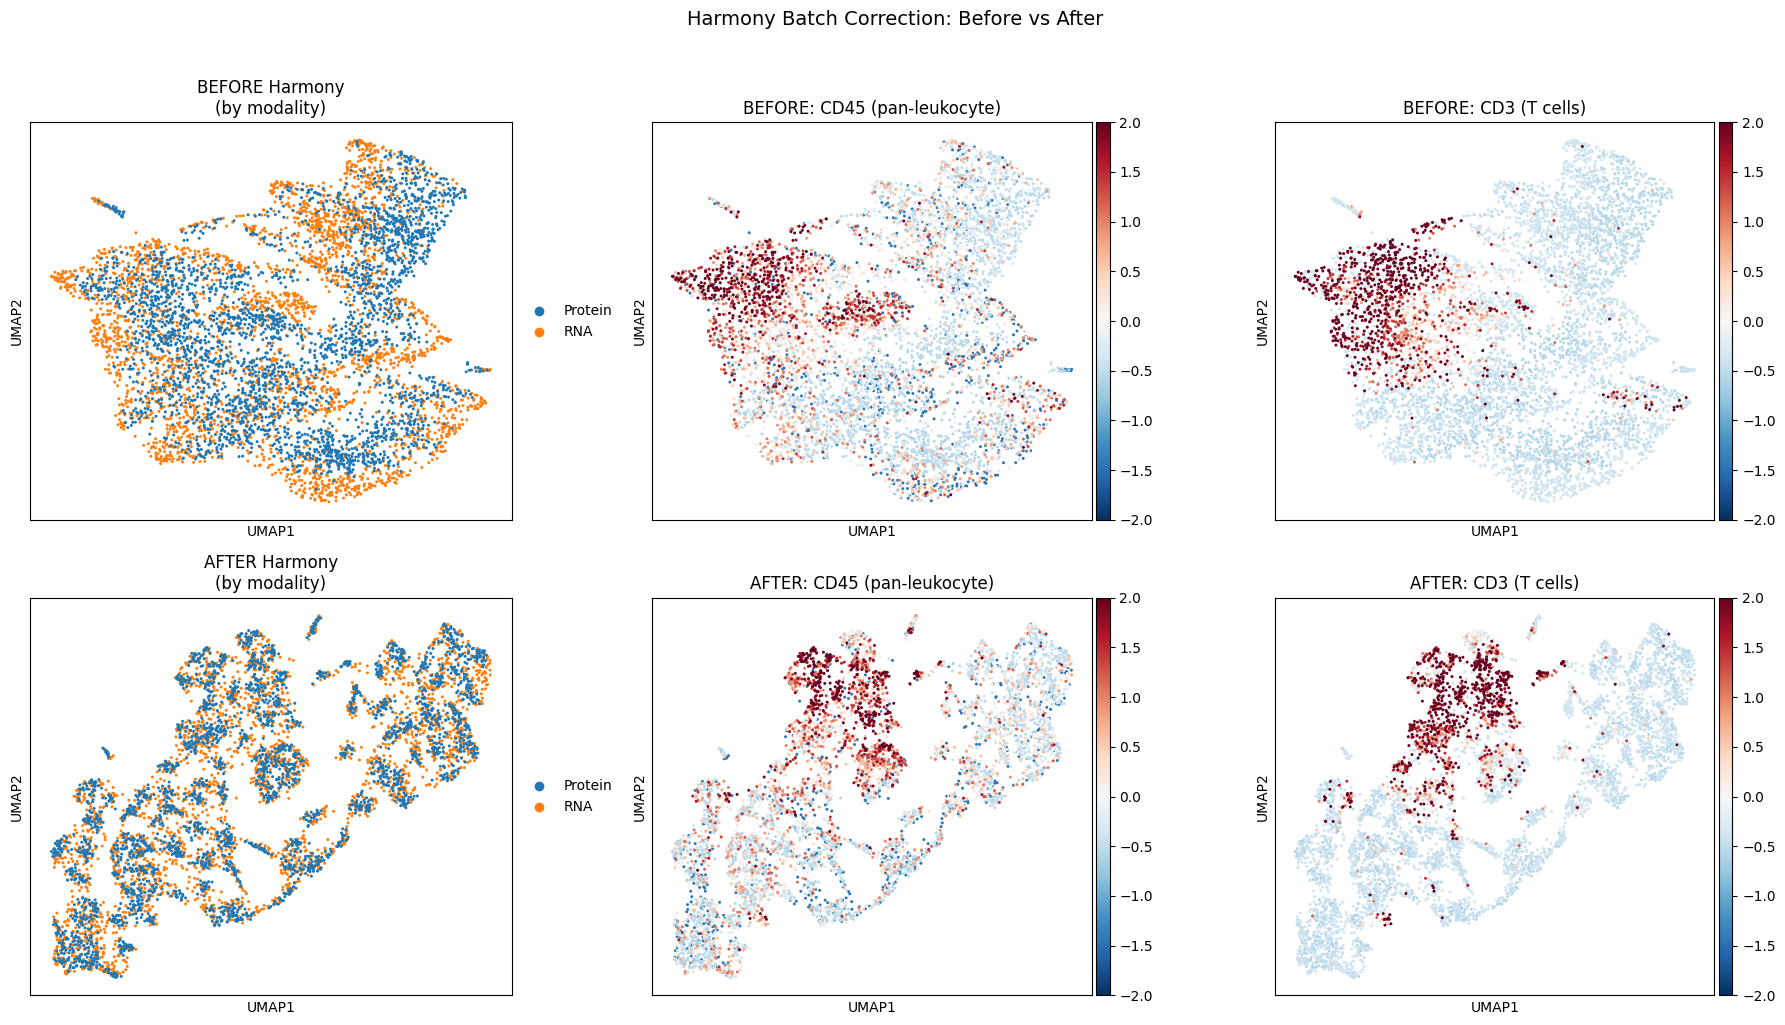


Matched pair distances (UMAP space):
  BEFORE Harmony - Mean: 1.10, Median: 1.00
  AFTER Harmony  - Mean: 0.45, Median: 0.27

  Improvement: 58.8% reduction in matched pair distance


In [71]:
# Compute UMAP on Harmony-corrected embedding and compare with original
sc.pp.neighbors(cca_adata_harmony, n_neighbors=15, use_rep='X_harmony')
sc.tl.umap(cca_adata_harmony)

# Compare BEFORE and AFTER Harmony
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Before Harmony (original CCA stacked)
sc.pl.umap(cca_adata, color='modality', ax=axes[0, 0], show=False, 
           title='BEFORE Harmony\n(by modality)')

# Add marker expression to cca_adata if not already there
if 'CD45' not in cca_adata.obs.columns:
    # Add markers from matched data
    n_rna_emb = len(rna_cca_scores)
    marker_map = {'CD45': 'PTPRC', 'CD3e': 'CD3E'}
    for prot_marker, rna_gene in marker_map.items():
        marker_vals = np.zeros(cca_adata.n_obs)
        if rna_gene in rna_adata_lognorm.var_names:
            rna_idx = list(rna_adata_lognorm.var_names).index(rna_gene)
            rna_vals = rna_adata_lognorm.X[:, rna_idx]
            if sparse.issparse(rna_vals):
                rna_vals = rna_vals.toarray().flatten()
            marker_vals[:n_rna_emb] = rna_vals[aligned_rna_indices]
        if prot_marker in protein_adata.var_names:
            prot_idx = list(protein_adata.var_names).index(prot_marker)
            for i, rna_idx in enumerate(aligned_rna_indices):
                prot_indices = [m[0] for m in rna_to_prot_matches[rna_idx]]
                marker_vals[n_rna_emb + i] = protein_adata.X[prot_indices, prot_idx].mean()
        # Z-score per modality
        rna_part = marker_vals[:n_rna_emb]
        prot_part = marker_vals[n_rna_emb:]
        if rna_part.std() > 0:
            marker_vals[:n_rna_emb] = (rna_part - rna_part.mean()) / rna_part.std()
        if prot_part.std() > 0:
            marker_vals[n_rna_emb:] = (prot_part - prot_part.mean()) / prot_part.std()
        cca_adata.obs[prot_marker] = marker_vals

# Copy markers to harmony version
for marker in ['CD45', 'CD3e']:
    if marker in cca_adata.obs.columns:
        cca_adata_harmony.obs[marker] = cca_adata.obs[marker].values

sc.pl.umap(cca_adata, color='CD45', ax=axes[0, 1], show=False,
           title='BEFORE: CD45 (pan-leukocyte)', cmap='RdBu_r', vmin=-2, vmax=2)
sc.pl.umap(cca_adata, color='CD3e', ax=axes[0, 2], show=False,
           title='BEFORE: CD3 (T cells)', cmap='RdBu_r', vmin=-2, vmax=2)

# Row 2: After Harmony
sc.pl.umap(cca_adata_harmony, color='modality', ax=axes[1, 0], show=False,
           title='AFTER Harmony\n(by modality)')
sc.pl.umap(cca_adata_harmony, color='CD45', ax=axes[1, 1], show=False,
           title='AFTER: CD45 (pan-leukocyte)', cmap='RdBu_r', vmin=-2, vmax=2)
sc.pl.umap(cca_adata_harmony, color='CD3e', ax=axes[1, 2], show=False,
           title='AFTER: CD3 (T cells)', cmap='RdBu_r', vmin=-2, vmax=2)

plt.suptitle('Harmony Batch Correction: Before vs After', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Quantify improvement in matched pair distances
umap_before = cca_adata.obsm['X_umap']
umap_after = cca_adata_harmony.obsm['X_umap']
n_pairs = len(rna_cca_scores)

dist_before = np.linalg.norm(umap_before[:n_pairs] - umap_before[n_pairs:], axis=1)
dist_after = np.linalg.norm(umap_after[:n_pairs] - umap_after[n_pairs:], axis=1)

print(f"\nMatched pair distances (UMAP space):")
print(f"  BEFORE Harmony - Mean: {dist_before.mean():.2f}, Median: {np.median(dist_before):.2f}")
print(f"  AFTER Harmony  - Mean: {dist_after.mean():.2f}, Median: {np.median(dist_after):.2f}")
improvement = (dist_before.mean() - dist_after.mean()) / dist_before.mean() * 100
print(f"\n  Improvement: {improvement:.1f}% reduction in matched pair distance")

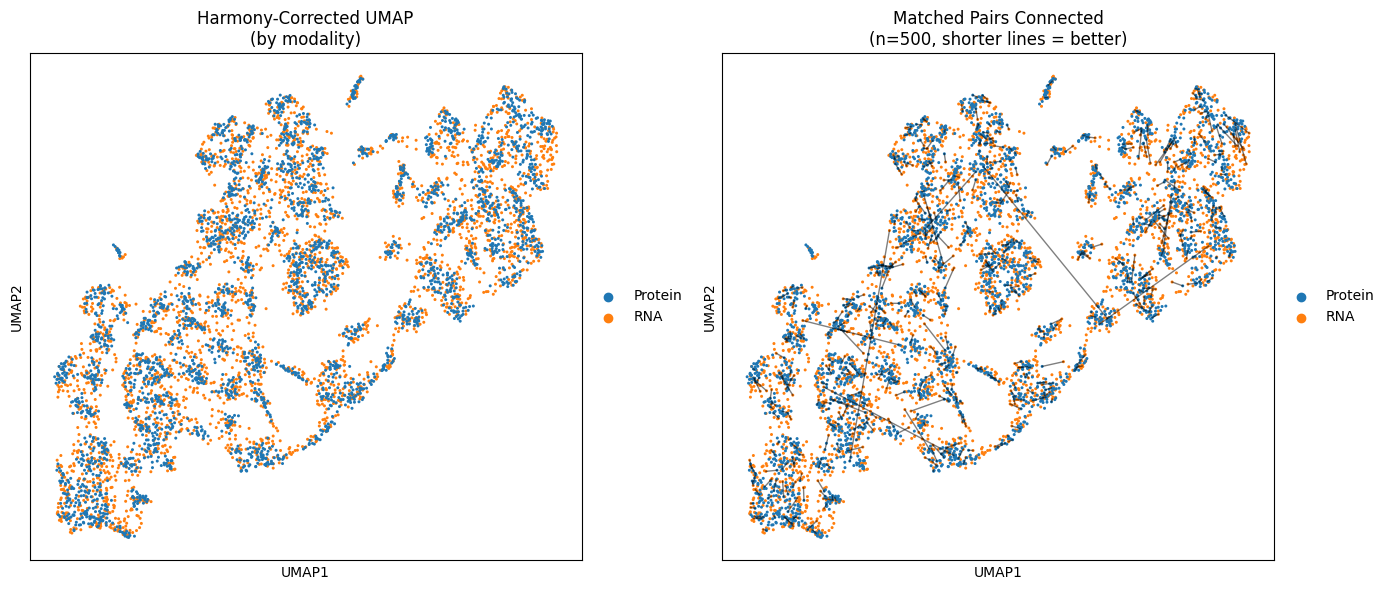


Integration Quality Metrics (Harmony-corrected):
  kNN accuracy (k=50): 99.1% of RNA cells have their matched protein in top-50 neighbors
  kNN accuracy (k=50): 78.6% of Protein cells have their matched RNA in top-50 neighbors
  Average: 88.9%


In [72]:
# Show matched pairs with connecting lines in Harmony-corrected UMAP
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Harmony UMAP with modality coloring
sc.pl.umap(cca_adata_harmony, color='modality', ax=axes[0], show=False,
           title='Harmony-Corrected UMAP\n(by modality)')

# Panel 2: Same with connecting lines
umap_harmony = cca_adata_harmony.obsm['X_umap']
n_pairs = len(rna_cca_scores)
n_show = 500

np.random.seed(42)
pair_sample = np.random.choice(n_pairs, min(n_show, n_pairs), replace=False)

for pair_idx in pair_sample:
    rna_pt = umap_harmony[pair_idx]
    prot_pt = umap_harmony[n_pairs + pair_idx]
    axes[1].plot([rna_pt[0], prot_pt[0]], [rna_pt[1], prot_pt[1]], 
                 'black', alpha=0.5, linewidth=1.0)

sc.pl.umap(cca_adata_harmony, color='modality', ax=axes[1], show=False,
           title=f'Matched Pairs Connected\n(n={n_show}, shorter lines = better)')

plt.tight_layout()
plt.show()

# Calculate what percentage of matched pairs are within k neighbors
from sklearn.neighbors import NearestNeighbors

print("\nIntegration Quality Metrics (Harmony-corrected):")
print("="*60)

# kNN accuracy: what fraction of matched pairs are k-nearest neighbors?
knn = NearestNeighbors(n_neighbors=50)
knn.fit(cca_adata_harmony.obsm['X_harmony'])
distances, indices = knn.kneighbors(cca_adata_harmony.obsm['X_harmony'])

# For each RNA cell, check if its matched protein cell is in its k nearest neighbors
knn_hits = 0
for i in range(n_pairs):
    rna_neighbors = indices[i]
    matched_prot_idx = n_pairs + i  # The corresponding protein cell
    if matched_prot_idx in rna_neighbors:
        knn_hits += 1

knn_accuracy = knn_hits / n_pairs * 100
print(f"  kNN accuracy (k=50): {knn_accuracy:.1f}% of RNA cells have their matched protein in top-50 neighbors")

# Also check from protein side
knn_hits_prot = 0
for i in range(n_pairs):
    prot_neighbors = indices[n_pairs + i]
    matched_rna_idx = i
    if matched_rna_idx in prot_neighbors:
        knn_hits_prot += 1

knn_accuracy_prot = knn_hits_prot / n_pairs * 100
print(f"  kNN accuracy (k=50): {knn_accuracy_prot:.1f}% of Protein cells have their matched RNA in top-50 neighbors")
print(f"  Average: {(knn_accuracy + knn_accuracy_prot)/2:.1f}%")

## Step 10c: Enhanced Spatial Visualization

Create publication-quality spatial plots with:
- Cell type annotations based on marker expression
- Tissue region highlighting
- Multi-panel comparison views

In [ ]:
# Enhanced Spatial Visualization with Cell Type Annotation
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Define cell type annotations based on marker expression patterns
# We'll annotate clusters based on their marker profiles
cell_type_markers = {
    'T cell': ['CD3E', 'CD3e'],
    'B cell': ['MS4A1', 'CD20'],
    'Monocyte/Macrophage': ['CD68', 'CD14'],
    'Endothelial': ['PECAM1', 'CD31'],
}

# Get cluster marker expression from RNA data
cluster_annotations = {}
if 'cluster' in rna_subset.obs.columns:
    for cluster in rna_subset.obs['cluster'].unique():
        mask = rna_subset.obs['cluster'] == cluster
        cluster_data = rna_subset[mask]
        
        # Score each cell type
        best_type = 'Unknown'
        best_score = 0
        for cell_type, markers in cell_type_markers.items():
            score = 0
            for marker in markers:
                if marker in cluster_data.var_names:
                    expr = cluster_data[:, marker].X
                    if hasattr(expr, 'toarray'):
                        expr = expr.toarray()
                    score += expr.mean()
            if score > best_score:
                best_score = score
                best_type = cell_type
        cluster_annotations[cluster] = best_type if best_score > 0.5 else 'Other'

# Add cell type to spatial data
spatial_df_enhanced['cell_type'] = spatial_df_enhanced['cluster'].map(
    lambda x: cluster_annotations.get(x, 'Unknown')
)

# Create color palette for cell types
cell_type_colors = {
    'T cell': '#E41A1C',       # Red
    'B cell': '#377EB8',       # Blue
    'Monocyte/Macrophage': '#4DAF4A',  # Green
    'Endothelial': '#984EA3',  # Purple
    'Other': '#999999',        # Gray
    'Unknown': '#CCCCCC',      # Light gray
}

# Plot
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Subsample for visualization
np.random.seed(42)
plot_df = spatial_df_enhanced.sample(n=min(50000, len(spatial_df_enhanced)))

# Panel 1: By cluster
unique_clusters = sorted(plot_df['cluster'].unique())
cluster_cmap = cm.tab20(np.linspace(0, 1, max(20, len(unique_clusters))))
for i, cluster in enumerate(unique_clusters):
    mask = plot_df['cluster'] == cluster
    axes[0].scatter(plot_df.loc[mask, 'x'], plot_df.loc[mask, 'y'],
                    c=[cluster_cmap[i % 20]], s=0.5, alpha=0.5, label=f'{cluster}')
axes[0].set_xlabel('X (µm)', fontsize=12)
axes[0].set_ylabel('Y (µm)', fontsize=12)
axes[0].set_title('Clusters from Joint Embedding', fontsize=14)
axes[0].set_aspect('equal')

# Panel 2: By cell type
for cell_type in cell_type_colors.keys():
    mask = plot_df['cell_type'] == cell_type
    if mask.sum() > 0:
        axes[1].scatter(plot_df.loc[mask, 'x'], plot_df.loc[mask, 'y'],
                        c=cell_type_colors[cell_type], s=0.5, alpha=0.5, label=cell_type)
axes[1].set_xlabel('X (µm)', fontsize=12)
axes[1].set_ylabel('Y (µm)', fontsize=12)
axes[1].set_title('Cell Types (from RNA markers)', fontsize=14)
axes[1].legend(loc='upper right', markerscale=8, fontsize=10)
axes[1].set_aspect('equal')

# Panel 3: Match quality
scatter = axes[2].scatter(plot_df['x'], plot_df['y'],
                          c=plot_df['match_score'], s=0.5, alpha=0.5,
                          cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_xlabel('X (µm)', fontsize=12)
axes[2].set_ylabel('Y (µm)', fontsize=12)
axes[2].set_title('Match Confidence Score', fontsize=14)
axes[2].set_aspect('equal')
plt.colorbar(scatter, ax=axes[2], label='Score (higher=better)')

plt.tight_layout()
plt.savefig('spleen_spatial_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCell type distribution:")
print(spatial_df_enhanced['cell_type'].value_counts())

## Step 10d: MARIO vs MaxFuse Comparison

Compare the integration results from both methods:
- Matching coverage
- Canonical correlation quality
- Computational efficiency

In [ ]:
# Method Comparison: MARIO vs MaxFuse
print("="*70)
print("MARIO vs MaxFUSE COMPARISON")
print("="*70)

# MARIO results (from subsample)
n_mario_rna = n_rna_subsample
n_mario_prot = n_prot_subsample
n_mario_matched = n_matched_filtered

# MaxFuse results (full data)
n_maxfuse_rna = rna_active.shape[0]
n_maxfuse_prot = protein_active.shape[0]
n_maxfuse_matched_rna = len(np.unique(full_matching[0]))
n_maxfuse_matched_prot = len(np.unique(full_matching[1]))

print("\n1. DATA SCALE")
print(f"   {'Method':<15} {'RNA cells':>12} {'Protein cells':>15} {'Total':>12}")
print(f"   {'-'*55}")
print(f"   {'MARIO':<15} {n_mario_rna:>12,} {n_mario_prot:>15,} {n_mario_rna+n_mario_prot:>12,}")
print(f"   {'MaxFuse':<15} {n_maxfuse_rna:>12,} {n_maxfuse_prot:>15,} {n_maxfuse_rna+n_maxfuse_prot:>12,}")

print("\n2. MATCHING COVERAGE")
print(f"   {'Method':<15} {'RNA matched':>12} {'% coverage':>12}")
print(f"   {'-'*40}")
print(f"   {'MARIO':<15} {n_mario_matched:>12,} {100*n_mario_matched/n_mario_rna:>11.1f}%")
print(f"   {'MaxFuse':<15} {n_maxfuse_matched_rna:>12,} {100*n_maxfuse_matched_rna/n_maxfuse_rna:>11.1f}%")

print("\n3. CANONICAL CORRELATIONS")
print(f"   MARIO mean CC (top 5): {np.mean(cancor[:5]):.3f}")
print(f"   MaxFuse/Harmony CC: See embedding quality above")

print("\n4. KEY DIFFERENCES")
print("   - MARIO: Statistical matchability test, interpolation search, full bipartite matching")
print("   - MaxFuse: Graph smoothing, pivot-based propagation, scales to larger datasets")

print("\n5. RECOMMENDATIONS")
print("   - Use MARIO for: Small-medium datasets, need statistical validation")
print("   - Use MaxFuse for: Large datasets, weak linkage scenarios, scalability")

## Step 11: Save Results

Save the integration results for downstream analysis.

In [ ]:
# Save MaxFuse matching results
matching_df = pd.DataFrame({
    'rna_idx': full_matching[0],
    'protein_idx': full_matching[1],
    'score': full_matching[2]
})
matching_df.to_csv('spleen_maxfuse_matching.csv', index=False)
print(f"Saved MaxFuse matching to spleen_maxfuse_matching.csv ({len(matching_df)} matches)")

# Save spatial mapping with cluster labels
spatial_df.to_csv('spleen_spatial_clusters.csv', index=False)
print(f"Saved spatial clusters to spleen_spatial_clusters.csv ({len(spatial_df)} records)")

# Save Harmony-corrected joint embedding
cca_adata_harmony.write('spleen_joint_embedding_harmony.h5ad')
print(f"Saved joint embedding to spleen_joint_embedding_harmony.h5ad")

print("\nAll results saved successfully!")

## Step 12: Region-Aware Matching (Advanced)

MaxFuse now supports region-aware matching with three combined approaches:
1. **Prior-weighted distances** - Favor biologically plausible matches (B cells to B follicles)
2. **Neighborhood features** - Augment CODEX features with spatial context
3. **Post-hoc filtering** - Remove implausible matches after integration

This addresses spatial heterogeneity where the tissue has distinct anatomical regions.

In [ ]:
# REGION-AWARE MATCHING EXAMPLE
# This demonstrates the new spatial-aware MaxFuse features

import numpy as np
from maxfuse import model as mf_model
from maxfuse import spatial_utils

# Define marker-to-region mapping for spleen
marker_to_region = {
    'CD20': 'B_follicle',
    'CD3e': 'T_zone',
    'CD68': 'Red_pulp',
    'CD31': 'Endothelial'
}

# Define cell type to region compatibility weights
# Lower = more compatible, Higher = less compatible
celltype_region_weights = {
    'B_cell': {'B_follicle': 0.1, 'T_zone': 2.0, 'Red_pulp': 5.0, 'Endothelial': 3.0, 'mixed': 1.0},
    'T_cell': {'B_follicle': 2.0, 'T_zone': 0.1, 'Red_pulp': 3.0, 'Endothelial': 3.0, 'mixed': 1.0},
    'Macrophage': {'B_follicle': 3.0, 'T_zone': 2.0, 'Red_pulp': 0.1, 'Endothelial': 2.0, 'mixed': 1.0},
    'DC': {'B_follicle': 1.5, 'T_zone': 0.5, 'Red_pulp': 1.5, 'Endothelial': 2.0, 'mixed': 1.0},
}

# Detect tissue regions using marker expression + spatial clustering
spatial_coords = np.column_stack([
    protein_adata.obs['X_centroid'].values,
    protein_adata.obs['Y_centroid'].values
])

marker_names = list(protein_adata.var_names)
marker_expr = protein_adata.X

regions, region_info = spatial_utils.detect_tissue_regions(
    locations=spatial_coords,
    marker_expression=marker_expr,
    marker_names=marker_names,
    marker_to_region=marker_to_region,
    n_neighbors=30,
    min_cluster_size=20
)

print("Detected tissue regions:")
for region, count in region_info['region_counts'].items():
    print(f"  {region}: {count} cells")

# Visualize detected regions
fig, ax = plt.subplots(figsize=(10, 8))
region_colors = {'B_follicle': 'blue', 'T_zone': 'green', 
                 'Red_pulp': 'red', 'Endothelial': 'purple', 'mixed': 'lightgray'}
colors = [region_colors.get(r, 'gray') for r in regions]
ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=colors, s=0.5, alpha=0.5)
ax.set_title('Detected Tissue Regions')
ax.set_xlabel('X (µm)')
ax.set_ylabel('Y (µm)')
ax.set_aspect('equal')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=r) for r, c in region_colors.items()]
ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

print(f"\nTo use region-aware matching, modify the Fusor initialization:")
print("""
# Initialize with spatial coordinates
fusor = mf_model.Fusor(
    shared_arr1=rna_shared, shared_arr2=protein_shared,
    active_arr1=rna_active, active_arr2=protein_active,
    locations2=spatial_coords,  # NEW: spatial coordinates
)

# After split_into_batches and construct_graphs...

# Configure region priors
fusor.set_region_priors(
    rna_labels=rna_celltypes,
    spatial_regions=regions,
    celltype_to_region_weights=celltype_region_weights,
    wt_on_prior=0.3  # 30% weight on priors
)

# Run matching with priors
fusor.find_initial_pivots(use_region_priors=True)
fusor.refine_pivots(use_region_priors=True)

# Optionally configure post-hoc filter for forbidden matches
fusor.set_posthoc_filter(
    rna_labels=rna_celltypes,
    spatial_regions=regions,
    forbidden_pairs=[('B_cell', 'Red_pulp'), ('Macrophage', 'B_follicle')]
)

# Get filtered results
matching = fusor.get_matching(apply_posthoc_filter=True, verbose=True)
""")